In [1]:
import os 
from scipy.signal.windows import hann
import pandas as pd 
import numpy as np
from numpy.fft import fft
from torch.utils.data import WeightedRandomSampler, DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch 
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from torchvision.models import resnet18
from torch import nn, optim
import seaborn as sns
import timm
import torch.nn as nn
from torchvision import models
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
import timm
import torch, gc
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from torch.cuda.amp import autocast, GradScaler
from torch.amp import autocast, GradScaler


# Feature Extraction

## STFT_exp1

In [2]:
df_aug = pd.read_pickle('data_augmented.pkl')

In [3]:
# Spectrogram (Experiment 2: Standard STFT)

# STFT Parameters
fs = 12000              # Sampling frequency
fi = 100                # Frame rate
Nseg = int(fs / fi)     # STFT segment/window size (120 samples)
Nfft = 256              # Number of FFT points

# Final tensor shape: (Frequency bins, Time frames, Channels)
target_shape = (128, 64, 1)   # Single-channel standard STFT


In [4]:
def compute_stft(x, Nseg, Nfft):
    overlap_ratio = 0.9
    Nover = int(Nseg * overlap_ratio)
    Nstep = Nseg - Nover
    Nframe = (len(x) - Nseg) // Nstep
    X = np.zeros((Nframe, Nfft))
    window = hann(Nseg)
    for n in range(Nframe):
        start = n * Nstep
        end = start + Nseg
        segment = x[start:end] * window
        spectrum = np.abs(fft(segment, Nfft))
        X[n, :] = spectrum
    return X.T


def normalize_tensor(tensor):
    tensor = np.abs(tensor)  # Ensure all values are non-negative
    tensor = np.log1p(tensor)
    return tensor / np.max(tensor)

def fix_tensor_shape(tensor, target_shape):
    tensor = tensor[:target_shape[0], :target_shape[1], :target_shape[2]]
    padded = np.zeros(target_shape, dtype=np.float32)
    padded[:tensor.shape[0], :tensor.shape[1], :tensor.shape[2]] = tensor
    return padded

In [5]:
processed_data = []

for index, row in df_aug.iterrows():
    signal = row['signal']
    label = row['fault_class_id']

    #  Use Nseg for both segment and FFT size
    X = compute_stft(signal, Nseg, Nseg)  # NOT Nseg1 anymore

    # Truncate to fixed shape
    X = X[:128, :64]  # (Freq x Time)

    # Add channel dimension
    raw_tensor = X[:, :, np.newaxis]  # Shape: (128, 64, 1)

    # Normalize and pad to target shape
    normalized = normalize_tensor(raw_tensor)
    fixed = fix_tensor_shape(normalized, target_shape)

    processed_data.append({'tensor': fixed, 'label': label})


### Train-Test Split and DataLoader 

In [6]:
class STFTSingleChannelDataset(Dataset):
    def __init__(self, tensors, labels, transform=None):
        self.data = tensors
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # (128, 64, 1) → squeeze to (128, 64) for grayscale image
        img_array = (self.data[idx].squeeze(-1) * 255).astype(np.uint8)  # shape: (128, 64)
        
        # Convert to grayscale PIL Image
        image = Image.fromarray(img_array, mode='L')  # 'L' mode = grayscale

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(self.labels[idx], dtype=torch.long)

In [7]:
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),                         # [1, H, W]
#     transforms.Lambda(lambda x: x.repeat(3, 1, 1)), # [3, H, W]
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # --> [1, H, W]
    transforms.Normalize(mean=[0.5], std=[0.5])  # for single-channel input
])
# transform = transforms.Compose([
#     transforms.Resize((299, 299)),               # ✅ Required for Inception
#     transforms.ToTensor(),                       # ✅ Keeps shape [1, H, W]
#     transforms.Normalize(mean=[0.5], std=[0.5])  # ✅ Single-channel normalization
# ])

In [8]:
# -------------------------------
# STEP 4: Train/Test Split (80/20)
# -------------------------------

X = [item['tensor'] for item in processed_data]
y = [item['label'] for item in processed_data]

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)



In [9]:
# -------------------------------
# STEP 5: 10-Fold CV on 80% Train
# -------------------------------

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
    print(f"\n--- Fold {fold + 1} ---")

    X_train = [X_trainval[i] for i in train_idx]
    y_train = [y_trainval[i] for i in train_idx]
    X_val = [X_trainval[i] for i in val_idx]
    y_val = [y_trainval[i] for i in val_idx]

    # Class weights for imbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weights = [class_weights[label] for label in y_train]
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    
    # Dataset & Loaders
    train_dataset = STFTSingleChannelDataset(X_train, y_train, transform=transform)
    val_dataset = STFTSingleChannelDataset(X_val, y_val, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

    # --- Insert your model, optimizer, criterion, and training logic here ---
    # e.g., train_model(model, train_loader, val_loader, ...)
    

# -------------------------------
# STEP 6: Final Test Loader (20%)
# -------------------------------

test_dataset = STFTSingleChannelDataset(X_test, y_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


# --- Use test_loader for final evaluation after best model selection ---



--- Fold 1 ---

--- Fold 2 ---

--- Fold 3 ---

--- Fold 4 ---

--- Fold 5 ---

--- Fold 6 ---

--- Fold 7 ---

--- Fold 8 ---

--- Fold 9 ---

--- Fold 10 ---


In [10]:

# Count class occurrences
train_counts = Counter(y_trainval)
test_counts = Counter(y_test)

# Mapping class ID to (Fault Type, Diameter)
fault_map = {
    0: ("Ball Fault", "0.007\""),
    1: ("Ball Fault", "0.014\""),
    2: ("Ball Fault", "0.021\""),
    3: ("Inner Race Fault", "0.007\""),
    4: ("Inner Race Fault", "0.014\""),
    5: ("Inner Race Fault", "0.021\""),
    6: ("Outer Race Fault", "0.007\""),
    7: ("Outer Race Fault", "0.014\""),
    8: ("Outer Race Fault", "0.021\""),
    9: ("Normal (Healthy)", "--")
}

# Fill in the table data
rows = []
for class_id in range(10):
    fault_type, diameter = fault_map[class_id]
    train_sample_count = train_counts.get(class_id, 0)
    test_sample_count = test_counts.get(class_id, 0)
    rows.append([class_id, fault_type, diameter, train_sample_count, test_sample_count])

# Add total row
total_train = sum(train_counts.values())
total_test = sum(test_counts.values())
rows.append(["", "Total", "--", total_train, total_test])

# Display as DataFrame 
df_class_dist = pd.DataFrame(rows, columns=[
    "Class ID", "Fault Type", "Diameter (in)", "Train samples", "Test samples"
])

print(df_class_dist.to_string(index=False))


Class ID       Fault Type Diameter (in)  Train samples  Test samples
       0       Ball Fault        0.007"            874           218
       1       Ball Fault        0.014"            874           218
       2       Ball Fault        0.021"            874           218
       3 Inner Race Fault        0.007"            873           219
       4 Inner Race Fault        0.014"            835           209
       5 Inner Race Fault        0.021"            874           218
       6 Outer Race Fault        0.007"           2256           564
       7 Outer Race Fault        0.014"            432           108
       8 Outer Race Fault        0.021"           1910           478
       9 Normal (Healthy)            --            182            46
                    Total            --           9984          2496


# Experiment 2: Baseline Models

## ResNet- 18- 128 * 64

In [ ]:
# def get_timm_model(model_name, num_classes):
#     model = timm.create_model(model_name, pretrained=True)
    
#     if hasattr(model, 'fc'):
#         in_features = model.fc.in_features
#         model.fc = nn.Linear(in_features, num_classes)
#     elif hasattr(model, 'classifier'):
#         in_features = model.classifier.in_features
#         model.classifier = nn.Linear(in_features, num_classes)
#     elif hasattr(model, 'head'):
#         in_features = model.head.in_features
#         model.head = nn.Linear(in_features, num_classes)
#     else:
#         raise ValueError(f"Unknown classifier structure for model: {model_name}")
    
#     return model

In [13]:
def get_timm_model(model_name, num_classes):
    model = timm.create_model(model_name, pretrained=True, in_chans=1)  # ✅ force 1-channel input
    
    if hasattr(model, 'fc'):
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'classifier'):
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'head'):
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, num_classes)
    else:
        raise ValueError(f"Unknown classifier structure for model: {model_name}")
    
    return model


In [14]:
def get_resnet18_bundle(num_classes=10, lr=1e-4, weight_decay=1e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_timm_model("resnet18", num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    return model, device, criterion, optimizer


In [15]:
from torch.cuda.amp import autocast, GradScaler
from torch.amp import autocast, GradScaler

In [16]:
from torch.amp import autocast, GradScaler
from sklearn.metrics import f1_score
import torch
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=None):
    scaler = GradScaler()
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_f1_macro': [], 'val_classwise_f1': []
    }
    best_val_f1 = 0.0
    best_model_path = f"best_model_fold{fold+1}.pth" if fold is not None else "best_model.pth"

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=True):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            with autocast("cuda"):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == y_batch).item()

        train_loss /= len(train_loader.dataset)
        train_acc = 100. * train_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        all_preds, all_labels = [], []

        for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=True):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            with torch.no_grad(), autocast("cuda"):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == y_batch).item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        class_f1 = f1_score(all_labels, all_preds, average=None)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1_macro'].append(macro_f1)
        history['val_classwise_f1'].append(class_f1)

        if macro_f1 > best_val_f1:
            best_val_f1 = macro_f1
            torch.save(model.state_dict(), best_model_path)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
              f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, Val F1-Macro={macro_f1:.4f}")

    return history


In [17]:
from torch.utils.data import WeightedRandomSampler, DataLoader
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tqdm import tqdm

# Initialize CV history dictionary
cv_history = {
    'train_acc': [], 'val_acc': [],
    'train_loss': [], 'val_loss': [],
    'val_f1_macro': [], 'val_classwise_f1': []
}

# Loop over folds
for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
    print(f"\n--- Fold {fold + 1} ---")

    # Prepare train/val data
    X_train = [X_trainval[i] for i in train_idx]
    y_train = [y_trainval[i] for i in train_idx]
    X_val = [X_trainval[i] for i in val_idx]
    y_val = [y_trainval[i] for i in val_idx]

    # Weighted sampler to handle class imbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
    sample_weights = [weight_map[y] for y in y_train]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    # DataLoaders with appropriate transforms
    train_dataset = STFTSingleChannelDataset(X_train, y_train, transform=transform)
    val_dataset = STFTSingleChannelDataset(X_val, y_val, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

    # Load model + training components
    model, device, criterion, optimizer = get_resnet18_bundle(num_classes=10, lr=1e-4, weight_decay=1e-5)

    # Train model on this fold
    history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=fold)

    # Store metrics from the last epoch of this fold
    cv_history['train_acc'].append(history['train_acc'][-1])
    cv_history['val_acc'].append(history['val_acc'][-1])
    cv_history['train_loss'].append(history['train_loss'][-1])
    cv_history['val_loss'].append(history['val_loss'][-1])
    cv_history['val_f1_macro'].append(history['val_f1_macro'][-1])
    cv_history['val_classwise_f1'].append(history['val_classwise_f1'][-1])



--- Fold 1 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 114.75it/s]


Epoch 1: Train Loss=1.7334, Val Loss=1.1331, Train Acc=47.96%, Val Acc=65.87%, Val F1-Macro=0.6809


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 134.83it/s]


Epoch 2: Train Loss=0.5890, Val Loss=0.2718, Train Acc=86.64%, Val Acc=93.89%, Val F1-Macro=0.9464


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 134.57it/s]


Epoch 3: Train Loss=0.1863, Val Loss=0.1008, Train Acc=95.98%, Val Acc=97.40%, Val F1-Macro=0.9773


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 138.77it/s]


Epoch 4: Train Loss=0.0877, Val Loss=0.0542, Train Acc=98.25%, Val Acc=98.80%, Val F1-Macro=0.9875


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 136.51it/s]


Epoch 5: Train Loss=0.0493, Val Loss=0.0281, Train Acc=99.04%, Val Acc=99.60%, Val F1-Macro=0.9964


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 137.30it/s]


Epoch 6: Train Loss=0.0410, Val Loss=0.0327, Train Acc=99.15%, Val Acc=99.10%, Val F1-Macro=0.9919


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 131.18it/s]


Epoch 7: Train Loss=0.0283, Val Loss=0.0176, Train Acc=99.42%, Val Acc=99.50%, Val F1-Macro=0.9956


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 135.64it/s]


Epoch 8: Train Loss=0.0163, Val Loss=0.0155, Train Acc=99.72%, Val Acc=99.80%, Val F1-Macro=0.9980


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 137.10it/s]


Epoch 9: Train Loss=0.0199, Val Loss=0.0139, Train Acc=99.57%, Val Acc=99.70%, Val F1-Macro=0.9973


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 137.87it/s]


Epoch 10: Train Loss=0.0098, Val Loss=0.0127, Train Acc=99.83%, Val Acc=99.40%, Val F1-Macro=0.9951

--- Fold 2 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 138.29it/s]


Epoch 1: Train Loss=1.7549, Val Loss=1.1527, Train Acc=47.08%, Val Acc=65.87%, Val F1-Macro=0.6665


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 134.29it/s]


Epoch 2: Train Loss=0.7017, Val Loss=0.3855, Train Acc=82.96%, Val Acc=90.89%, Val F1-Macro=0.9227


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 137.13it/s]


Epoch 3: Train Loss=0.2533, Val Loss=0.1158, Train Acc=94.65%, Val Acc=97.50%, Val F1-Macro=0.9780


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 129.54it/s]


Epoch 4: Train Loss=0.1105, Val Loss=0.0723, Train Acc=97.79%, Val Acc=97.90%, Val F1-Macro=0.9745


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 127.47it/s]


Epoch 5: Train Loss=0.0635, Val Loss=0.0444, Train Acc=98.73%, Val Acc=98.70%, Val F1-Macro=0.9850


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 135.64it/s]


Epoch 6: Train Loss=0.0379, Val Loss=0.0305, Train Acc=99.37%, Val Acc=99.00%, Val F1-Macro=0.9898


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 135.32it/s]


Epoch 7: Train Loss=0.0297, Val Loss=0.0228, Train Acc=99.40%, Val Acc=99.50%, Val F1-Macro=0.9952


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 136.44it/s]


Epoch 8: Train Loss=0.0238, Val Loss=0.0186, Train Acc=99.52%, Val Acc=99.40%, Val F1-Macro=0.9944


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 127.30it/s]


Epoch 9: Train Loss=0.0236, Val Loss=0.0220, Train Acc=99.43%, Val Acc=99.10%, Val F1-Macro=0.9903


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 137.48it/s]


Epoch 10: Train Loss=0.0119, Val Loss=0.0285, Train Acc=99.76%, Val Acc=99.00%, Val F1-Macro=0.9898

--- Fold 3 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 132.82it/s]


Epoch 1: Train Loss=1.7074, Val Loss=1.2361, Train Acc=48.76%, Val Acc=64.76%, Val F1-Macro=0.6497


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 137.09it/s]


Epoch 2: Train Loss=0.6126, Val Loss=0.3193, Train Acc=85.59%, Val Acc=93.39%, Val F1-Macro=0.9372


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 129.52it/s]


Epoch 3: Train Loss=0.1959, Val Loss=0.1122, Train Acc=96.36%, Val Acc=97.30%, Val F1-Macro=0.9753


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 137.04it/s]


Epoch 4: Train Loss=0.0920, Val Loss=0.0504, Train Acc=98.42%, Val Acc=98.90%, Val F1-Macro=0.9895


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 136.45it/s]


Epoch 5: Train Loss=0.0590, Val Loss=0.0375, Train Acc=98.86%, Val Acc=99.00%, Val F1-Macro=0.9886


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 129.11it/s]


Epoch 6: Train Loss=0.0368, Val Loss=0.0227, Train Acc=99.30%, Val Acc=99.40%, Val F1-Macro=0.9918


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 129.62it/s]


Epoch 7: Train Loss=0.0284, Val Loss=0.0263, Train Acc=99.40%, Val Acc=99.40%, Val F1-Macro=0.9931


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 134.17it/s]


Epoch 8: Train Loss=0.0166, Val Loss=0.0142, Train Acc=99.77%, Val Acc=99.70%, Val F1-Macro=0.9952


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 131.35it/s]


Epoch 9: Train Loss=0.0198, Val Loss=0.0242, Train Acc=99.54%, Val Acc=99.30%, Val F1-Macro=0.9933


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 138.01it/s]


Epoch 10: Train Loss=0.0156, Val Loss=0.0131, Train Acc=99.69%, Val Acc=99.70%, Val F1-Macro=0.9976

--- Fold 4 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 129.45it/s]


Epoch 1: Train Loss=1.7109, Val Loss=1.0868, Train Acc=48.64%, Val Acc=70.77%, Val F1-Macro=0.7231


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 134.82it/s]


Epoch 2: Train Loss=0.5853, Val Loss=0.2978, Train Acc=85.92%, Val Acc=92.59%, Val F1-Macro=0.9233


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 130.01it/s]


Epoch 3: Train Loss=0.1870, Val Loss=0.1060, Train Acc=96.17%, Val Acc=97.70%, Val F1-Macro=0.9757


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 135.71it/s]


Epoch 4: Train Loss=0.0880, Val Loss=0.0697, Train Acc=98.20%, Val Acc=98.30%, Val F1-Macro=0.9805


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 128.48it/s]


Epoch 5: Train Loss=0.0491, Val Loss=0.0321, Train Acc=99.07%, Val Acc=99.40%, Val F1-Macro=0.9920


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 133.71it/s]


Epoch 6: Train Loss=0.0337, Val Loss=0.0271, Train Acc=99.29%, Val Acc=99.60%, Val F1-Macro=0.9938


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 132.31it/s]


Epoch 7: Train Loss=0.0261, Val Loss=0.0283, Train Acc=99.51%, Val Acc=99.30%, Val F1-Macro=0.9889


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 137.33it/s]


Epoch 8: Train Loss=0.0177, Val Loss=0.0204, Train Acc=99.62%, Val Acc=99.50%, Val F1-Macro=0.9933


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 135.66it/s]


Epoch 9: Train Loss=0.0132, Val Loss=0.0184, Train Acc=99.78%, Val Acc=99.40%, Val F1-Macro=0.9922


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 137.15it/s]


Epoch 10: Train Loss=0.0170, Val Loss=0.0154, Train Acc=99.63%, Val Acc=99.70%, Val F1-Macro=0.9931

--- Fold 5 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 120.23it/s]


Epoch 1: Train Loss=1.6781, Val Loss=1.0034, Train Acc=50.37%, Val Acc=67.94%, Val F1-Macro=0.6912


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 126.54it/s]


Epoch 2: Train Loss=0.5606, Val Loss=0.2711, Train Acc=87.26%, Val Acc=93.99%, Val F1-Macro=0.9368


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 133.38it/s]


Epoch 3: Train Loss=0.1943, Val Loss=0.0947, Train Acc=96.19%, Val Acc=97.39%, Val F1-Macro=0.9712


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 129.59it/s]


Epoch 4: Train Loss=0.0883, Val Loss=0.0515, Train Acc=98.44%, Val Acc=98.70%, Val F1-Macro=0.9873


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 130.24it/s]


Epoch 5: Train Loss=0.0566, Val Loss=0.0308, Train Acc=98.78%, Val Acc=99.30%, Val F1-Macro=0.9927


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 130.72it/s]


Epoch 6: Train Loss=0.0369, Val Loss=0.0286, Train Acc=99.24%, Val Acc=99.20%, Val F1-Macro=0.9912


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 130.19it/s]


Epoch 7: Train Loss=0.0277, Val Loss=0.0275, Train Acc=99.44%, Val Acc=99.10%, Val F1-Macro=0.9901


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 129.02it/s]


Epoch 8: Train Loss=0.0230, Val Loss=0.0134, Train Acc=99.51%, Val Acc=99.80%, Val F1-Macro=0.9977


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 127.46it/s]


Epoch 9: Train Loss=0.0149, Val Loss=0.0129, Train Acc=99.72%, Val Acc=99.70%, Val F1-Macro=0.9969


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 128.59it/s]


Epoch 10: Train Loss=0.0156, Val Loss=0.0193, Train Acc=99.64%, Val Acc=99.40%, Val F1-Macro=0.9941

--- Fold 6 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 127.71it/s]


Epoch 1: Train Loss=1.6939, Val Loss=1.1532, Train Acc=50.16%, Val Acc=66.63%, Val F1-Macro=0.6911


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 126.40it/s]


Epoch 2: Train Loss=0.6175, Val Loss=0.3816, Train Acc=84.90%, Val Acc=91.28%, Val F1-Macro=0.9156


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 130.37it/s]


Epoch 3: Train Loss=0.2093, Val Loss=0.1110, Train Acc=95.69%, Val Acc=97.29%, Val F1-Macro=0.9716


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 131.13it/s]


Epoch 4: Train Loss=0.0944, Val Loss=0.0668, Train Acc=98.30%, Val Acc=97.39%, Val F1-Macro=0.9703


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 127.37it/s]


Epoch 5: Train Loss=0.0606, Val Loss=0.0395, Train Acc=98.62%, Val Acc=98.70%, Val F1-Macro=0.9830


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 128.59it/s]


Epoch 6: Train Loss=0.0415, Val Loss=0.0282, Train Acc=99.10%, Val Acc=99.20%, Val F1-Macro=0.9881


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 130.52it/s]


Epoch 7: Train Loss=0.0295, Val Loss=0.0319, Train Acc=99.43%, Val Acc=98.90%, Val F1-Macro=0.9847


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 130.58it/s]


Epoch 8: Train Loss=0.0245, Val Loss=0.0180, Train Acc=99.50%, Val Acc=99.60%, Val F1-Macro=0.9907


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 132.02it/s]


Epoch 9: Train Loss=0.0199, Val Loss=0.0189, Train Acc=99.57%, Val Acc=99.50%, Val F1-Macro=0.9899


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 126.45it/s]


Epoch 10: Train Loss=0.0159, Val Loss=0.0204, Train Acc=99.63%, Val Acc=99.40%, Val F1-Macro=0.9897

--- Fold 7 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 132.73it/s]


Epoch 1: Train Loss=1.7219, Val Loss=1.1503, Train Acc=47.77%, Val Acc=64.83%, Val F1-Macro=0.6652


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 129.69it/s]


Epoch 2: Train Loss=0.6662, Val Loss=0.3584, Train Acc=83.76%, Val Acc=91.48%, Val F1-Macro=0.9251


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 136.98it/s]


Epoch 3: Train Loss=0.2401, Val Loss=0.1196, Train Acc=95.09%, Val Acc=97.09%, Val F1-Macro=0.9726


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 135.44it/s]


Epoch 4: Train Loss=0.1127, Val Loss=0.0524, Train Acc=97.67%, Val Acc=98.80%, Val F1-Macro=0.9892


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 131.81it/s]


Epoch 5: Train Loss=0.0634, Val Loss=0.0357, Train Acc=98.72%, Val Acc=99.20%, Val F1-Macro=0.9922


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 131.99it/s]


Epoch 6: Train Loss=0.0436, Val Loss=0.0331, Train Acc=99.25%, Val Acc=99.00%, Val F1-Macro=0.9904


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 136.99it/s]


Epoch 7: Train Loss=0.0305, Val Loss=0.0331, Train Acc=99.45%, Val Acc=98.70%, Val F1-Macro=0.9887


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 129.56it/s]


Epoch 8: Train Loss=0.0230, Val Loss=0.0187, Train Acc=99.53%, Val Acc=99.50%, Val F1-Macro=0.9949


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 131.17it/s]


Epoch 9: Train Loss=0.0167, Val Loss=0.0204, Train Acc=99.61%, Val Acc=99.10%, Val F1-Macro=0.9920


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 136.25it/s]


Epoch 10: Train Loss=0.0159, Val Loss=0.0152, Train Acc=99.64%, Val Acc=99.60%, Val F1-Macro=0.9961

--- Fold 8 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 136.19it/s]


Epoch 1: Train Loss=1.7347, Val Loss=1.1686, Train Acc=48.07%, Val Acc=67.33%, Val F1-Macro=0.6893


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 133.68it/s]


Epoch 2: Train Loss=0.6620, Val Loss=0.3602, Train Acc=84.46%, Val Acc=92.18%, Val F1-Macro=0.9337


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 129.37it/s]


Epoch 3: Train Loss=0.2150, Val Loss=0.1132, Train Acc=95.64%, Val Acc=97.29%, Val F1-Macro=0.9780


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 130.03it/s]


Epoch 4: Train Loss=0.1014, Val Loss=0.0596, Train Acc=98.12%, Val Acc=98.20%, Val F1-Macro=0.9852


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 134.23it/s]


Epoch 5: Train Loss=0.0528, Val Loss=0.0385, Train Acc=99.07%, Val Acc=99.00%, Val F1-Macro=0.9930


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 128.32it/s]


Epoch 6: Train Loss=0.0350, Val Loss=0.0305, Train Acc=99.37%, Val Acc=99.00%, Val F1-Macro=0.9916


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 133.38it/s]


Epoch 7: Train Loss=0.0325, Val Loss=0.0189, Train Acc=99.23%, Val Acc=99.50%, Val F1-Macro=0.9963


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 127.34it/s]


Epoch 8: Train Loss=0.0192, Val Loss=0.0129, Train Acc=99.67%, Val Acc=99.80%, Val F1-Macro=0.9984


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 128.14it/s]


Epoch 9: Train Loss=0.0141, Val Loss=0.0348, Train Acc=99.76%, Val Acc=99.10%, Val F1-Macro=0.9934


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 126.44it/s]


Epoch 10: Train Loss=0.0160, Val Loss=0.0663, Train Acc=99.70%, Val Acc=97.90%, Val F1-Macro=0.9830

--- Fold 9 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 122.08it/s]


Epoch 1: Train Loss=1.6464, Val Loss=1.0578, Train Acc=52.63%, Val Acc=70.54%, Val F1-Macro=0.7001


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 136.33it/s]


Epoch 2: Train Loss=0.5417, Val Loss=0.2853, Train Acc=87.67%, Val Acc=92.69%, Val F1-Macro=0.9245


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 131.08it/s]


Epoch 3: Train Loss=0.1859, Val Loss=0.1090, Train Acc=96.21%, Val Acc=97.19%, Val F1-Macro=0.9659


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 132.86it/s]


Epoch 4: Train Loss=0.0955, Val Loss=0.0685, Train Acc=98.04%, Val Acc=97.70%, Val F1-Macro=0.9708


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 134.57it/s]


Epoch 5: Train Loss=0.0565, Val Loss=0.0406, Train Acc=98.91%, Val Acc=99.00%, Val F1-Macro=0.9835


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 135.07it/s]


Epoch 6: Train Loss=0.0420, Val Loss=0.0411, Train Acc=99.10%, Val Acc=98.80%, Val F1-Macro=0.9831


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 133.05it/s]


Epoch 7: Train Loss=0.0282, Val Loss=0.0420, Train Acc=99.45%, Val Acc=98.40%, Val F1-Macro=0.9760


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 131.65it/s]


Epoch 8: Train Loss=0.0219, Val Loss=0.0310, Train Acc=99.54%, Val Acc=99.10%, Val F1-Macro=0.9847


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 129.83it/s]


Epoch 9: Train Loss=0.0205, Val Loss=0.0285, Train Acc=99.55%, Val Acc=99.10%, Val F1-Macro=0.9866


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 132.22it/s]


Epoch 10: Train Loss=0.0184, Val Loss=0.0210, Train Acc=99.58%, Val Acc=99.30%, Val F1-Macro=0.9926

--- Fold 10 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 135.17it/s]


Epoch 1: Train Loss=1.7441, Val Loss=1.1952, Train Acc=47.33%, Val Acc=65.33%, Val F1-Macro=0.6808


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 132.13it/s]


Epoch 2: Train Loss=0.6849, Val Loss=0.3555, Train Acc=84.29%, Val Acc=92.48%, Val F1-Macro=0.9305


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 133.20it/s]


Epoch 3: Train Loss=0.2352, Val Loss=0.1073, Train Acc=95.06%, Val Acc=97.90%, Val F1-Macro=0.9791


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 127.89it/s]


Epoch 4: Train Loss=0.0997, Val Loss=0.0634, Train Acc=98.15%, Val Acc=98.30%, Val F1-Macro=0.9828


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 134.52it/s]


Epoch 5: Train Loss=0.0636, Val Loss=0.0347, Train Acc=98.65%, Val Acc=98.90%, Val F1-Macro=0.9850


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 121.83it/s]


Epoch 6: Train Loss=0.0431, Val Loss=0.0362, Train Acc=99.18%, Val Acc=98.70%, Val F1-Macro=0.9859


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 133.89it/s]


Epoch 7: Train Loss=0.0366, Val Loss=0.0275, Train Acc=99.29%, Val Acc=99.00%, Val F1-Macro=0.9912


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 128.89it/s]


Epoch 8: Train Loss=0.0242, Val Loss=0.0211, Train Acc=99.51%, Val Acc=99.40%, Val F1-Macro=0.9920


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 130.26it/s]


Epoch 9: Train Loss=0.0210, Val Loss=0.0247, Train Acc=99.59%, Val Acc=99.20%, Val F1-Macro=0.9903


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 134.93it/s]


Epoch 10: Train Loss=0.0162, Val Loss=0.0199, Train Acc=99.71%, Val Acc=99.60%, Val F1-Macro=0.9942


In [18]:
num_classes = 10
best_fold = np.argmax(cv_history['val_f1_macro'])

# ✅ Only get the model
model = get_resnet18_bundle(num_classes)[0]  # Unpack only the model
model.load_state_dict(torch.load(f"best_model_fold{best_fold+1}.pth"))
model = model.to(device)
model.eval()

# Predict
all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

acc = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average='macro')
report = classification_report(all_labels, all_preds, digits=4, labels=range(num_classes))
cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))

print("\n=== Final Test Set Evaluation ===")
print(f"Accuracy       : {acc:.4f}")
print(f"Macro F1-score : {macro_f1:.4f}")
print("\nClassification Report:\n", report)



=== Final Test Set Evaluation ===
Accuracy       : 0.9952
Macro F1-score : 0.9947

Classification Report:
               precision    recall  f1-score   support

           0     0.9775    0.9954    0.9864       218
           1     1.0000    0.9817    0.9907       218
           2     0.9909    0.9954    0.9931       218
           3     1.0000    0.9954    0.9977       219
           4     0.9904    0.9856    0.9880       209
           5     1.0000    1.0000    1.0000       218
           6     0.9982    1.0000    0.9991       564
           7     0.9908    1.0000    0.9954       108
           8     0.9979    0.9958    0.9969       478
           9     1.0000    1.0000    1.0000        46

    accuracy                         0.9952      2496
   macro avg     0.9946    0.9949    0.9947      2496
weighted avg     0.9952    0.9952    0.9952      2496



In [19]:
import pandas as pd

# Create a DataFrame from cv_history
fold_summary = pd.DataFrame({
    "Fold": [f"Fold {i+1}" for i in range(len(cv_history['train_acc']))],
    "Train Accuracy (%)": cv_history['train_acc'],
    "Val Accuracy (%)": cv_history['val_acc'],
    "Train Loss": cv_history['train_loss'],
    "Val Loss": cv_history['val_loss'],
    "Val Macro F1": cv_history['val_f1_macro']
})

# Round values to 4 decimals
fold_summary = fold_summary.round(4)

# Print neatly
print("\n=== Per-Fold Summary ===")
print(fold_summary)

# Optionally save it
fold_summary.to_csv("cv_fold_summary.csv", index=False)



=== Per-Fold Summary ===
      Fold  Train Accuracy (%)  Val Accuracy (%)  Train Loss  Val Loss  \
0   Fold 1             99.8331           99.3994      0.0098    0.0127   
1   Fold 2             99.7551           98.9990      0.0119    0.0285   
2   Fold 3             99.6884           99.6997      0.0156    0.0131   
3   Fold 4             99.6327           99.6997      0.0170    0.0154   
4   Fold 5             99.6439           99.3988      0.0156    0.0193   
5   Fold 6             99.6328           99.3988      0.0159    0.0204   
6   Fold 7             99.6439           99.5992      0.0159    0.0152   
7   Fold 8             99.6995           97.8958      0.0160    0.0663   
8   Fold 9             99.5771           99.2986      0.0184    0.0210   
9  Fold 10             99.7107           99.5992      0.0162    0.0199   

   Val Macro F1  
0        0.9951  
1        0.9898  
2        0.9976  
3        0.9931  
4        0.9941  
5        0.9897  
6        0.9961  
7        0.9830

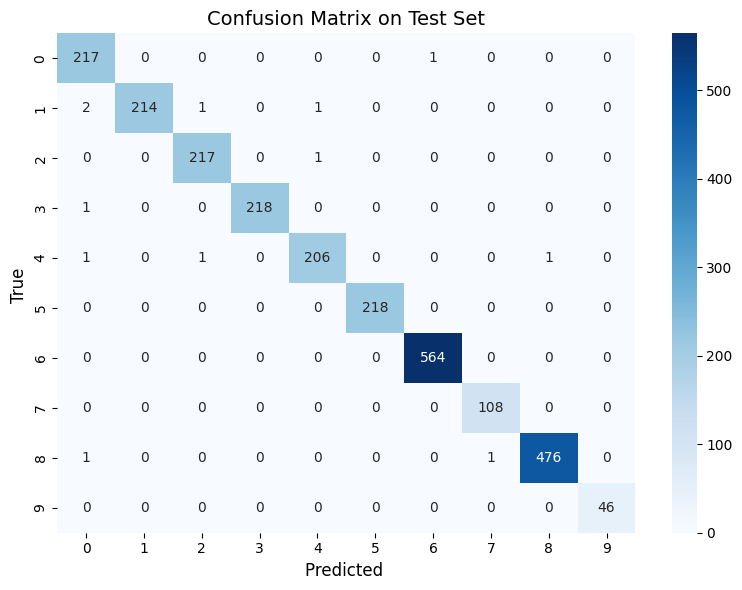

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Save classification report
report_dict = classification_report(all_labels, all_preds, output_dict=True)
pd.DataFrame(report_dict).transpose().to_csv("final_test_classification_report.csv")

# Compute and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title("Confusion Matrix on Test Set", fontsize=14)
plt.xlabel("Predicted ", fontsize=12)
plt.ylabel("True ", fontsize=12)
plt.tight_layout()
plt.show()

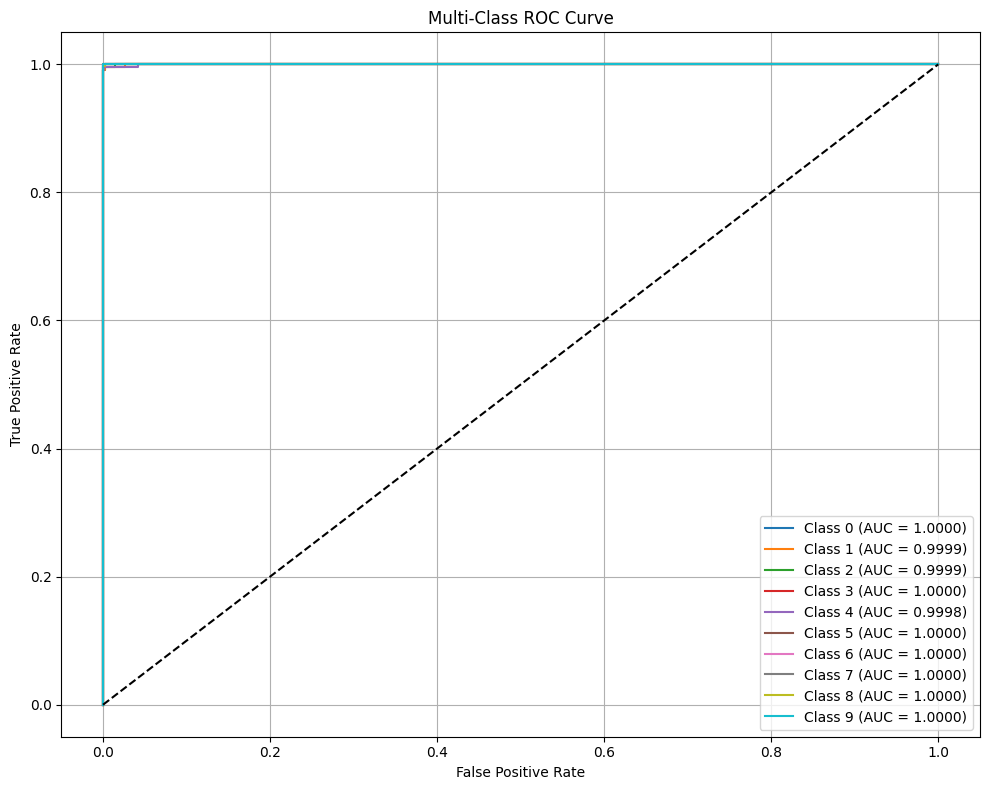

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Step 1: Binarize the labels for ROC computation
y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))  # shape (N, C)

# Step 2: Get softmax probabilities from model
y_scores = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        y_scores.extend(probs.cpu().numpy())
y_scores = np.array(y_scores)

# Step 3: Plot ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


# ResNet - 50 

In [13]:
def get_resnet50_bundle(num_classes=10, lr=1e-4, weight_decay=1e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_timm_model("resnet50", num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    return model, device, criterion, optimizer


In [14]:
from torch.amp import autocast, GradScaler
from sklearn.metrics import f1_score
import torch
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=None):
    scaler = GradScaler()
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_f1_macro': [], 'val_classwise_f1': []
    }
    best_val_f1 = 0.0
    best_model_path = f"best_model_fold{fold+1}.pth" if fold is not None else "best_model.pth"

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=True):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            with autocast("cuda"):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == y_batch).item()

        train_loss /= len(train_loader.dataset)
        train_acc = 100. * train_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        all_preds, all_labels = [], []

        for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=True):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            with torch.no_grad(), autocast("cuda"):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == y_batch).item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        class_f1 = f1_score(all_labels, all_preds, average=None)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1_macro'].append(macro_f1)
        history['val_classwise_f1'].append(class_f1)

        if macro_f1 > best_val_f1:
            best_val_f1 = macro_f1
            torch.save(model.state_dict(), best_model_path)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
              f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, Val F1-Macro={macro_f1:.4f}")

    return history


In [15]:
from torch.utils.data import WeightedRandomSampler, DataLoader
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tqdm import tqdm

# Initialize CV history dictionary
cv_history = {
    'train_acc': [], 'val_acc': [],
    'train_loss': [], 'val_loss': [],
    'val_f1_macro': [], 'val_classwise_f1': []
}

# Loop over folds
for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
    print(f"\n--- Fold {fold + 1} ---")

    # Prepare train/val data
    X_train = [X_trainval[i] for i in train_idx]
    y_train = [y_trainval[i] for i in train_idx]
    X_val = [X_trainval[i] for i in val_idx]
    y_val = [y_trainval[i] for i in val_idx]

    # Weighted sampler to handle class imbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
    sample_weights = [weight_map[y] for y in y_train]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    # DataLoaders with appropriate transforms
    train_dataset = STFTSingleChannelDataset(X_train, y_train, transform=transform)
    val_dataset = STFTSingleChannelDataset(X_val, y_val, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

    # Load model + training components
    model, device, criterion, optimizer = get_resnet50_bundle(num_classes=10, lr=1e-4, weight_decay=1e-5)

    # Train model on this fold
    history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=fold)

    # Store metrics from the last epoch of this fold
    cv_history['train_acc'].append(history['train_acc'][-1])
    cv_history['val_acc'].append(history['val_acc'][-1])
    cv_history['train_loss'].append(history['train_loss'][-1])
    cv_history['val_loss'].append(history['val_loss'][-1])
    cv_history['val_f1_macro'].append(history['val_f1_macro'][-1])
    cv_history['val_classwise_f1'].append(history['val_classwise_f1'][-1])



--- Fold 1 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 51.60it/s]


Epoch 1: Train Loss=1.7916, Val Loss=1.2471, Train Acc=41.26%, Val Acc=60.46%, Val F1-Macro=0.6125


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 54.03it/s]


Epoch 2: Train Loss=0.6769, Val Loss=0.4305, Train Acc=80.14%, Val Acc=86.29%, Val F1-Macro=0.8713


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 54.07it/s]


Epoch 3: Train Loss=0.2398, Val Loss=0.1796, Train Acc=93.75%, Val Acc=95.20%, Val F1-Macro=0.9519


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.84it/s]


Epoch 4: Train Loss=0.1291, Val Loss=0.1200, Train Acc=96.47%, Val Acc=96.10%, Val F1-Macro=0.9632


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 54.03it/s]


Epoch 5: Train Loss=0.0731, Val Loss=0.1003, Train Acc=98.07%, Val Acc=97.50%, Val F1-Macro=0.9748


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 54.08it/s]


Epoch 6: Train Loss=0.0492, Val Loss=0.0539, Train Acc=98.82%, Val Acc=98.40%, Val F1-Macro=0.9863


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.70it/s]


Epoch 7: Train Loss=0.0392, Val Loss=0.0495, Train Acc=98.91%, Val Acc=98.40%, Val F1-Macro=0.9845


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.87it/s]


Epoch 8: Train Loss=0.0312, Val Loss=0.0660, Train Acc=99.15%, Val Acc=98.00%, Val F1-Macro=0.9807


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.41it/s]


Epoch 9: Train Loss=0.0301, Val Loss=0.0416, Train Acc=99.20%, Val Acc=98.60%, Val F1-Macro=0.9860


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.74it/s]


Epoch 10: Train Loss=0.0225, Val Loss=0.0444, Train Acc=99.39%, Val Acc=98.60%, Val F1-Macro=0.9838

--- Fold 2 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.62it/s]


Epoch 1: Train Loss=1.7611, Val Loss=1.1005, Train Acc=42.19%, Val Acc=61.96%, Val F1-Macro=0.6228


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.78it/s]


Epoch 2: Train Loss=0.5978, Val Loss=0.4049, Train Acc=82.30%, Val Acc=87.59%, Val F1-Macro=0.8781


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.60it/s]


Epoch 3: Train Loss=0.2059, Val Loss=0.1956, Train Acc=94.16%, Val Acc=93.69%, Val F1-Macro=0.9387


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.57it/s]


Epoch 4: Train Loss=0.1107, Val Loss=0.1185, Train Acc=97.14%, Val Acc=95.20%, Val F1-Macro=0.9524


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 54.01it/s]


Epoch 5: Train Loss=0.0828, Val Loss=0.0923, Train Acc=97.65%, Val Acc=97.30%, Val F1-Macro=0.9669


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.47it/s]


Epoch 6: Train Loss=0.0602, Val Loss=0.0583, Train Acc=98.34%, Val Acc=98.10%, Val F1-Macro=0.9795


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.62it/s]


Epoch 7: Train Loss=0.0496, Val Loss=0.0532, Train Acc=98.58%, Val Acc=98.20%, Val F1-Macro=0.9801


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.71it/s]


Epoch 8: Train Loss=0.0330, Val Loss=0.0430, Train Acc=99.04%, Val Acc=98.30%, Val F1-Macro=0.9833


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.46it/s]


Epoch 9: Train Loss=0.0286, Val Loss=0.0430, Train Acc=99.15%, Val Acc=98.40%, Val F1-Macro=0.9847


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.68it/s]


Epoch 10: Train Loss=0.0272, Val Loss=0.0543, Train Acc=99.20%, Val Acc=98.20%, Val F1-Macro=0.9806

--- Fold 3 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.93it/s]


Epoch 1: Train Loss=1.7584, Val Loss=1.2542, Train Acc=42.47%, Val Acc=59.06%, Val F1-Macro=0.6012


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.42it/s]


Epoch 2: Train Loss=0.6005, Val Loss=0.5375, Train Acc=82.38%, Val Acc=81.88%, Val F1-Macro=0.8274


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 54.18it/s]


Epoch 3: Train Loss=0.2238, Val Loss=0.1579, Train Acc=94.13%, Val Acc=95.60%, Val F1-Macro=0.9564


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.45it/s]


Epoch 4: Train Loss=0.1064, Val Loss=0.1060, Train Acc=97.27%, Val Acc=95.80%, Val F1-Macro=0.9614


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.72it/s]


Epoch 5: Train Loss=0.0738, Val Loss=0.0862, Train Acc=97.90%, Val Acc=97.00%, Val F1-Macro=0.9699


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.61it/s]


Epoch 6: Train Loss=0.0515, Val Loss=0.0477, Train Acc=98.68%, Val Acc=98.20%, Val F1-Macro=0.9832


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 54.04it/s]


Epoch 7: Train Loss=0.0395, Val Loss=0.0933, Train Acc=98.86%, Val Acc=97.10%, Val F1-Macro=0.9669


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.72it/s]


Epoch 8: Train Loss=0.0348, Val Loss=0.0442, Train Acc=99.01%, Val Acc=98.30%, Val F1-Macro=0.9836


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.74it/s]


Epoch 9: Train Loss=0.0302, Val Loss=0.1300, Train Acc=99.19%, Val Acc=95.10%, Val F1-Macro=0.9512


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.48it/s]


Epoch 10: Train Loss=0.0263, Val Loss=0.0553, Train Acc=99.30%, Val Acc=98.40%, Val F1-Macro=0.9853

--- Fold 4 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.32it/s]


Epoch 1: Train Loss=1.7864, Val Loss=1.2058, Train Acc=41.61%, Val Acc=63.66%, Val F1-Macro=0.6532


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.93it/s]


Epoch 2: Train Loss=0.6706, Val Loss=0.4622, Train Acc=79.67%, Val Acc=85.49%, Val F1-Macro=0.8622


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.64it/s]


Epoch 3: Train Loss=0.2707, Val Loss=0.1552, Train Acc=92.31%, Val Acc=95.80%, Val F1-Macro=0.9577


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.50it/s]


Epoch 4: Train Loss=0.1361, Val Loss=0.1174, Train Acc=96.22%, Val Acc=97.10%, Val F1-Macro=0.9661


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.53it/s]


Epoch 5: Train Loss=0.0864, Val Loss=0.0879, Train Acc=97.73%, Val Acc=97.00%, Val F1-Macro=0.9665


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.46it/s]


Epoch 6: Train Loss=0.0653, Val Loss=0.1018, Train Acc=98.20%, Val Acc=96.50%, Val F1-Macro=0.9543


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.73it/s]


Epoch 7: Train Loss=0.0403, Val Loss=0.0624, Train Acc=98.94%, Val Acc=97.80%, Val F1-Macro=0.9701


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.72it/s]


Epoch 8: Train Loss=0.0415, Val Loss=0.0470, Train Acc=98.85%, Val Acc=98.50%, Val F1-Macro=0.9823


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.88it/s]


Epoch 9: Train Loss=0.0292, Val Loss=0.0449, Train Acc=99.21%, Val Acc=98.40%, Val F1-Macro=0.9810


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.67it/s]


Epoch 10: Train Loss=0.0340, Val Loss=0.0343, Train Acc=99.02%, Val Acc=98.60%, Val F1-Macro=0.9827

--- Fold 5 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 52.66it/s]


Epoch 1: Train Loss=1.7608, Val Loss=1.4144, Train Acc=42.51%, Val Acc=49.20%, Val F1-Macro=0.5143


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.73it/s]


Epoch 2: Train Loss=0.5960, Val Loss=0.4380, Train Acc=81.56%, Val Acc=86.77%, Val F1-Macro=0.8578


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.40it/s]


Epoch 3: Train Loss=0.2192, Val Loss=0.1796, Train Acc=93.90%, Val Acc=94.49%, Val F1-Macro=0.9498


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.39it/s]


Epoch 4: Train Loss=0.1093, Val Loss=0.1102, Train Acc=97.18%, Val Acc=96.29%, Val F1-Macro=0.9671


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.52it/s]


Epoch 5: Train Loss=0.0812, Val Loss=0.0922, Train Acc=97.70%, Val Acc=97.09%, Val F1-Macro=0.9731


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.63it/s]


Epoch 6: Train Loss=0.0464, Val Loss=0.0495, Train Acc=98.81%, Val Acc=98.50%, Val F1-Macro=0.9859


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.31it/s]


Epoch 7: Train Loss=0.0444, Val Loss=0.0504, Train Acc=98.66%, Val Acc=98.40%, Val F1-Macro=0.9857


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.66it/s]


Epoch 8: Train Loss=0.0312, Val Loss=0.0508, Train Acc=99.11%, Val Acc=98.40%, Val F1-Macro=0.9859


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.58it/s]


Epoch 9: Train Loss=0.0250, Val Loss=0.0133, Train Acc=99.24%, Val Acc=99.60%, Val F1-Macro=0.9965


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.37it/s]


Epoch 10: Train Loss=0.0307, Val Loss=0.0312, Train Acc=99.12%, Val Acc=98.90%, Val F1-Macro=0.9895

--- Fold 6 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.66it/s]


Epoch 1: Train Loss=1.7499, Val Loss=1.1867, Train Acc=42.66%, Val Acc=60.82%, Val F1-Macro=0.6316


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 52.33it/s]


Epoch 2: Train Loss=0.5912, Val Loss=0.3543, Train Acc=82.39%, Val Acc=89.18%, Val F1-Macro=0.9037


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.61it/s]


Epoch 3: Train Loss=0.2178, Val Loss=0.1374, Train Acc=93.69%, Val Acc=95.89%, Val F1-Macro=0.9554


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.55it/s]


Epoch 4: Train Loss=0.1067, Val Loss=0.0785, Train Acc=97.07%, Val Acc=97.80%, Val F1-Macro=0.9718


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.58it/s]


Epoch 5: Train Loss=0.0725, Val Loss=0.0692, Train Acc=98.04%, Val Acc=98.10%, Val F1-Macro=0.9810


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.80it/s]


Epoch 6: Train Loss=0.0569, Val Loss=0.0675, Train Acc=98.49%, Val Acc=97.60%, Val F1-Macro=0.9738


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.33it/s]


Epoch 7: Train Loss=0.0440, Val Loss=0.0592, Train Acc=98.63%, Val Acc=98.10%, Val F1-Macro=0.9787


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.77it/s]


Epoch 8: Train Loss=0.0337, Val Loss=0.0721, Train Acc=99.13%, Val Acc=97.90%, Val F1-Macro=0.9740


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.54it/s]


Epoch 9: Train Loss=0.0331, Val Loss=0.0569, Train Acc=99.05%, Val Acc=98.00%, Val F1-Macro=0.9756


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 52.99it/s]


Epoch 10: Train Loss=0.0221, Val Loss=0.0543, Train Acc=99.40%, Val Acc=98.10%, Val F1-Macro=0.9758

--- Fold 7 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.54it/s]


Epoch 1: Train Loss=1.7672, Val Loss=1.1639, Train Acc=42.21%, Val Acc=58.92%, Val F1-Macro=0.6030


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.54it/s]


Epoch 2: Train Loss=0.6168, Val Loss=0.3726, Train Acc=81.67%, Val Acc=89.38%, Val F1-Macro=0.9005


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.54it/s]


Epoch 3: Train Loss=0.2456, Val Loss=0.1568, Train Acc=92.96%, Val Acc=96.19%, Val F1-Macro=0.9622


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.31it/s]


Epoch 4: Train Loss=0.1266, Val Loss=0.1001, Train Acc=96.38%, Val Acc=97.09%, Val F1-Macro=0.9720


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.90it/s]


Epoch 5: Train Loss=0.0798, Val Loss=0.0587, Train Acc=97.85%, Val Acc=98.30%, Val F1-Macro=0.9848


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.63it/s]


Epoch 6: Train Loss=0.0572, Val Loss=0.0676, Train Acc=98.52%, Val Acc=97.90%, Val F1-Macro=0.9800


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.90it/s]


Epoch 7: Train Loss=0.0420, Val Loss=0.0631, Train Acc=98.89%, Val Acc=97.80%, Val F1-Macro=0.9764


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.34it/s]


Epoch 8: Train Loss=0.0396, Val Loss=0.0364, Train Acc=98.89%, Val Acc=99.20%, Val F1-Macro=0.9925


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.66it/s]


Epoch 9: Train Loss=0.0314, Val Loss=0.0420, Train Acc=99.10%, Val Acc=99.20%, Val F1-Macro=0.9898


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.53it/s]


Epoch 10: Train Loss=0.0248, Val Loss=0.0428, Train Acc=99.42%, Val Acc=98.60%, Val F1-Macro=0.9872

--- Fold 8 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.32it/s]


Epoch 1: Train Loss=1.7873, Val Loss=1.1922, Train Acc=41.80%, Val Acc=63.53%, Val F1-Macro=0.6430


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.37it/s]


Epoch 2: Train Loss=0.5954, Val Loss=0.3139, Train Acc=82.58%, Val Acc=90.38%, Val F1-Macro=0.9163


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.09it/s]


Epoch 3: Train Loss=0.2407, Val Loss=0.1356, Train Acc=93.40%, Val Acc=95.79%, Val F1-Macro=0.9645


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.39it/s]


Epoch 4: Train Loss=0.1153, Val Loss=0.1395, Train Acc=97.00%, Val Acc=95.69%, Val F1-Macro=0.9608


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.18it/s]


Epoch 5: Train Loss=0.0824, Val Loss=0.0528, Train Acc=97.75%, Val Acc=98.40%, Val F1-Macro=0.9849


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.47it/s]


Epoch 6: Train Loss=0.0602, Val Loss=0.0444, Train Acc=98.35%, Val Acc=98.50%, Val F1-Macro=0.9860


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.33it/s]


Epoch 7: Train Loss=0.0451, Val Loss=0.0390, Train Acc=98.82%, Val Acc=98.50%, Val F1-Macro=0.9860


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.35it/s]


Epoch 8: Train Loss=0.0361, Val Loss=0.0539, Train Acc=98.94%, Val Acc=98.40%, Val F1-Macro=0.9851


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.23it/s]


Epoch 9: Train Loss=0.0283, Val Loss=0.0438, Train Acc=99.23%, Val Acc=98.80%, Val F1-Macro=0.9880


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.43it/s]


Epoch 10: Train Loss=0.0297, Val Loss=0.0351, Train Acc=99.22%, Val Acc=98.70%, Val F1-Macro=0.9872

--- Fold 9 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.55it/s]


Epoch 1: Train Loss=1.8087, Val Loss=1.2244, Train Acc=41.68%, Val Acc=57.52%, Val F1-Macro=0.5951


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.33it/s]


Epoch 2: Train Loss=0.6383, Val Loss=0.4356, Train Acc=81.01%, Val Acc=85.67%, Val F1-Macro=0.8707


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.00it/s]


Epoch 3: Train Loss=0.2593, Val Loss=0.1942, Train Acc=92.77%, Val Acc=94.19%, Val F1-Macro=0.9381


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.13it/s]


Epoch 4: Train Loss=0.1356, Val Loss=0.1389, Train Acc=96.08%, Val Acc=95.99%, Val F1-Macro=0.9575


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.42it/s]


Epoch 5: Train Loss=0.0849, Val Loss=0.1167, Train Acc=97.66%, Val Acc=96.29%, Val F1-Macro=0.9615


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.54it/s]


Epoch 6: Train Loss=0.0565, Val Loss=0.0869, Train Acc=98.51%, Val Acc=97.29%, Val F1-Macro=0.9676


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.61it/s]


Epoch 7: Train Loss=0.0481, Val Loss=0.0810, Train Acc=98.62%, Val Acc=97.39%, Val F1-Macro=0.9681


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.07it/s]


Epoch 8: Train Loss=0.0388, Val Loss=0.0662, Train Acc=98.98%, Val Acc=98.00%, Val F1-Macro=0.9742


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.07it/s]


Epoch 9: Train Loss=0.0234, Val Loss=0.0786, Train Acc=99.31%, Val Acc=97.90%, Val F1-Macro=0.9729


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.49it/s]


Epoch 10: Train Loss=0.0357, Val Loss=0.0865, Train Acc=98.89%, Val Acc=97.70%, Val F1-Macro=0.9774

--- Fold 10 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.03it/s]


Epoch 1: Train Loss=1.7620, Val Loss=1.2316, Train Acc=41.79%, Val Acc=61.32%, Val F1-Macro=0.6545


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.53it/s]


Epoch 2: Train Loss=0.5859, Val Loss=0.3265, Train Acc=82.39%, Val Acc=91.08%, Val F1-Macro=0.9249


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.45it/s]


Epoch 3: Train Loss=0.2124, Val Loss=0.1400, Train Acc=94.07%, Val Acc=96.19%, Val F1-Macro=0.9659


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.37it/s]


Epoch 4: Train Loss=0.1114, Val Loss=0.0741, Train Acc=96.95%, Val Acc=98.20%, Val F1-Macro=0.9825


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.28it/s]


Epoch 5: Train Loss=0.0828, Val Loss=0.0840, Train Acc=97.69%, Val Acc=97.19%, Val F1-Macro=0.9741


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.31it/s]


Epoch 6: Train Loss=0.0559, Val Loss=0.0779, Train Acc=98.50%, Val Acc=97.70%, Val F1-Macro=0.9787


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.24it/s]


Epoch 7: Train Loss=0.0426, Val Loss=0.0362, Train Acc=98.85%, Val Acc=98.60%, Val F1-Macro=0.9879


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.23it/s]


Epoch 8: Train Loss=0.0344, Val Loss=0.0436, Train Acc=99.12%, Val Acc=98.60%, Val F1-Macro=0.9875


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.27it/s]


Epoch 9: Train Loss=0.0314, Val Loss=0.0408, Train Acc=99.17%, Val Acc=98.90%, Val F1-Macro=0.9897


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 53.09it/s]


Epoch 10: Train Loss=0.0212, Val Loss=0.0221, Train Acc=99.34%, Val Acc=99.30%, Val F1-Macro=0.9944


In [16]:
import pandas as pd

# Create a DataFrame from cv_history
fold_summary = pd.DataFrame({
    "Fold": [f"Fold {i+1}" for i in range(len(cv_history['train_acc']))],
    "Train Accuracy (%)": cv_history['train_acc'],
    "Val Accuracy (%)": cv_history['val_acc'],
    "Train Loss": cv_history['train_loss'],
    "Val Loss": cv_history['val_loss'],
    "Val Macro F1": cv_history['val_f1_macro']
})

# Round values to 4 decimals
fold_summary = fold_summary.round(4)

# Print neatly
print("\n=== Per-Fold Summary ===")
print(fold_summary)

# Optionally save it
fold_summary.to_csv("cv_fold_summary.csv", index=False)



=== Per-Fold Summary ===
      Fold  Train Accuracy (%)  Val Accuracy (%)  Train Loss  Val Loss  \
0   Fold 1             99.3879           98.5986      0.0225    0.0444   
1   Fold 2             99.1987           98.1982      0.0272    0.0543   
2   Fold 3             99.2988           98.3984      0.0263    0.0553   
3   Fold 4             99.0206           98.5986      0.0340    0.0343   
4   Fold 5             99.1209           98.8978      0.0307    0.0312   
5   Fold 6             99.3991           98.0962      0.0221    0.0543   
6   Fold 7             99.4213           98.5972      0.0248    0.0428   
7   Fold 8             99.2210           98.6974      0.0297    0.0351   
8   Fold 9             98.8872           97.6954      0.0357    0.0865   
9  Fold 10             99.3434           99.2986      0.0212    0.0221   

   Val Macro F1  
0        0.9838  
1        0.9806  
2        0.9853  
3        0.9827  
4        0.9895  
5        0.9758  
6        0.9872  
7        0.9872

In [17]:
num_classes = 10
best_fold = np.argmax(cv_history['val_f1_macro'])

# ✅ Only get the model
model = get_resnet50_bundle(num_classes)[0]  # Unpack only the model
model.load_state_dict(torch.load(f"best_model_fold{best_fold+1}.pth"))
model = model.to(device)
model.eval()

# Predict
all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

acc = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average='macro')
report = classification_report(all_labels, all_preds, digits=4, labels=range(num_classes))
cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))

print("\n=== Final Test Set Evaluation ===")
print(f"Accuracy       : {acc:.4f}")
print(f"Macro F1-score : {macro_f1:.4f}")
print("\nClassification Report:\n", report)



=== Final Test Set Evaluation ===
Accuracy       : 0.9912
Macro F1-score : 0.9900

Classification Report:
               precision    recall  f1-score   support

           0     0.9862    0.9817    0.9839       218
           1     0.9908    0.9862    0.9885       218
           2     0.9907    0.9817    0.9862       218
           3     0.9954    0.9954    0.9954       219
           4     0.9903    0.9809    0.9856       209
           5     1.0000    1.0000    1.0000       218
           6     0.9877    0.9947    0.9912       564
           7     0.9908    1.0000    0.9954       108
           8     0.9958    0.9937    0.9948       478
           9     0.9583    1.0000    0.9787        46

    accuracy                         0.9912      2496
   macro avg     0.9886    0.9914    0.9900      2496
weighted avg     0.9912    0.9912    0.9912      2496



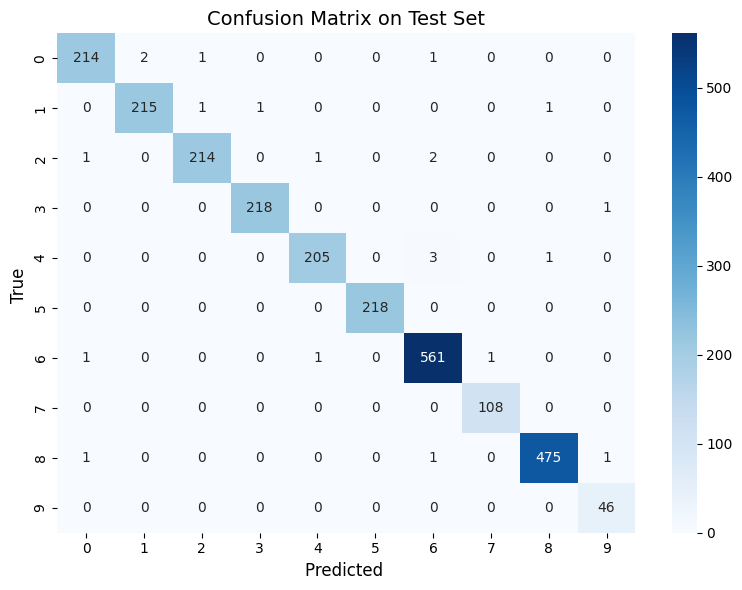

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Save classification report
report_dict = classification_report(all_labels, all_preds, output_dict=True)
pd.DataFrame(report_dict).transpose().to_csv("final_test_classification_report.csv")

# Compute and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title("Confusion Matrix on Test Set", fontsize=14)
plt.xlabel("Predicted ", fontsize=12)
plt.ylabel("True ", fontsize=12)
plt.tight_layout()
plt.show()

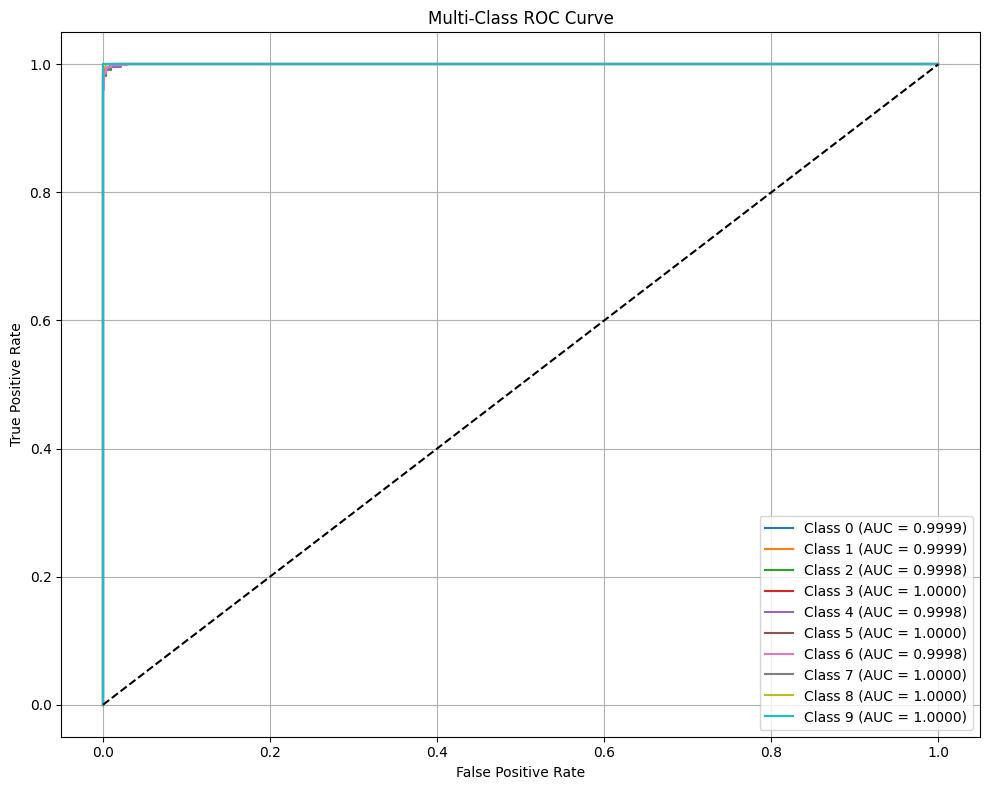

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Step 1: Binarize the labels for ROC computation
y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))  # shape (N, C)

# Step 2: Get softmax probabilities from model
y_scores = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        y_scores.extend(probs.cpu().numpy())
y_scores = np.array(y_scores)

# Step 3: Plot ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


## InceptionNet- ResNet V2

In [ ]:
def get_timm_model(model_name, num_classes):
    model = timm.create_model(model_name, pretrained=True, in_chans=1)

    if hasattr(model, 'fc'):
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'classifier'):
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'head'):
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'classif'):  # ✅ Fix for Inception-ResNet V2
        in_features = model.classif.in_features
        model.classif = nn.Linear(in_features, num_classes)
    else:
        raise ValueError(f"Unknown classifier structure for model: {model_name}")

    return model


In [132]:
def get_inception_resnetv2_bundle(num_classes=10, lr=1e-4, weight_decay=1e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_timm_model("inception_resnet_v2", num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    return model, device, criterion, optimizer


In [133]:
from torch.amp import autocast, GradScaler
from sklearn.metrics import f1_score
import torch
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=None):
    scaler = GradScaler()
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_f1_macro': [], 'val_classwise_f1': []
    }
    best_val_f1 = 0.0
    best_model_path = f"best_model_fold{fold+1}.pth" if fold is not None else "best_model.pth"

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=True):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            with autocast("cuda"):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == y_batch).item()

        train_loss /= len(train_loader.dataset)
        train_acc = 100. * train_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        all_preds, all_labels = [], []

        for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=True):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            with torch.no_grad(), autocast("cuda"):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == y_batch).item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        class_f1 = f1_score(all_labels, all_preds, average=None)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1_macro'].append(macro_f1)
        history['val_classwise_f1'].append(class_f1)

        if macro_f1 > best_val_f1:
            best_val_f1 = macro_f1
            torch.save(model.state_dict(), best_model_path)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
              f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, Val F1-Macro={macro_f1:.4f}")

    return history


In [134]:

# Initialize CV history dictionary
cv_history = {
    'train_acc': [], 'val_acc': [],
    'train_loss': [], 'val_loss': [],
    'val_f1_macro': [], 'val_classwise_f1': []
}

# Loop over folds
for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
    print(f"\n--- Fold {fold + 1} ---")

    # Prepare train/val data
    X_train = [X_trainval[i] for i in train_idx]
    y_train = [y_trainval[i] for i in train_idx]
    X_val = [X_trainval[i] for i in val_idx]
    y_val = [y_trainval[i] for i in val_idx]

    # Weighted sampler to handle class imbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
    sample_weights = [weight_map[y] for y in y_train]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    # DataLoaders with appropriate transforms
    train_dataset = STFTSingleChannelDataset(X_train, y_train, transform=transform)
    val_dataset = STFTSingleChannelDataset(X_val, y_val, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

    # Load model + training components
    model, device, criterion, optimizer = get_inception_resnetv2_bundle(num_classes=10, lr=1e-4, weight_decay=1e-5)

    # Train model on this fold
    history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=fold)

    # Store metrics from the last epoch of this fold
    cv_history['train_acc'].append(history['train_acc'][-1])
    cv_history['val_acc'].append(history['val_acc'][-1])
    cv_history['train_loss'].append(history['train_loss'][-1])
    cv_history['val_loss'].append(history['val_loss'][-1])
    cv_history['val_f1_macro'].append(history['val_f1_macro'][-1])
    cv_history['val_classwise_f1'].append(history['val_classwise_f1'][-1])



--- Fold 1 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.15it/s]


Epoch 1: Train Loss=0.5522, Val Loss=0.1375, Train Acc=82.15%, Val Acc=95.70%, Val F1-Macro=0.9617


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.31it/s]


Epoch 2: Train Loss=0.0875, Val Loss=0.0850, Train Acc=97.46%, Val Acc=98.30%, Val F1-Macro=0.9855


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.24it/s]


Epoch 3: Train Loss=0.0495, Val Loss=0.0536, Train Acc=98.78%, Val Acc=98.30%, Val F1-Macro=0.9843


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.33it/s]


Epoch 4: Train Loss=0.0332, Val Loss=0.0294, Train Acc=99.15%, Val Acc=99.00%, Val F1-Macro=0.9919


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.33it/s]


Epoch 5: Train Loss=0.0326, Val Loss=0.0610, Train Acc=99.14%, Val Acc=98.20%, Val F1-Macro=0.9842


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.27it/s]


Epoch 6: Train Loss=0.0360, Val Loss=0.0596, Train Acc=99.03%, Val Acc=98.50%, Val F1-Macro=0.9858


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.26it/s]


Epoch 7: Train Loss=0.0150, Val Loss=0.0181, Train Acc=99.65%, Val Acc=99.60%, Val F1-Macro=0.9961


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.25it/s]


Epoch 8: Train Loss=0.0160, Val Loss=0.0361, Train Acc=99.54%, Val Acc=99.20%, Val F1-Macro=0.9945


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.21it/s]


Epoch 9: Train Loss=0.0251, Val Loss=0.0236, Train Acc=99.29%, Val Acc=99.10%, Val F1-Macro=0.9920


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.26it/s]


Epoch 10: Train Loss=0.0177, Val Loss=0.0130, Train Acc=99.58%, Val Acc=99.60%, Val F1-Macro=0.9961

--- Fold 2 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.22it/s]


Epoch 1: Train Loss=0.5500, Val Loss=0.1895, Train Acc=82.49%, Val Acc=93.79%, Val F1-Macro=0.9483


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.18it/s]


Epoch 2: Train Loss=0.0946, Val Loss=0.0449, Train Acc=97.36%, Val Acc=99.10%, Val F1-Macro=0.9928


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.24it/s]


Epoch 3: Train Loss=0.0478, Val Loss=0.0234, Train Acc=98.69%, Val Acc=99.50%, Val F1-Macro=0.9969


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.17it/s]


Epoch 4: Train Loss=0.0353, Val Loss=0.0579, Train Acc=98.90%, Val Acc=97.60%, Val F1-Macro=0.9765


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.22it/s]


Epoch 5: Train Loss=0.0276, Val Loss=0.0303, Train Acc=99.21%, Val Acc=99.00%, Val F1-Macro=0.9904


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.21it/s]


Epoch 6: Train Loss=0.0277, Val Loss=0.1288, Train Acc=99.17%, Val Acc=99.70%, Val F1-Macro=0.9979


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.24it/s]


Epoch 7: Train Loss=0.0195, Val Loss=0.0314, Train Acc=99.55%, Val Acc=99.40%, Val F1-Macro=0.9926


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.23it/s]


Epoch 8: Train Loss=0.0214, Val Loss=0.0184, Train Acc=99.40%, Val Acc=99.60%, Val F1-Macro=0.9939


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.15it/s]


Epoch 9: Train Loss=0.0281, Val Loss=0.0294, Train Acc=99.19%, Val Acc=99.40%, Val F1-Macro=0.9916


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.21it/s]


Epoch 10: Train Loss=0.0141, Val Loss=0.0200, Train Acc=99.62%, Val Acc=99.50%, Val F1-Macro=0.9928

--- Fold 3 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.17it/s]


Epoch 1: Train Loss=0.6043, Val Loss=nan, Train Acc=80.12%, Val Acc=93.39%, Val F1-Macro=0.9489


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.22it/s]


Epoch 2: Train Loss=0.0766, Val Loss=nan, Train Acc=97.95%, Val Acc=98.60%, Val F1-Macro=0.9870


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.20it/s]


Epoch 3: Train Loss=0.0484, Val Loss=nan, Train Acc=98.69%, Val Acc=96.80%, Val F1-Macro=0.9647


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.27it/s]


Epoch 4: Train Loss=0.0300, Val Loss=0.3721, Train Acc=99.33%, Val Acc=99.50%, Val F1-Macro=0.9956


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.23it/s]


Epoch 5: Train Loss=0.0338, Val Loss=0.8908, Train Acc=99.01%, Val Acc=98.30%, Val F1-Macro=0.9879


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.18it/s]


Epoch 6: Train Loss=0.0235, Val Loss=nan, Train Acc=99.42%, Val Acc=98.70%, Val F1-Macro=0.9883


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.17it/s]


Epoch 7: Train Loss=0.0228, Val Loss=0.2495, Train Acc=99.37%, Val Acc=98.20%, Val F1-Macro=0.9778


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.18it/s]


Epoch 8: Train Loss=0.0258, Val Loss=0.5858, Train Acc=99.33%, Val Acc=97.90%, Val F1-Macro=0.9850


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.20it/s]


Epoch 9: Train Loss=0.0100, Val Loss=0.5287, Train Acc=99.73%, Val Acc=98.40%, Val F1-Macro=0.9851


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.19it/s]


Epoch 10: Train Loss=0.0224, Val Loss=0.5479, Train Acc=99.45%, Val Acc=97.20%, Val F1-Macro=0.9771

--- Fold 4 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.25it/s]


Epoch 1: Train Loss=0.5613, Val Loss=nan, Train Acc=81.88%, Val Acc=95.30%, Val F1-Macro=0.9578


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.18it/s]


Epoch 2: Train Loss=0.0884, Val Loss=nan, Train Acc=97.33%, Val Acc=98.10%, Val F1-Macro=0.9835


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.19it/s]


Epoch 3: Train Loss=0.0531, Val Loss=nan, Train Acc=98.45%, Val Acc=99.10%, Val F1-Macro=0.9924


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.20it/s]


Epoch 4: Train Loss=0.0381, Val Loss=0.0674, Train Acc=98.98%, Val Acc=97.80%, Val F1-Macro=0.9767


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.19it/s]


Epoch 5: Train Loss=0.0310, Val Loss=0.0217, Train Acc=99.12%, Val Acc=99.40%, Val F1-Macro=0.9947


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.24it/s]


Epoch 6: Train Loss=0.0235, Val Loss=0.0939, Train Acc=99.43%, Val Acc=98.20%, Val F1-Macro=0.9805


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.23it/s]


Epoch 7: Train Loss=0.0237, Val Loss=0.1349, Train Acc=99.30%, Val Acc=96.80%, Val F1-Macro=0.9664


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.26it/s]


Epoch 8: Train Loss=0.0241, Val Loss=0.3497, Train Acc=99.30%, Val Acc=98.40%, Val F1-Macro=0.9846


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.25it/s]


Epoch 9: Train Loss=0.0177, Val Loss=0.5144, Train Acc=99.57%, Val Acc=99.10%, Val F1-Macro=0.9916


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.23it/s]


Epoch 10: Train Loss=0.0231, Val Loss=0.1455, Train Acc=99.33%, Val Acc=99.70%, Val F1-Macro=0.9979

--- Fold 5 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:03<00:00, 21.00it/s]


Epoch 1: Train Loss=0.5889, Val Loss=0.2856, Train Acc=80.76%, Val Acc=93.79%, Val F1-Macro=0.9438


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.20it/s]


Epoch 2: Train Loss=0.0804, Val Loss=0.1113, Train Acc=97.84%, Val Acc=96.69%, Val F1-Macro=0.9698


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.23it/s]


Epoch 3: Train Loss=0.0536, Val Loss=0.0439, Train Acc=98.46%, Val Acc=98.50%, Val F1-Macro=0.9885


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.21it/s]


Epoch 4: Train Loss=0.0410, Val Loss=0.0350, Train Acc=98.97%, Val Acc=99.10%, Val F1-Macro=0.9918


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.21it/s]


Epoch 5: Train Loss=0.0172, Val Loss=0.0239, Train Acc=99.62%, Val Acc=99.20%, Val F1-Macro=0.9948


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.22it/s]


Epoch 6: Train Loss=0.0253, Val Loss=0.0306, Train Acc=99.39%, Val Acc=99.20%, Val F1-Macro=0.9930


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.30it/s]


Epoch 7: Train Loss=0.0255, Val Loss=0.0275, Train Acc=99.30%, Val Acc=99.10%, Val F1-Macro=0.9916


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.22it/s]


Epoch 8: Train Loss=0.0036, Val Loss=0.0035, Train Acc=99.94%, Val Acc=99.90%, Val F1-Macro=0.9989


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.20it/s]


Epoch 9: Train Loss=0.0293, Val Loss=0.0372, Train Acc=99.33%, Val Acc=98.80%, Val F1-Macro=0.9902


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.23it/s]


Epoch 10: Train Loss=0.0253, Val Loss=0.0706, Train Acc=99.25%, Val Acc=98.20%, Val F1-Macro=0.9790

--- Fold 6 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.26it/s]


Epoch 1: Train Loss=0.5427, Val Loss=0.3774, Train Acc=82.53%, Val Acc=94.69%, Val F1-Macro=0.9507


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.30it/s]


Epoch 2: Train Loss=0.0881, Val Loss=nan, Train Acc=97.66%, Val Acc=98.60%, Val F1-Macro=0.9827


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.17it/s]


Epoch 3: Train Loss=0.0439, Val Loss=nan, Train Acc=98.75%, Val Acc=98.30%, Val F1-Macro=0.9778


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.27it/s]


Epoch 4: Train Loss=0.0341, Val Loss=nan, Train Acc=99.05%, Val Acc=97.90%, Val F1-Macro=0.9753


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.23it/s]


Epoch 5: Train Loss=0.0245, Val Loss=nan, Train Acc=99.40%, Val Acc=96.49%, Val F1-Macro=0.9625


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.21it/s]


Epoch 6: Train Loss=0.0272, Val Loss=0.0425, Train Acc=99.35%, Val Acc=99.10%, Val F1-Macro=0.9868


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.16it/s]


Epoch 7: Train Loss=0.0245, Val Loss=0.0618, Train Acc=99.38%, Val Acc=99.10%, Val F1-Macro=0.9864


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.20it/s]


Epoch 8: Train Loss=0.0284, Val Loss=0.1792, Train Acc=99.11%, Val Acc=98.60%, Val F1-Macro=0.9811


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.22it/s]


Epoch 9: Train Loss=0.0192, Val Loss=0.9693, Train Acc=99.44%, Val Acc=98.10%, Val F1-Macro=0.9713


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.23it/s]


Epoch 10: Train Loss=0.0207, Val Loss=nan, Train Acc=99.51%, Val Acc=98.20%, Val F1-Macro=0.9801

--- Fold 7 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.31it/s]


Epoch 1: Train Loss=0.5504, Val Loss=0.1305, Train Acc=82.18%, Val Acc=96.49%, Val F1-Macro=0.9697


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.21it/s]


Epoch 2: Train Loss=0.0856, Val Loss=0.0652, Train Acc=97.59%, Val Acc=98.30%, Val F1-Macro=0.9840


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.21it/s]


Epoch 3: Train Loss=0.0551, Val Loss=0.0334, Train Acc=98.34%, Val Acc=99.50%, Val F1-Macro=0.9958


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.24it/s]


Epoch 4: Train Loss=0.0316, Val Loss=0.0636, Train Acc=99.20%, Val Acc=98.50%, Val F1-Macro=0.9816


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.20it/s]


Epoch 5: Train Loss=0.0436, Val Loss=0.5940, Train Acc=98.83%, Val Acc=97.09%, Val F1-Macro=0.9681


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.26it/s]


Epoch 6: Train Loss=0.0181, Val Loss=0.0261, Train Acc=99.57%, Val Acc=99.30%, Val F1-Macro=0.9911


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.19it/s]


Epoch 7: Train Loss=0.0179, Val Loss=0.0082, Train Acc=99.54%, Val Acc=99.80%, Val F1-Macro=0.9984


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.36it/s]


Epoch 8: Train Loss=0.0180, Val Loss=0.0403, Train Acc=99.55%, Val Acc=99.00%, Val F1-Macro=0.9904


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.18it/s]


Epoch 9: Train Loss=0.0294, Val Loss=0.0610, Train Acc=99.17%, Val Acc=98.80%, Val F1-Macro=0.9872


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.18it/s]


Epoch 10: Train Loss=0.0123, Val Loss=0.0242, Train Acc=99.67%, Val Acc=99.40%, Val F1-Macro=0.9940

--- Fold 8 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.23it/s]


Epoch 1: Train Loss=0.5860, Val Loss=nan, Train Acc=81.08%, Val Acc=97.19%, Val F1-Macro=0.9727


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.21it/s]


Epoch 2: Train Loss=0.0823, Val Loss=nan, Train Acc=97.69%, Val Acc=99.00%, Val F1-Macro=0.9893


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.19it/s]


Epoch 3: Train Loss=0.0426, Val Loss=nan, Train Acc=98.88%, Val Acc=98.10%, Val F1-Macro=0.9820


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.15it/s]


Epoch 4: Train Loss=0.0466, Val Loss=nan, Train Acc=98.73%, Val Acc=99.50%, Val F1-Macro=0.9926


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.31it/s]


Epoch 5: Train Loss=0.0136, Val Loss=nan, Train Acc=99.70%, Val Acc=99.00%, Val F1-Macro=0.9865


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.28it/s]


Epoch 6: Train Loss=0.0254, Val Loss=0.0273, Train Acc=99.34%, Val Acc=99.20%, Val F1-Macro=0.9929


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.20it/s]


Epoch 7: Train Loss=0.0212, Val Loss=0.0248, Train Acc=99.52%, Val Acc=99.50%, Val F1-Macro=0.9960


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.21it/s]


Epoch 8: Train Loss=0.0271, Val Loss=0.0250, Train Acc=99.30%, Val Acc=99.20%, Val F1-Macro=0.9902


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.19it/s]


Epoch 9: Train Loss=0.0365, Val Loss=0.0225, Train Acc=98.95%, Val Acc=99.30%, Val F1-Macro=0.9949


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.22it/s]


Epoch 10: Train Loss=0.0093, Val Loss=0.0167, Train Acc=99.76%, Val Acc=99.40%, Val F1-Macro=0.9946

--- Fold 9 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.25it/s]


Epoch 1: Train Loss=0.5646, Val Loss=0.1401, Train Acc=81.64%, Val Acc=95.49%, Val F1-Macro=0.9513


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.27it/s]


Epoch 2: Train Loss=0.0885, Val Loss=0.0942, Train Acc=97.57%, Val Acc=98.80%, Val F1-Macro=0.9857


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.19it/s]


Epoch 3: Train Loss=0.0460, Val Loss=0.0689, Train Acc=98.73%, Val Acc=98.00%, Val F1-Macro=0.9770


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.24it/s]


Epoch 4: Train Loss=0.0284, Val Loss=0.0739, Train Acc=99.17%, Val Acc=97.80%, Val F1-Macro=0.9740


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.23it/s]


Epoch 5: Train Loss=0.0312, Val Loss=0.0378, Train Acc=99.11%, Val Acc=98.60%, Val F1-Macro=0.9872


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.28it/s]


Epoch 6: Train Loss=0.0329, Val Loss=0.1149, Train Acc=99.03%, Val Acc=96.39%, Val F1-Macro=0.9603


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.19it/s]


Epoch 7: Train Loss=0.0156, Val Loss=0.0177, Train Acc=99.66%, Val Acc=99.50%, Val F1-Macro=0.9911


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.23it/s]


Epoch 8: Train Loss=0.0156, Val Loss=0.0433, Train Acc=99.62%, Val Acc=98.70%, Val F1-Macro=0.9830


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.32it/s]


Epoch 9: Train Loss=0.0215, Val Loss=0.1150, Train Acc=99.38%, Val Acc=97.09%, Val F1-Macro=0.9767


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.24it/s]


Epoch 10: Train Loss=0.0192, Val Loss=0.3655, Train Acc=99.49%, Val Acc=95.09%, Val F1-Macro=0.9527

--- Fold 10 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.23it/s]


Epoch 1: Train Loss=0.5308, Val Loss=0.3116, Train Acc=83.25%, Val Acc=97.60%, Val F1-Macro=0.9774


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.19it/s]


Epoch 2: Train Loss=0.0871, Val Loss=0.0619, Train Acc=97.50%, Val Acc=98.10%, Val F1-Macro=0.9831


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.24it/s]


Epoch 3: Train Loss=0.0520, Val Loss=0.0294, Train Acc=98.55%, Val Acc=99.00%, Val F1-Macro=0.9896


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.18it/s]


Epoch 4: Train Loss=0.0345, Val Loss=0.0550, Train Acc=99.07%, Val Acc=98.80%, Val F1-Macro=0.9880


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.10it/s]


Epoch 5: Train Loss=0.0311, Val Loss=0.0379, Train Acc=99.10%, Val Acc=98.40%, Val F1-Macro=0.9879


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.23it/s]


Epoch 6: Train Loss=0.0292, Val Loss=0.0752, Train Acc=99.25%, Val Acc=98.20%, Val F1-Macro=0.9841


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.16it/s]


Epoch 7: Train Loss=0.0218, Val Loss=0.0492, Train Acc=99.43%, Val Acc=98.90%, Val F1-Macro=0.9895


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.26it/s]


Epoch 8: Train Loss=0.0193, Val Loss=0.0371, Train Acc=99.48%, Val Acc=99.00%, Val F1-Macro=0.9856


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.16it/s]


Epoch 9: Train Loss=0.0233, Val Loss=0.1055, Train Acc=99.33%, Val Acc=98.50%, Val F1-Macro=0.9873


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 21.19it/s]


Epoch 10: Train Loss=0.0181, Val Loss=0.0725, Train Acc=99.49%, Val Acc=99.60%, Val F1-Macro=0.9957


In [135]:
num_classes = 10
best_fold = np.argmax(cv_history['val_f1_macro'])

# ✅ Only get the model
model = get_inception_resnetv2_bundle(num_classes)[0]  # Unpack only the model
model.load_state_dict(torch.load(f"best_model_fold{best_fold+1}.pth"))
model = model.to(device)
model.eval()

# Predict
all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

acc = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average='macro')
report = classification_report(all_labels, all_preds, digits=4, labels=range(num_classes))
cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))

print("\n=== Final Test Set Evaluation ===")
print(f"Accuracy       : {acc:.4f}")
print(f"Macro F1-score : {macro_f1:.4f}")
print("\nClassification Report:\n", report)



=== Final Test Set Evaluation ===
Accuracy       : 0.9924
Macro F1-score : 0.9937

Classification Report:
               precision    recall  f1-score   support

           0     0.9604    1.0000    0.9798       218
           1     1.0000    0.9771    0.9884       218
           2     0.9954    1.0000    0.9977       218
           3     1.0000    0.9909    0.9954       219
           4     0.9952    0.9904    0.9928       209
           5     1.0000    1.0000    1.0000       218
           6     0.9860    0.9982    0.9921       564
           7     1.0000    1.0000    1.0000       108
           8     1.0000    0.9812    0.9905       478
           9     1.0000    1.0000    1.0000        46

    accuracy                         0.9924      2496
   macro avg     0.9937    0.9938    0.9937      2496
weighted avg     0.9926    0.9924    0.9924      2496



In [136]:
import pandas as pd

# Create a DataFrame from cv_history
fold_summary = pd.DataFrame({
    "Fold": [f"Fold {i+1}" for i in range(len(cv_history['train_acc']))],
    "Train Accuracy (%)": cv_history['train_acc'],
    "Val Accuracy (%)": cv_history['val_acc'],
    "Train Loss": cv_history['train_loss'],
    "Val Loss": cv_history['val_loss'],
    "Val Macro F1": cv_history['val_f1_macro']
})

# Round values to 4 decimals
fold_summary = fold_summary.round(4)

# Print neatly
print("\n=== Per-Fold Summary ===")
print(fold_summary)

# Optionally save it
fold_summary.to_csv("cv_fold_summary.csv", index=False)



=== Per-Fold Summary ===
      Fold  Train Accuracy (%)  Val Accuracy (%)  Train Loss  Val Loss  \
0   Fold 1             99.5771           99.5996      0.0177    0.0130   
1   Fold 2             99.6216           99.4995      0.0141    0.0200   
2   Fold 3             99.4546           97.1972      0.0224    0.5479   
3   Fold 4             99.3322           99.6997      0.0231    0.1455   
4   Fold 5             99.2544           98.1964      0.0253    0.0706   
5   Fold 6             99.5103           98.1964      0.0207       NaN   
6   Fold 7             99.6661           99.3988      0.0123    0.0242   
7   Fold 8             99.7552           99.3988      0.0093    0.0167   
8   Fold 9             99.4881           95.0902      0.0192    0.3655   
9  Fold 10             99.4881           99.5992      0.0181    0.0725   

   Val Macro F1  
0        0.9961  
1        0.9928  
2        0.9771  
3        0.9979  
4        0.9790  
5        0.9801  
6        0.9940  
7        0.9946

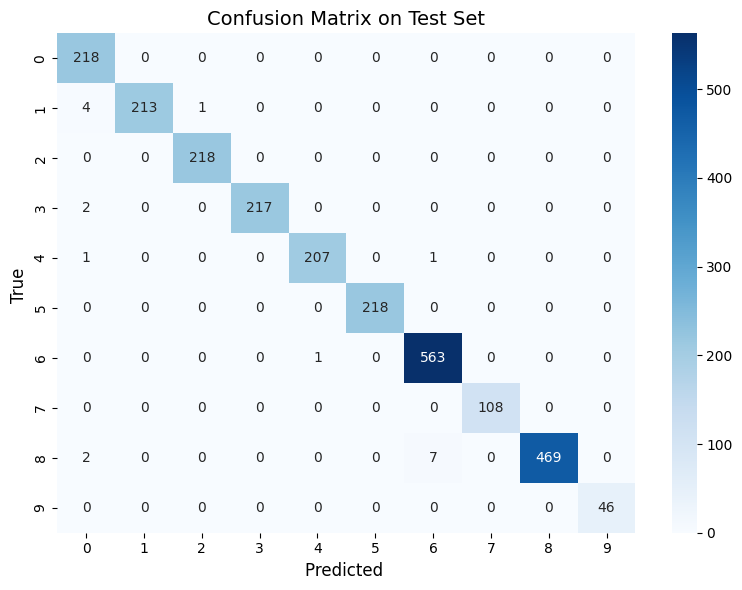

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Save classification report
report_dict = classification_report(all_labels, all_preds, output_dict=True)
pd.DataFrame(report_dict).transpose().to_csv("final_test_classification_report.csv")

# Compute and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title("Confusion Matrix on Test Set", fontsize=14)
plt.xlabel("Predicted ", fontsize=12)
plt.ylabel("True ", fontsize=12)
plt.tight_layout()
plt.show()

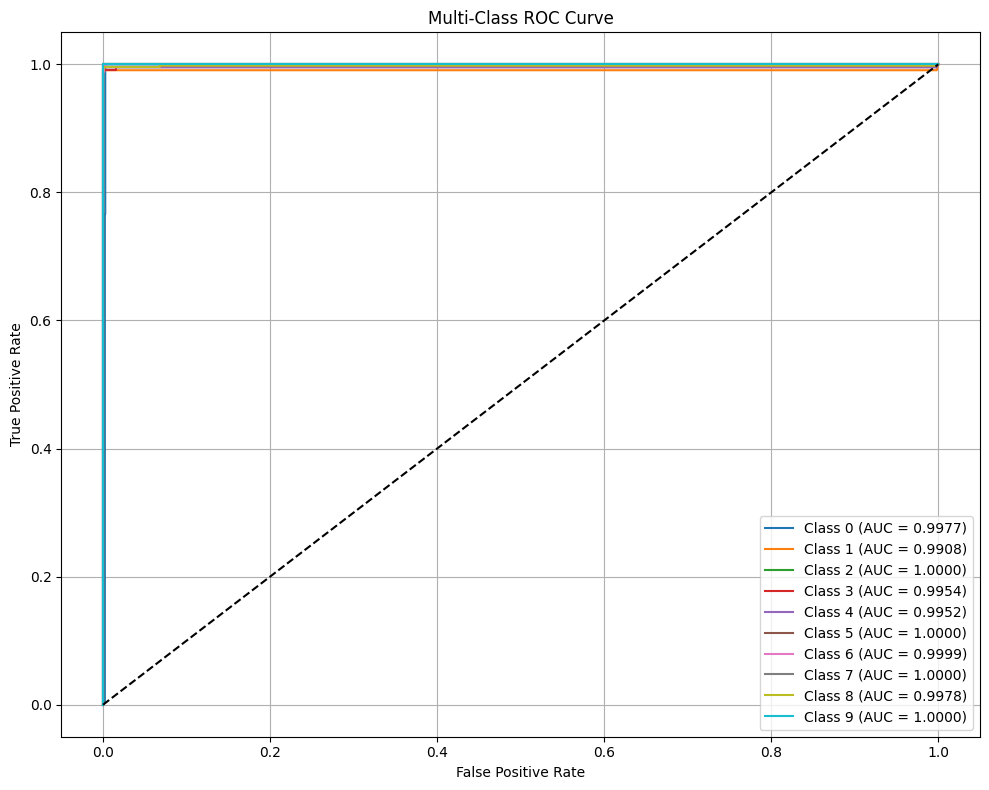

In [138]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Step 1: Binarize the labels for ROC computation
y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))  # shape (N, C)

# Step 2: Get softmax probabilities from model
y_scores = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        y_scores.extend(probs.cpu().numpy())
y_scores = np.array(y_scores)

# Step 3: Plot ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


## Model training: Xception Net 71

In [11]:
def get_timm_model(model_name, num_classes):
    import timm
    import torch.nn as nn
    import torch

    backbone = timm.create_model(model_name, pretrained=True, in_chans=1, num_classes=0)
    dummy = torch.randn(1, 1, 224, 224)  # your input size

    try:
        out = backbone(dummy)
    except Exception:
        out = backbone.forward_features(dummy)

    if out.ndim == 4:
        model = nn.Sequential(
            backbone,
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(backbone.num_features, num_classes)
        )
    elif out.ndim == 2:
        model = nn.Sequential(
            backbone,
            nn.Linear(backbone.num_features, num_classes)
        )
    else:
        raise ValueError(f"Unexpected output shape: {out.shape}")

    return model



In [12]:
def get_xception71_bundle(num_classes=10, lr=1e-4, weight_decay=1e-5):
    import gc
    torch.cuda.empty_cache()
    gc.collect()

    # Load on CPU
    model = get_timm_model("xception71", num_classes)

    # Move to GPU only after clearing memory
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    return model, device, criterion, optimizer



In [13]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [14]:
import torch
from torch.amp import autocast, GradScaler
from sklearn.metrics import f1_score
from tqdm import tqdm

def batch_generator(dataloader):
    for X_batch, y_batch in dataloader:
        try:
            yield X_batch, y_batch
        except RuntimeError as e:
            if 'out of memory' in str(e).lower():
                print("[ WARNING] Skipping batch due to CUDA OOM.")
                torch.cuda.empty_cache()
                continue
            else:
                raise e

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=None):
    scaler = GradScaler()
    best_val_f1 = 0.0
    best_model_path = f"best_model_fold{fold+1}.pth" if fold is not None else "best_model.pth"

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_f1_macro': [], 'val_classwise_f1': []
    }

    for epoch in range(num_epochs):
        # === Training Phase ===
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for X_batch, y_batch in tqdm(batch_generator(train_loader), desc=f"[Epoch {epoch+1}/{num_epochs}] Training", leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            with autocast(device_type='cuda'):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * X_batch.size(0)
            train_correct += (outputs.argmax(dim=1) == y_batch).sum().item()
            train_total += X_batch.size(0)

            torch.cuda.empty_cache()

        train_loss /= train_total
        train_acc = 100. * train_correct / train_total

        # === Validation Phase ===
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        all_preds, all_labels = [], []

        for X_batch, y_batch in tqdm(batch_generator(val_loader), desc=f"[Epoch {epoch+1}/{num_epochs}] Validation", leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            with torch.no_grad(), autocast(device_type='cuda'):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total += X_batch.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

            torch.cuda.empty_cache()

        val_loss /= val_total
        val_acc = 100. * val_correct / val_total
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        class_f1 = f1_score(all_labels, all_preds, average=None)

        # Save best model
        if macro_f1 > best_val_f1:
            best_val_f1 = macro_f1
            torch.save(model.state_dict(), best_model_path)

        # Save to history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1_macro'].append(macro_f1)
        history['val_classwise_f1'].append(class_f1)

        print(f"Epoch {epoch+1}: "
              f"Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, "
              f"Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%, "
              f"Val F1-Macro = {macro_f1:.4f}")

    return history


In [16]:
# from torch.utils.data import WeightedRandomSampler, DataLoader
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np
# from tqdm import tqdm

# # Initialize CV history dictionary
# cv_history = {
#     'train_acc': [], 'val_acc': [],
#     'train_loss': [], 'val_loss': [],
#     'val_f1_macro': [], 'val_classwise_f1': []
# }

# # Loop over folds
# for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
#     print(f"\n--- Fold {fold + 1} ---")

#     # Prepare train/val data
#     X_train = [X_trainval[i] for i in train_idx]
#     y_train = [y_trainval[i] for i in train_idx]
#     X_val = [X_trainval[i] for i in val_idx]
#     y_val = [y_trainval[i] for i in val_idx]

#     # Weighted sampler to handle class imbalance
#     class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
#     weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
#     sample_weights = [weight_map[y] for y in y_train]
#     sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

#     # DataLoaders with appropriate transforms
#     train_dataset = STFTSingleChannelDataset(X_train, y_train, transform=transform)
#     val_dataset = STFTSingleChannelDataset(X_val, y_val, transform=transform)
#     train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=2, pin_memory=True)
#     val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

#     # Load model + training components
#     model, device, criterion, optimizer = get_xception71_bundle(num_classes=10, lr=1e-4, weight_decay=1e-5)

#     # Train model on this fold
#     history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=fold)

#     # Store metrics from the last epoch of this fold
#     cv_history['train_acc'].append(history['train_acc'][-1])
#     cv_history['val_acc'].append(history['val_acc'][-1])
#     cv_history['train_loss'].append(history['train_loss'][-1])
#     cv_history['val_loss'].append(history['val_loss'][-1])
#     cv_history['val_f1_macro'].append(history['val_f1_macro'][-1])
#     cv_history['val_classwise_f1'].append(history['val_classwise_f1'][-1])


In [22]:
!nvidia-smi


Tue Jul 29 12:37:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti     On  |   00000000:01:00.0  On |                  N/A |
| 37%   55C    P8             22W /  200W |    3926MiB /   8192MiB |     39%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [23]:
from torch.utils.data import WeightedRandomSampler, DataLoader
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tqdm import tqdm
import torch, gc  # ✅ Needed for memory cleanup

# Initialize CV history dictionary
cv_history = {
    'train_acc': [], 'val_acc': [],
    'train_loss': [], 'val_loss': [],
    'val_f1_macro': [], 'val_classwise_f1': []
}

# Store full epoch history if needed
all_fold_histories = []

# Loop over folds
for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
    print(f"\n--- Fold {fold + 1} ---")

    # Prepare train/val data
    X_train = [X_trainval[i] for i in train_idx]
    y_train = [y_trainval[i] for i in train_idx]
    X_val = [X_trainval[i] for i in val_idx]
    y_val = [y_trainval[i] for i in val_idx]

    # Weighted sampler to handle class imbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
    sample_weights = [weight_map[y] for y in y_train]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    # ✅ Reduce batch size to save memory
    train_dataset = STFTSingleChannelDataset(X_train, y_train, transform=transform)
    val_dataset = STFTSingleChannelDataset(X_val, y_val, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

    # Load model + training components
    model, device, criterion, optimizer = get_xception71_bundle(num_classes=10, lr=1e-4, weight_decay=1e-5)

    # Train model on this fold
    history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=fold)

    # Save full history if needed for plotting
    all_fold_histories.append(history)

    # Store metrics from the last epoch of this fold
    cv_history['train_acc'].append(history['train_acc'][-1])
    cv_history['val_acc'].append(history['val_acc'][-1])
    cv_history['train_loss'].append(history['train_loss'][-1])
    cv_history['val_loss'].append(history['val_loss'][-1])
    cv_history['val_f1_macro'].append(history['val_f1_macro'][-1])
    cv_history['val_classwise_f1'].append(history['val_classwise_f1'][-1])

    # ✅ Free GPU memory after each fold
    del model
    torch.cuda.empty_cache()
    gc.collect()



--- Fold 1 ---


Epoch 1: Train Loss = 0.5953, Val Loss = 0.1907, Train Acc = 80.55%, Val Acc = 93.29%, Val F1-Macro = 0.9414


Epoch 2: Train Loss = 0.1527, Val Loss = 0.1440, Train Acc = 95.14%, Val Acc = 96.30%, Val F1-Macro = 0.9558


Epoch 3: Train Loss = 0.0969, Val Loss = 0.0970, Train Acc = 97.07%, Val Acc = 96.90%, Val F1-Macro = 0.9647


Epoch 4: Train Loss = 0.0616, Val Loss = 0.0599, Train Acc = 98.26%, Val Acc = 98.40%, Val F1-Macro = 0.9838


Epoch 5: Train Loss = 0.0701, Val Loss = 0.0526, Train Acc = 97.90%, Val Acc = 98.20%, Val F1-Macro = 0.9813


Epoch 6: Train Loss = 0.0646, Val Loss = 0.1953, Train Acc = 98.22%, Val Acc = 95.90%, Val F1-Macro = 0.9558


Epoch 7: Train Loss = 0.0605, Val Loss = 0.0625, Train Acc = 98.07%, Val Acc = 98.50%, Val F1-Macro = 0.9843


Epoch 8: Train Loss = 0.0520, Val Loss = 0.0212, Train Acc = 98.48%, Val Acc = 99.40%, Val F1-Macro = 0.9927


Epoch 9: Train Loss = 0.0402, Val Loss = 0.0146, Train Acc = 98.86%, Val Acc = 99.50%, Val F1-Macro = 0.9908


Epoch 10: Train Loss = 0.0429, Val Loss = 0.0206, Train Acc = 98.81%, Val Acc = 99.50%, Val F1-Macro = 0.9956

--- Fold 2 ---


Epoch 1: Train Loss = 0.6107, Val Loss = 0.1961, Train Acc = 79.90%, Val Acc = 93.49%, Val F1-Macro = 0.9340


Epoch 2: Train Loss = 0.1381, Val Loss = 0.8565, Train Acc = 95.74%, Val Acc = 89.99%, Val F1-Macro = 0.9055


Epoch 3: Train Loss = 0.1024, Val Loss = 0.0923, Train Acc = 96.91%, Val Acc = 98.00%, Val F1-Macro = 0.9745


Epoch 4: Train Loss = 0.0862, Val Loss = nan, Train Acc = 97.33%, Val Acc = 96.10%, Val F1-Macro = 0.9640


Epoch 5: Train Loss = 0.0748, Val Loss = 0.6717, Train Acc = 97.94%, Val Acc = 92.69%, Val F1-Macro = 0.9279


Epoch 6: Train Loss = 0.0444, Val Loss = 0.3645, Train Acc = 98.73%, Val Acc = 93.89%, Val F1-Macro = 0.9352


Epoch 7: Train Loss = 0.0534, Val Loss = 0.1923, Train Acc = 98.38%, Val Acc = 94.29%, Val F1-Macro = 0.9445


Epoch 8: Train Loss = 0.0508, Val Loss = 0.0403, Train Acc = 98.73%, Val Acc = 98.70%, Val F1-Macro = 0.9845


Epoch 9: Train Loss = 0.0425, Val Loss = 0.1624, Train Acc = 98.86%, Val Acc = 95.30%, Val F1-Macro = 0.9519


Epoch 10: Train Loss = 0.0457, Val Loss = 0.0577, Train Acc = 98.73%, Val Acc = 98.70%, Val F1-Macro = 0.9847

--- Fold 3 ---


Epoch 1: Train Loss = 0.5656, Val Loss = 0.7448, Train Acc = 81.74%, Val Acc = 85.59%, Val F1-Macro = 0.8640


Epoch 2: Train Loss = 0.1401, Val Loss = 0.3179, Train Acc = 95.82%, Val Acc = 92.79%, Val F1-Macro = 0.9280


Epoch 3: Train Loss = 0.1000, Val Loss = 0.2857, Train Acc = 97.10%, Val Acc = 94.49%, Val F1-Macro = 0.9410


Epoch 4: Train Loss = 0.0662, Val Loss = 0.1205, Train Acc = 98.10%, Val Acc = 96.60%, Val F1-Macro = 0.9637


Epoch 5: Train Loss = 0.0737, Val Loss = 0.0587, Train Acc = 97.75%, Val Acc = 98.40%, Val F1-Macro = 0.9854


Epoch 6: Train Loss = 0.0513, Val Loss = 0.0515, Train Acc = 98.69%, Val Acc = 98.60%, Val F1-Macro = 0.9859


Epoch 7: Train Loss = 0.0547, Val Loss = 0.0467, Train Acc = 98.41%, Val Acc = 98.30%, Val F1-Macro = 0.9820


Epoch 8: Train Loss = 0.0531, Val Loss = 0.0561, Train Acc = 98.61%, Val Acc = 98.80%, Val F1-Macro = 0.9868


Epoch 9: Train Loss = 0.0445, Val Loss = 0.0143, Train Acc = 98.75%, Val Acc = 99.70%, Val F1-Macro = 0.9952


Epoch 10: Train Loss = 0.0247, Val Loss = 0.0162, Train Acc = 99.37%, Val Acc = 99.50%, Val F1-Macro = 0.9960

--- Fold 4 ---


Epoch 1: Train Loss = 0.5597, Val Loss = 0.1670, Train Acc = 82.07%, Val Acc = 94.59%, Val F1-Macro = 0.9562


Epoch 2: Train Loss = 0.1380, Val Loss = 0.0965, Train Acc = 95.86%, Val Acc = 97.80%, Val F1-Macro = 0.9766


Epoch 3: Train Loss = 0.0900, Val Loss = 0.0751, Train Acc = 97.30%, Val Acc = 99.10%, Val F1-Macro = 0.9915


Epoch 4: Train Loss = 0.0675, Val Loss = 0.0793, Train Acc = 98.02%, Val Acc = 98.00%, Val F1-Macro = 0.9811


Epoch 5: Train Loss = 0.0697, Val Loss = 0.0529, Train Acc = 98.00%, Val Acc = 98.50%, Val F1-Macro = 0.9863


Epoch 6: Train Loss = 0.0470, Val Loss = 0.3752, Train Acc = 98.64%, Val Acc = 93.79%, Val F1-Macro = 0.9398


Epoch 7: Train Loss = 0.0488, Val Loss = 0.0654, Train Acc = 98.69%, Val Acc = 99.00%, Val F1-Macro = 0.9818


Epoch 8: Train Loss = 0.0456, Val Loss = 0.0337, Train Acc = 98.82%, Val Acc = 99.00%, Val F1-Macro = 0.9874


Epoch 9: Train Loss = 0.0464, Val Loss = nan, Train Acc = 98.91%, Val Acc = 93.49%, Val F1-Macro = 0.9459


Epoch 10: Train Loss = 0.0481, Val Loss = 0.0301, Train Acc = 98.85%, Val Acc = 99.20%, Val F1-Macro = 0.9919

--- Fold 5 ---


Epoch 1: Train Loss = 0.5750, Val Loss = nan, Train Acc = 81.32%, Val Acc = 83.17%, Val F1-Macro = 0.8449


Epoch 2: Train Loss = 0.1452, Val Loss = 0.0718, Train Acc = 95.67%, Val Acc = 97.70%, Val F1-Macro = 0.9800


Epoch 3: Train Loss = 0.0962, Val Loss = 0.0428, Train Acc = 97.20%, Val Acc = 99.20%, Val F1-Macro = 0.9921


Epoch 4: Train Loss = 0.0694, Val Loss = 0.0716, Train Acc = 97.97%, Val Acc = 98.60%, Val F1-Macro = 0.9853


Epoch 5: Train Loss = 0.0709, Val Loss = 0.0550, Train Acc = 97.82%, Val Acc = 98.80%, Val F1-Macro = 0.9877


Epoch 6: Train Loss = 0.0561, Val Loss = 0.1383, Train Acc = 98.46%, Val Acc = 96.29%, Val F1-Macro = 0.9714


Epoch 7: Train Loss = 0.0502, Val Loss = 0.0085, Train Acc = 98.66%, Val Acc = 99.70%, Val F1-Macro = 0.9972


Epoch 8: Train Loss = 0.0475, Val Loss = 0.1679, Train Acc = 98.80%, Val Acc = 96.39%, Val F1-Macro = 0.9423


Epoch 9: Train Loss = 0.0380, Val Loss = 0.1084, Train Acc = 99.02%, Val Acc = 96.89%, Val F1-Macro = 0.9728


Epoch 10: Train Loss = 0.0432, Val Loss = 0.0058, Train Acc = 98.83%, Val Acc = 100.00%, Val F1-Macro = 1.0000

--- Fold 6 ---


Epoch 1: Train Loss = 0.5879, Val Loss = 0.2062, Train Acc = 81.10%, Val Acc = 93.29%, Val F1-Macro = 0.9285


Epoch 2: Train Loss = 0.1460, Val Loss = 0.1744, Train Acc = 95.74%, Val Acc = 95.09%, Val F1-Macro = 0.9553


Epoch 3: Train Loss = 0.0929, Val Loss = 0.0858, Train Acc = 97.40%, Val Acc = 97.70%, Val F1-Macro = 0.9742


Epoch 4: Train Loss = 0.0726, Val Loss = 0.1640, Train Acc = 98.00%, Val Acc = 95.99%, Val F1-Macro = 0.9586


Epoch 5: Train Loss = 0.0819, Val Loss = 0.1941, Train Acc = 97.60%, Val Acc = 95.99%, Val F1-Macro = 0.9613


Epoch 6: Train Loss = 0.0597, Val Loss = 0.0672, Train Acc = 98.24%, Val Acc = 98.00%, Val F1-Macro = 0.9785


Epoch 7: Train Loss = 0.0448, Val Loss = 0.0427, Train Acc = 98.80%, Val Acc = 98.70%, Val F1-Macro = 0.9824


Epoch 8: Train Loss = 0.0495, Val Loss = 0.0394, Train Acc = 98.69%, Val Acc = 99.10%, Val F1-Macro = 0.9895


Epoch 9: Train Loss = 0.0365, Val Loss = 0.0600, Train Acc = 99.05%, Val Acc = 98.60%, Val F1-Macro = 0.9840


Epoch 10: Train Loss = 0.0420, Val Loss = 0.0289, Train Acc = 98.85%, Val Acc = 99.40%, Val F1-Macro = 0.9915

--- Fold 7 ---


Epoch 1: Train Loss = 0.5491, Val Loss = 0.5245, Train Acc = 82.39%, Val Acc = 89.78%, Val F1-Macro = 0.8760


Epoch 2: Train Loss = 0.1377, Val Loss = 0.0326, Train Acc = 95.90%, Val Acc = 98.90%, Val F1-Macro = 0.9910


Epoch 3: Train Loss = 0.0995, Val Loss = 0.0691, Train Acc = 97.03%, Val Acc = 98.50%, Val F1-Macro = 0.9745


Epoch 4: Train Loss = 0.0603, Val Loss = 0.0304, Train Acc = 98.28%, Val Acc = 99.50%, Val F1-Macro = 0.9953


Epoch 5: Train Loss = 0.0756, Val Loss = 0.0190, Train Acc = 97.91%, Val Acc = 99.50%, Val F1-Macro = 0.9963


Epoch 6: Train Loss = 0.0562, Val Loss = 0.0272, Train Acc = 98.49%, Val Acc = 99.30%, Val F1-Macro = 0.9923


Epoch 7: Train Loss = 0.0502, Val Loss = 0.0132, Train Acc = 98.72%, Val Acc = 99.60%, Val F1-Macro = 0.9938


Epoch 8: Train Loss = 0.0483, Val Loss = 0.0497, Train Acc = 98.71%, Val Acc = 98.70%, Val F1-Macro = 0.9877


Epoch 9: Train Loss = 0.0485, Val Loss = 0.0469, Train Acc = 98.72%, Val Acc = 98.80%, Val F1-Macro = 0.9842


Epoch 10: Train Loss = 0.0241, Val Loss = 0.0208, Train Acc = 99.44%, Val Acc = 99.30%, Val F1-Macro = 0.9933

--- Fold 8 ---


Epoch 1: Train Loss = 0.5847, Val Loss = 0.2526, Train Acc = 81.27%, Val Acc = 92.48%, Val F1-Macro = 0.9222


Epoch 2: Train Loss = 0.1485, Val Loss = 0.1167, Train Acc = 95.62%, Val Acc = 97.29%, Val F1-Macro = 0.9678


Epoch 3: Train Loss = 0.0903, Val Loss = 0.0735, Train Acc = 97.57%, Val Acc = 97.60%, Val F1-Macro = 0.9724


Epoch 4: Train Loss = 0.0874, Val Loss = 0.2445, Train Acc = 97.43%, Val Acc = 96.39%, Val F1-Macro = 0.9670


Epoch 5: Train Loss = 0.0585, Val Loss = 0.1075, Train Acc = 98.17%, Val Acc = 97.39%, Val F1-Macro = 0.9667


Epoch 6: Train Loss = 0.0509, Val Loss = 0.2154, Train Acc = 98.52%, Val Acc = 93.19%, Val F1-Macro = 0.9337


Epoch 7: Train Loss = 0.0624, Val Loss = 0.2478, Train Acc = 98.20%, Val Acc = 95.89%, Val F1-Macro = 0.9615


Epoch 8: Train Loss = 0.0371, Val Loss = 0.2217, Train Acc = 99.04%, Val Acc = 95.69%, Val F1-Macro = 0.9547


Epoch 9: Train Loss = 0.0490, Val Loss = 0.0202, Train Acc = 98.69%, Val Acc = 99.60%, Val F1-Macro = 0.9951


Epoch 10: Train Loss = 0.0448, Val Loss = 0.0245, Train Acc = 98.94%, Val Acc = 99.30%, Val F1-Macro = 0.9947

--- Fold 9 ---


Epoch 1: Train Loss = 0.5950, Val Loss = 0.1394, Train Acc = 80.84%, Val Acc = 95.49%, Val F1-Macro = 0.9505


Epoch 2: Train Loss = 0.1592, Val Loss = 0.2805, Train Acc = 95.03%, Val Acc = 93.49%, Val F1-Macro = 0.9378


Epoch 3: Train Loss = 0.1023, Val Loss = 0.2745, Train Acc = 96.80%, Val Acc = 92.99%, Val F1-Macro = 0.9291


Epoch 4: Train Loss = 0.0764, Val Loss = 0.1937, Train Acc = 97.95%, Val Acc = 95.39%, Val F1-Macro = 0.9500


Epoch 5: Train Loss = 0.0706, Val Loss = 0.1395, Train Acc = 97.95%, Val Acc = 96.09%, Val F1-Macro = 0.9649


Epoch 6: Train Loss = 0.0597, Val Loss = 0.1232, Train Acc = 98.25%, Val Acc = 97.19%, Val F1-Macro = 0.9715


Epoch 7: Train Loss = 0.0534, Val Loss = 0.1010, Train Acc = 98.61%, Val Acc = 97.19%, Val F1-Macro = 0.9755


Epoch 8: Train Loss = 0.0431, Val Loss = 0.0718, Train Acc = 98.85%, Val Acc = 98.70%, Val F1-Macro = 0.9876


Epoch 9: Train Loss = 0.0447, Val Loss = 0.0348, Train Acc = 98.74%, Val Acc = 98.90%, Val F1-Macro = 0.9892


Epoch 10: Train Loss = 0.0301, Val Loss = 0.3676, Train Acc = 99.04%, Val Acc = 92.28%, Val F1-Macro = 0.8836

--- Fold 10 ---


Epoch 1: Train Loss = 0.5533, Val Loss = 0.1586, Train Acc = 82.22%, Val Acc = 95.39%, Val F1-Macro = 0.9569


Epoch 2: Train Loss = 0.1437, Val Loss = 0.0398, Train Acc = 95.62%, Val Acc = 98.80%, Val F1-Macro = 0.9868


Epoch 3: Train Loss = 0.0979, Val Loss = 0.0677, Train Acc = 96.96%, Val Acc = 97.80%, Val F1-Macro = 0.9800


Epoch 4: Train Loss = 0.0728, Val Loss = 0.0368, Train Acc = 97.83%, Val Acc = 98.90%, Val F1-Macro = 0.9902


Epoch 5: Train Loss = 0.0667, Val Loss = 0.0343, Train Acc = 98.11%, Val Acc = 99.30%, Val F1-Macro = 0.9870


Epoch 6: Train Loss = 0.0511, Val Loss = 0.0891, Train Acc = 98.59%, Val Acc = 97.39%, Val F1-Macro = 0.9752


Epoch 7: Train Loss = 0.0469, Val Loss = 0.0358, Train Acc = 98.82%, Val Acc = 99.00%, Val F1-Macro = 0.9897


Epoch 8: Train Loss = 0.0501, Val Loss = 0.0285, Train Acc = 98.50%, Val Acc = 99.20%, Val F1-Macro = 0.9922


Epoch 9: Train Loss = 0.0367, Val Loss = 0.0408, Train Acc = 98.91%, Val Acc = 98.70%, Val F1-Macro = 0.9890


Epoch 10: Train Loss = 0.0485, Val Loss = 0.0379, Train Acc = 98.75%, Val Acc = 99.20%, Val F1-Macro = 0.9871


In [24]:
num_classes = 10
best_fold = np.argmax(cv_history['val_f1_macro'])

# ✅ Only get the model
model = get_xception71_bundle(num_classes)[0]  # Unpack only the model
model.load_state_dict(torch.load(f"best_model_fold{best_fold+1}.pth"))
model = model.to(device)
model.eval()

# Predict
all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

acc = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average='macro')
report = classification_report(all_labels, all_preds, digits=4, labels=range(num_classes))
cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))

print("\n=== Final Test Set Evaluation ===")
print(f"Accuracy       : {acc:.4f}")
print(f"Macro F1-score : {macro_f1:.4f}")
print("\nClassification Report:\n", report)



=== Final Test Set Evaluation ===
Accuracy       : 0.9940
Macro F1-score : 0.9919

Classification Report:
               precision    recall  f1-score   support

           0     0.9907    0.9817    0.9862       218
           1     0.9954    0.9908    0.9931       218
           2     0.9863    0.9908    0.9886       218
           3     0.9954    0.9954    0.9954       219
           4     0.9952    0.9952    0.9952       209
           5     1.0000    1.0000    1.0000       218
           6     0.9929    0.9947    0.9938       564
           7     1.0000    1.0000    1.0000       108
           8     1.0000    0.9958    0.9979       478
           9     0.9388    1.0000    0.9684        46

    accuracy                         0.9940      2496
   macro avg     0.9895    0.9944    0.9919      2496
weighted avg     0.9941    0.9940    0.9940      2496



In [25]:
import pandas as pd

# Create a DataFrame from cv_history
fold_summary = pd.DataFrame({
    "Fold": [f"Fold {i+1}" for i in range(len(cv_history['train_acc']))],
    "Train Accuracy (%)": cv_history['train_acc'],
    "Val Accuracy (%)": cv_history['val_acc'],
    "Train Loss": cv_history['train_loss'],
    "Val Loss": cv_history['val_loss'],
    "Val Macro F1": cv_history['val_f1_macro']
})

# Round values to 4 decimals
fold_summary = fold_summary.round(4)

# Print neatly
print("\n=== Per-Fold Summary ===")
print(fold_summary)

# Optionally save it
fold_summary.to_csv("cv_fold_summary.csv", index=False)



=== Per-Fold Summary ===
      Fold  Train Accuracy (%)  Val Accuracy (%)  Train Loss  Val Loss  \
0   Fold 1             98.8091           99.4995      0.0429    0.0206   
1   Fold 2             98.7312           98.6987      0.0457    0.0577   
2   Fold 3             99.3656           99.4995      0.0247    0.0162   
3   Fold 4             98.8536           99.1992      0.0481    0.0301   
4   Fold 5             98.8315          100.0000      0.0432    0.0058   
5   Fold 6             98.8538           99.3988      0.0420    0.0289   
6   Fold 7             99.4436           99.2986      0.0241    0.0208   
7   Fold 8             98.9428           99.2986      0.0448    0.0245   
8   Fold 9             99.0430           92.2846      0.0301    0.3676   
9  Fold 10             98.7536           99.1984      0.0485    0.0379   

   Val Macro F1  
0        0.9956  
1        0.9847  
2        0.9960  
3        0.9919  
4        1.0000  
5        0.9915  
6        0.9933  
7        0.9947

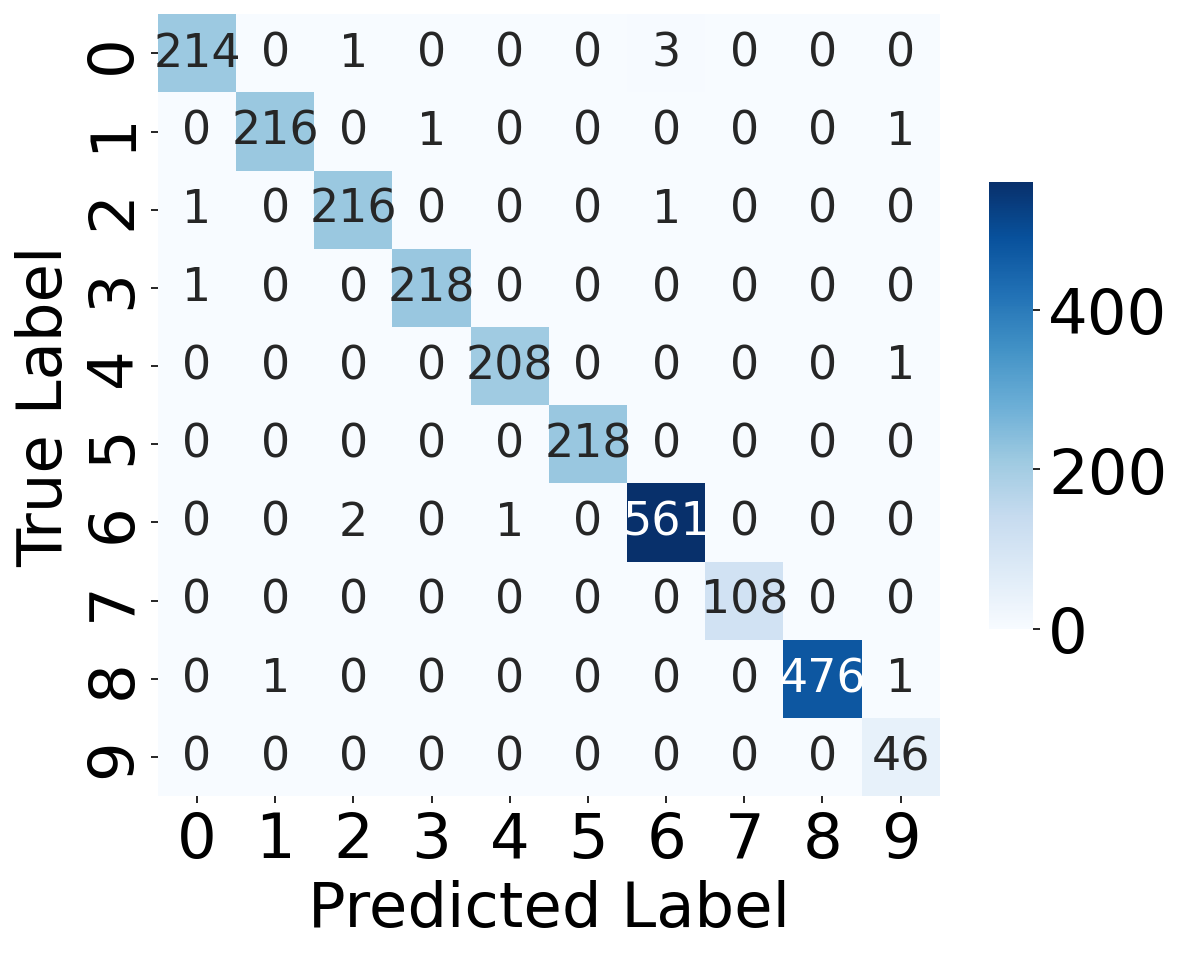

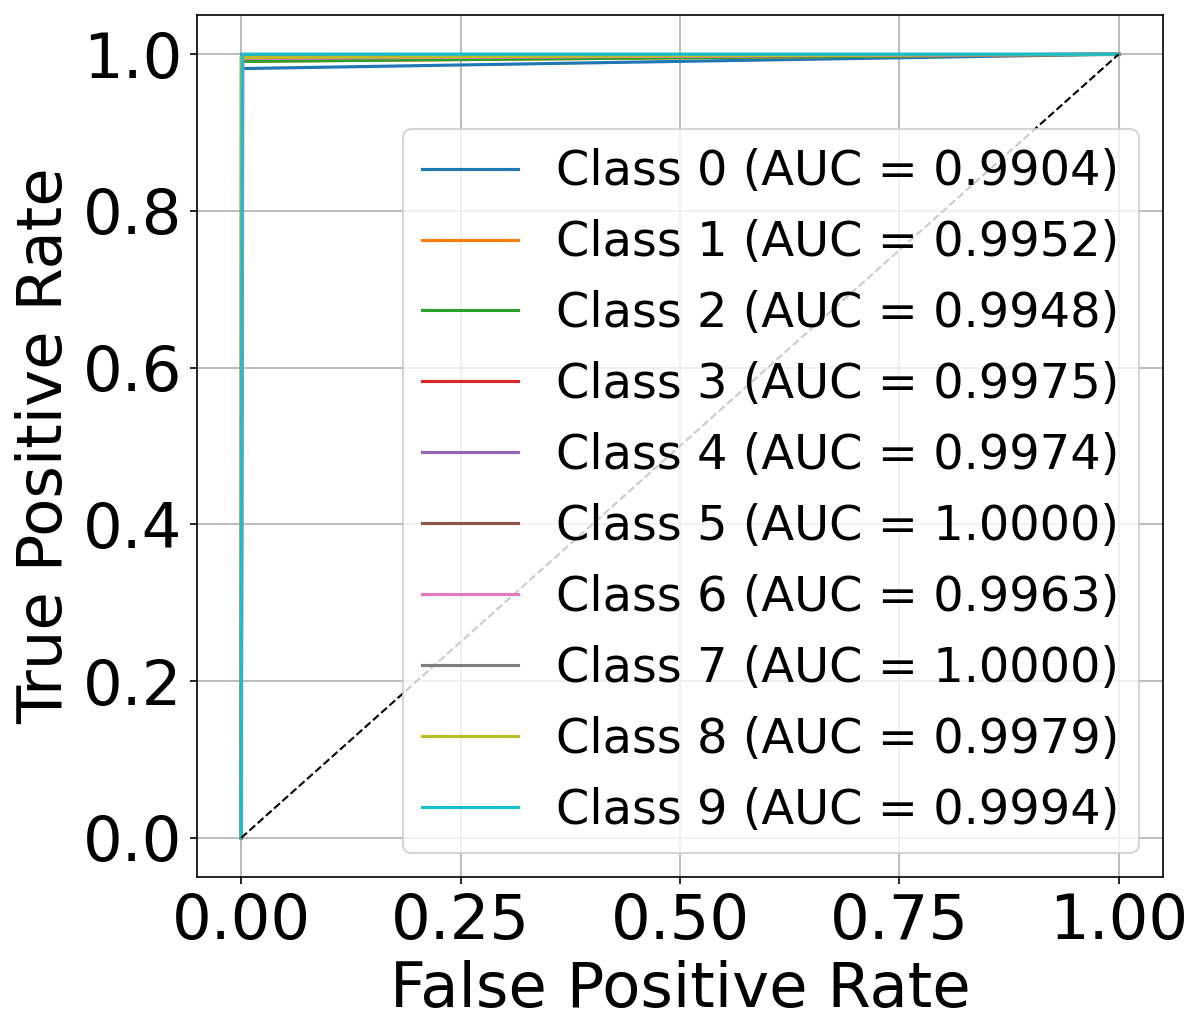

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

def save_and_plot_confusion_and_roc(y_true, y_pred, num_classes=10):
    # === Save classification report ===
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    pd.DataFrame(report_dict).transpose().to_csv("final_test_classification_report.csv")

    # === Binarize for ROC ===
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    y_pred_bin = label_binarize(y_pred, classes=list(range(num_classes)))

    # === Confusion Matrix ===
    cm = confusion_matrix(y_true, y_pred)
    fig_cm, ax_cm = plt.subplots(figsize=(8, 7), dpi=150)

    heatmap = sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        square=True,
        cbar=True,
        ax=ax_cm,
        annot_kws={"size": 22},
        cbar_kws={'shrink': 0.5, 'aspect': 10}
    )

    #ax_cm.set_title("Confusion Matrix on Test Set", fontsize=30)
    ax_cm.set_xlabel("Predicted Label", fontsize=30)
    ax_cm.set_ylabel("True Label", fontsize=30)
    ax_cm.tick_params(labelsize=30)

    # Adjust colorbar ticks
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=30)

    plt.tight_layout()
    plt.show()

    # === ROC Curve ===
    fig_roc, ax_roc = plt.subplots(figsize=(8, 7), dpi=150)

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.4f})')

    ax_roc.plot([0, 1], [0, 1], 'k--', linewidth=1)
    #ax_roc.set_title("ROC Curve (One-vs-Rest)", fontsize=30)
    ax_roc.set_xlabel("False Positive Rate", fontsize=30)
    ax_roc.set_ylabel("True Positive Rate", fontsize=30)
    ax_roc.tick_params(labelsize=30)
    ax_roc.legend(loc='lower right', fontsize=23)
    ax_roc.grid(True)

    plt.tight_layout()
    plt.show()

# Usage
save_and_plot_confusion_and_roc(all_labels, all_preds, num_classes=10)


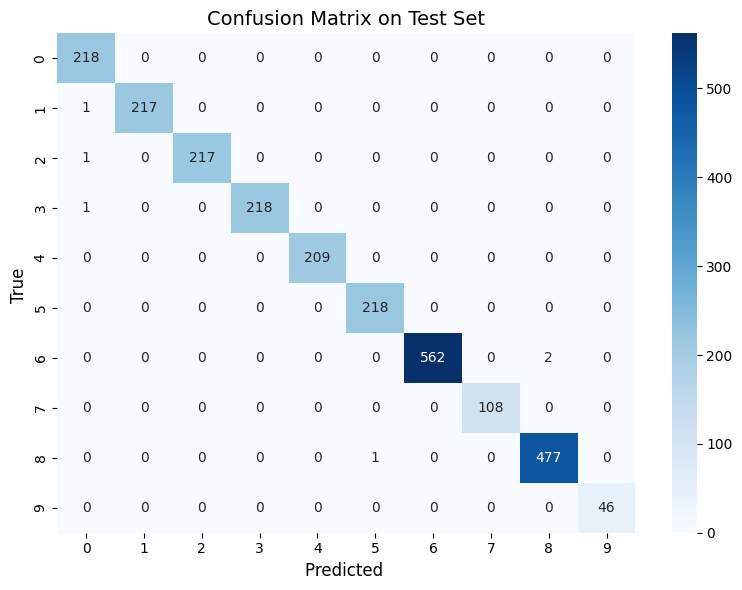

In [61]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd
# from sklearn.metrics import classification_report, confusion_matrix

# # Save classification report
# report_dict = classification_report(all_labels, all_preds, output_dict=True)
# pd.DataFrame(report_dict).transpose().to_csv("final_test_classification_report.csv")

# # Compute and plot confusion matrix
# cm = confusion_matrix(all_labels, all_preds)

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
#             xticklabels=range(num_classes), yticklabels=range(num_classes))
# plt.title("Confusion Matrix on Test Set", fontsize=14)
# plt.xlabel("Predicted ", fontsize=12)
# plt.ylabel("True ", fontsize=12)
# plt.tight_layout()
# plt.show()

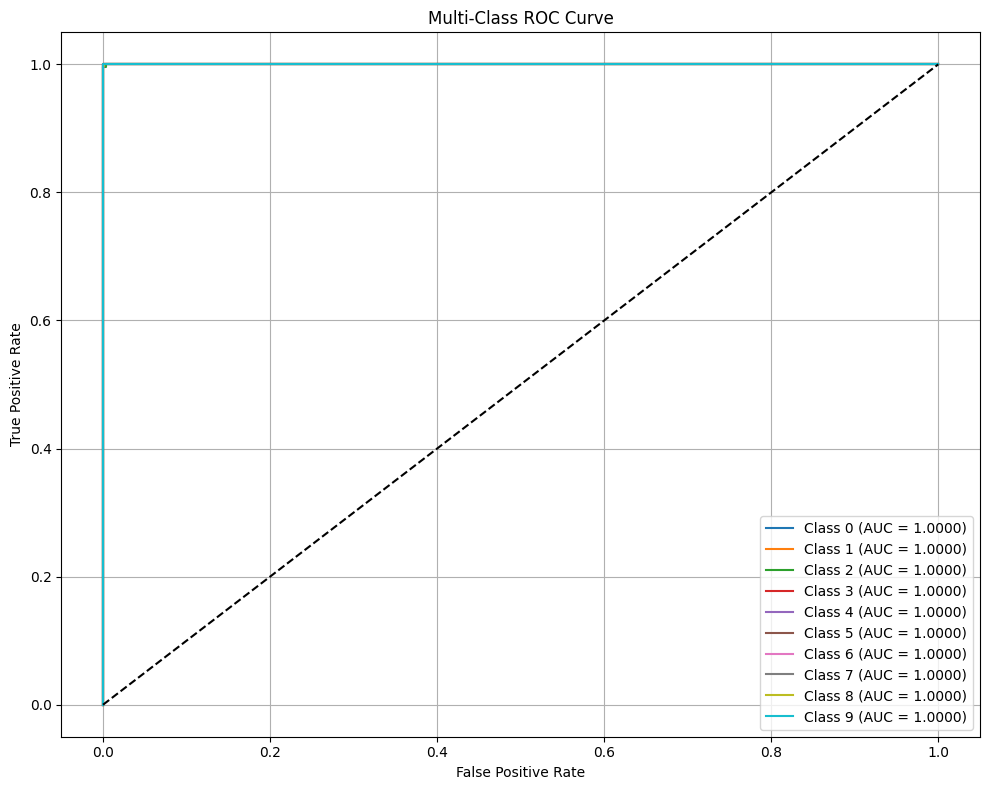

In [62]:
# from sklearn.metrics import roc_curve, auc
# from sklearn.preprocessing import label_binarize
# import matplotlib.pyplot as plt

# # Step 1: Binarize the labels for ROC computation
# y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))  # shape (N, C)

# # Step 2: Get softmax probabilities from model
# y_scores = []
# with torch.no_grad():
#     for X_batch, _ in test_loader:
#         X_batch = X_batch.to(device)
#         outputs = model(X_batch)
#         probs = torch.softmax(outputs, dim=1)
#         y_scores.extend(probs.cpu().numpy())
# y_scores = np.array(y_scores)

# # Step 3: Plot ROC curve for each class
# plt.figure(figsize=(10, 8))

# for i in range(num_classes):
#     fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.4f})")

# plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Multi-Class ROC Curve')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.tight_layout()
# plt.show()


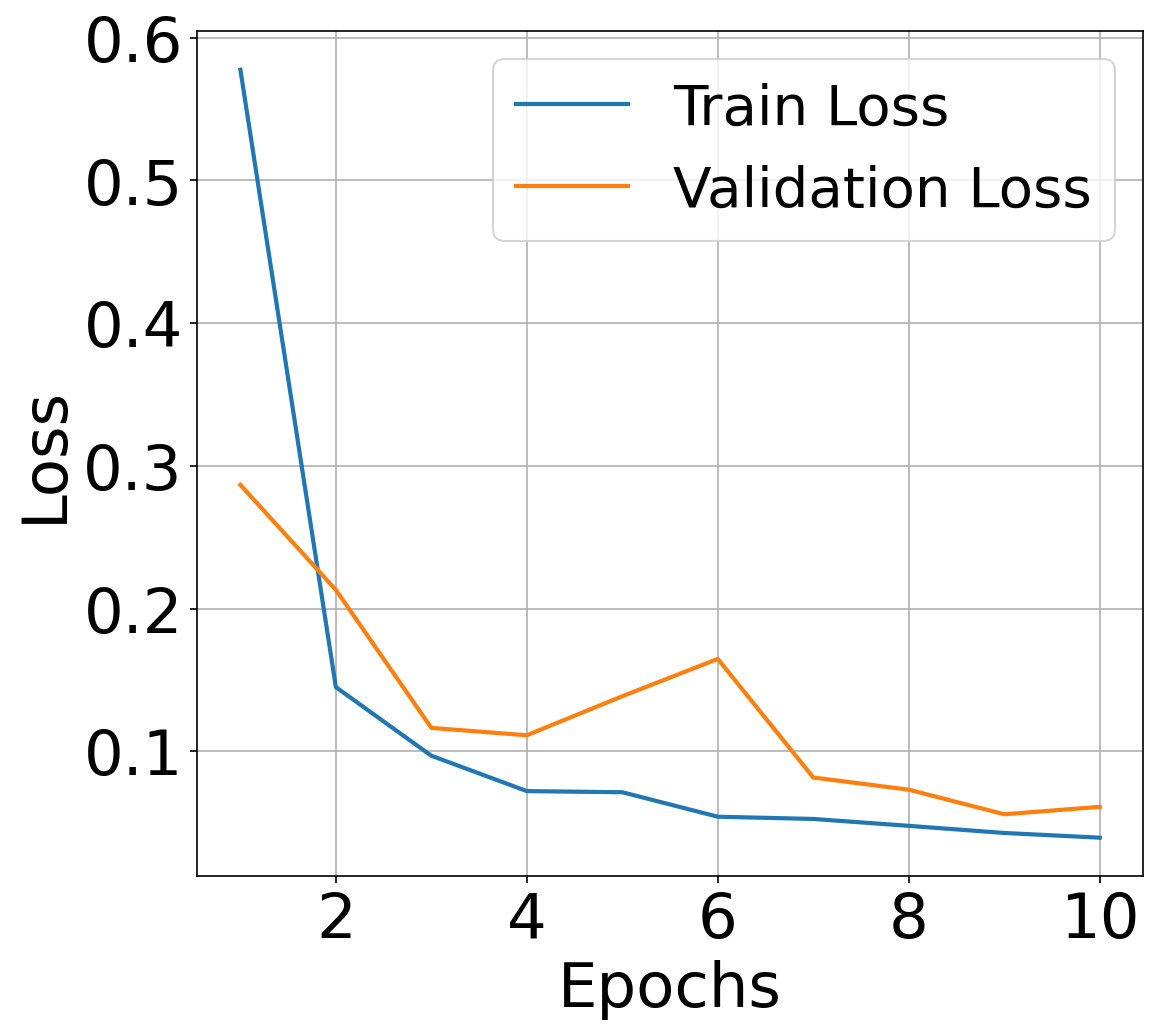

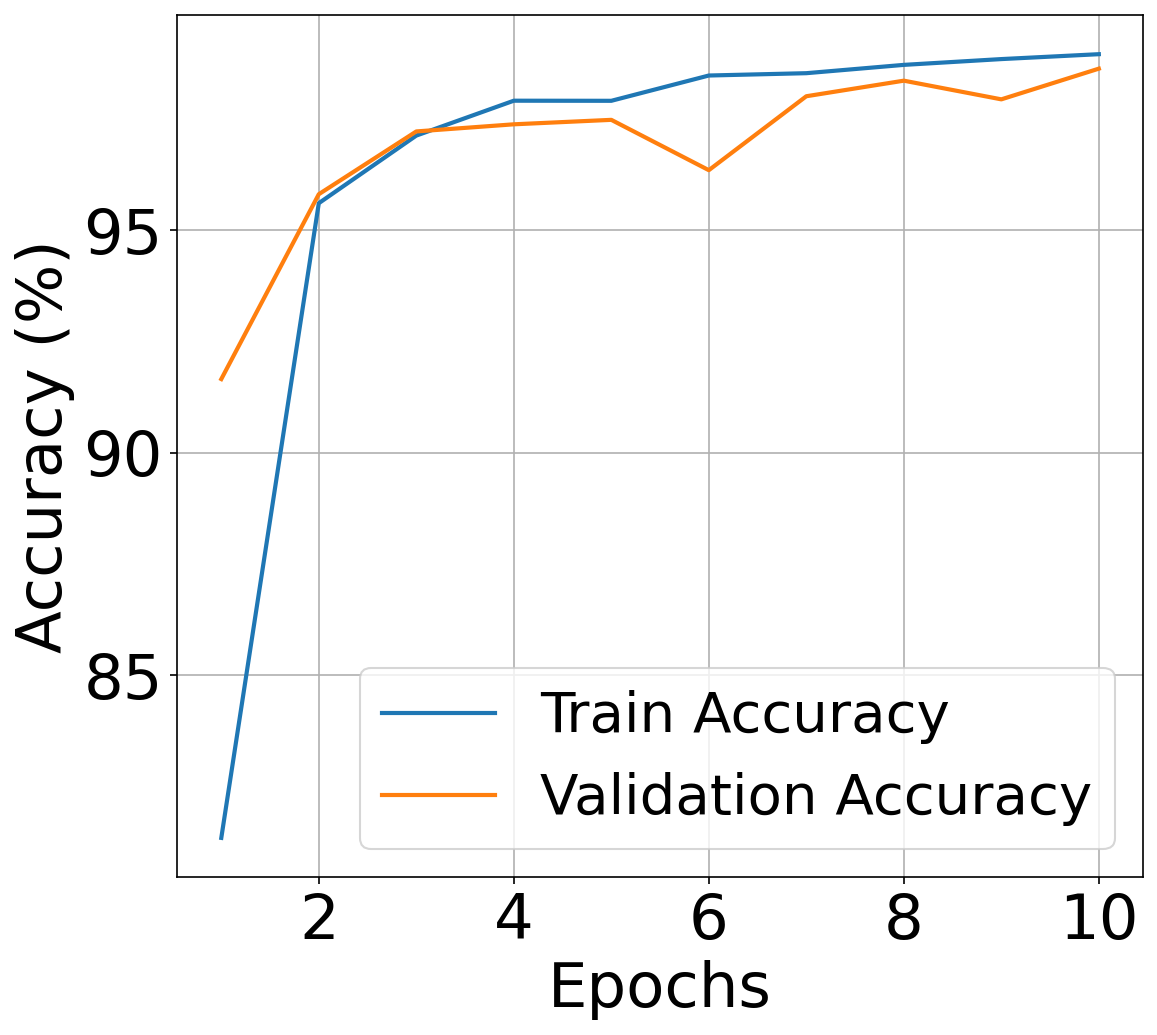

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import zip_longest

def pad_and_average(metric_list, fill_value=np.nan):
    """
    Pads metric lists to the longest length using NaN and computes the mean per epoch.
    """
    padded = list(zip_longest(*metric_list, fillvalue=fill_value))
    return np.nanmean(padded, axis=1)

def plot_avg_loss_accuracy(all_fold_histories):
    """
    Plots average training and validation loss and accuracy across folds (per epoch).
    Uses `all_fold_histories`, which contains full training logs per fold.
    """
    train_loss_all = [fold['train_loss'] for fold in all_fold_histories]
    val_loss_all   = [fold['val_loss'] for fold in all_fold_histories]
    train_acc_all  = [fold['train_acc'] for fold in all_fold_histories]
    val_acc_all    = [fold['val_acc'] for fold in all_fold_histories]

    avg_train_loss = pad_and_average(train_loss_all)
    avg_val_loss   = pad_and_average(val_loss_all)
    avg_train_acc  = pad_and_average(train_acc_all)
    avg_val_acc    = pad_and_average(val_acc_all)

    num_epochs = len(avg_train_loss)
    epochs = range(1, num_epochs + 1)

    # === Plot Loss ===
    fig_loss, ax_loss = plt.subplots(figsize=(8, 7), dpi=150)
    ax_loss.plot(epochs, avg_train_loss, label='Train Loss', linewidth=2)
    ax_loss.plot(epochs, avg_val_loss, label='Validation Loss', linewidth=2)
    ax_loss.set_xlabel("Epochs", fontsize=30)
    ax_loss.set_ylabel("Loss", fontsize=30)
    ax_loss.tick_params(labelsize=30)
    ax_loss.legend(fontsize=27)
    ax_loss.grid(True)
    plt.tight_layout()
    plt.show()

    # === Plot Accuracy ===
    fig_acc, ax_acc = plt.subplots(figsize=(8, 7), dpi=150)
    ax_acc.plot(epochs, avg_train_acc, label='Train Accuracy', linewidth=2)
    ax_acc.plot(epochs, avg_val_acc, label='Validation Accuracy', linewidth=2)
    ax_acc.set_xlabel("Epochs", fontsize=30)
    ax_acc.set_ylabel("Accuracy (%)", fontsize=30)
    ax_acc.tick_params(labelsize=30)
    ax_acc.legend(fontsize=27)
    ax_acc.grid(True)
    plt.tight_layout()
    plt.show()

# === Call the function after training ===
plot_avg_loss_accuracy(all_fold_histories)


## Model training:  Deit_tiny_patch16_224

In [64]:
def get_timm_model(model_name, num_classes):
    # Load pretrained backbone with 1-channel input
    model = timm.create_model(model_name, pretrained=True, in_chans=1)

    # Replace classification head based on model architecture
    if hasattr(model, 'fc'):  # e.g., ResNet
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    
    elif hasattr(model, 'classifier'):  # e.g., MobileNet, EfficientNet
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)
    
    elif hasattr(model, 'head'):  # e.g., DeiT, Swin Transformers
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, num_classes)
    
    elif hasattr(model, 'classif'):  # e.g., Inception-ResNet v2
        in_features = model.classif.in_features
        model.classif = nn.Linear(in_features, num_classes)
    
    else:
        raise ValueError(f"Unknown classifier structure for model: {model_name}")
    
    return model


In [65]:
def get_deit_tiny_bundle(num_classes=10, lr=1e-4, weight_decay=1e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_timm_model("deit_tiny_patch16_224", num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    return model, device, criterion, optimizer


In [67]:
from torch.amp import autocast, GradScaler
from sklearn.metrics import f1_score
import torch
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=None):
    scaler = GradScaler()
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_f1_macro': [], 'val_classwise_f1': []
    }
    best_val_f1 = 0.0
    best_model_path = f"best_model_fold{fold+1}.pth" if fold is not None else "best_model.pth"

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=True):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            with autocast("cuda"):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == y_batch).item()

        train_loss /= len(train_loader.dataset)
        train_acc = 100. * train_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        all_preds, all_labels = [], []

        for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=True):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            with torch.no_grad(), autocast("cuda"):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == y_batch).item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        class_f1 = f1_score(all_labels, all_preds, average=None)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1_macro'].append(macro_f1)
        history['val_classwise_f1'].append(class_f1)

        if macro_f1 > best_val_f1:
            best_val_f1 = macro_f1
            torch.save(model.state_dict(), best_model_path)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
              f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, Val F1-Macro={macro_f1:.4f}")

    return history


In [68]:

# Initialize CV history dictionary
cv_history = {
    'train_acc': [], 'val_acc': [],
    'train_loss': [], 'val_loss': [],
    'val_f1_macro': [], 'val_classwise_f1': []
}

# Loop over folds
for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
    print(f"\n--- Fold {fold + 1} ---")

    # Prepare train/val data
    X_train = [X_trainval[i] for i in train_idx]
    y_train = [y_trainval[i] for i in train_idx]
    X_val = [X_trainval[i] for i in val_idx]
    y_val = [y_trainval[i] for i in val_idx]

    # Weighted sampler to handle class imbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
    sample_weights = [weight_map[y] for y in y_train]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    # DataLoaders with appropriate transforms
    train_dataset = STFTSingleChannelDataset(X_train, y_train, transform=transform)
    val_dataset = STFTSingleChannelDataset(X_val, y_val, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

    # Load model + training components
    model, device, criterion, optimizer = get_deit_tiny_bundle(num_classes=10, lr=1e-4, weight_decay=1e-5)

    # Train model on this fold
    history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=fold)

    # Store metrics from the last epoch of this fold
    cv_history['train_acc'].append(history['train_acc'][-1])
    cv_history['val_acc'].append(history['val_acc'][-1])
    cv_history['train_loss'].append(history['train_loss'][-1])
    cv_history['val_loss'].append(history['val_loss'][-1])
    cv_history['val_f1_macro'].append(history['val_f1_macro'][-1])
    cv_history['val_classwise_f1'].append(history['val_classwise_f1'][-1])



--- Fold 1 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.99it/s] 


Epoch 1: Train Loss=0.7973, Val Loss=0.2656, Train Acc=71.93%, Val Acc=92.09%, Val F1-Macro=0.9179


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 93.52it/s] 


Epoch 2: Train Loss=0.0963, Val Loss=0.1332, Train Acc=97.02%, Val Acc=96.00%, Val F1-Macro=0.9645


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.22it/s] 


Epoch 3: Train Loss=0.0682, Val Loss=0.1070, Train Acc=97.79%, Val Acc=96.00%, Val F1-Macro=0.9651


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.67it/s] 


Epoch 4: Train Loss=0.0558, Val Loss=0.1252, Train Acc=98.20%, Val Acc=95.80%, Val F1-Macro=0.9518


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.50it/s] 


Epoch 5: Train Loss=0.0432, Val Loss=0.0538, Train Acc=98.64%, Val Acc=98.30%, Val F1-Macro=0.9818


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 93.98it/s] 


Epoch 6: Train Loss=0.0398, Val Loss=0.0336, Train Acc=98.82%, Val Acc=99.00%, Val F1-Macro=0.9907


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.17it/s] 


Epoch 7: Train Loss=0.0349, Val Loss=0.1342, Train Acc=98.93%, Val Acc=96.70%, Val F1-Macro=0.9708


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.13it/s] 


Epoch 8: Train Loss=0.0418, Val Loss=0.0269, Train Acc=98.76%, Val Acc=99.30%, Val F1-Macro=0.9907


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 98.34it/s] 


Epoch 9: Train Loss=0.0197, Val Loss=0.0369, Train Acc=99.47%, Val Acc=98.70%, Val F1-Macro=0.9860


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.54it/s] 


Epoch 10: Train Loss=0.0408, Val Loss=0.0338, Train Acc=98.78%, Val Acc=99.00%, Val F1-Macro=0.9886

--- Fold 2 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.38it/s] 


Epoch 1: Train Loss=0.6707, Val Loss=0.2499, Train Acc=77.26%, Val Acc=91.69%, Val F1-Macro=0.9311


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.31it/s] 


Epoch 2: Train Loss=0.1227, Val Loss=0.0937, Train Acc=96.30%, Val Acc=96.90%, Val F1-Macro=0.9708


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.62it/s] 


Epoch 3: Train Loss=0.0841, Val Loss=0.1627, Train Acc=97.28%, Val Acc=94.99%, Val F1-Macro=0.9522


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.81it/s] 


Epoch 4: Train Loss=0.0603, Val Loss=0.0872, Train Acc=97.97%, Val Acc=97.20%, Val F1-Macro=0.9759


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 96.02it/s] 


Epoch 5: Train Loss=0.0413, Val Loss=0.0666, Train Acc=98.78%, Val Acc=98.10%, Val F1-Macro=0.9820


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.91it/s] 


Epoch 6: Train Loss=0.0492, Val Loss=0.0831, Train Acc=98.61%, Val Acc=97.20%, Val F1-Macro=0.9721


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.48it/s] 


Epoch 7: Train Loss=0.0345, Val Loss=0.0276, Train Acc=99.01%, Val Acc=99.00%, Val F1-Macro=0.9906


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.60it/s] 


Epoch 8: Train Loss=0.0450, Val Loss=0.0903, Train Acc=98.59%, Val Acc=97.50%, Val F1-Macro=0.9773


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.35it/s] 


Epoch 9: Train Loss=0.0157, Val Loss=0.0435, Train Acc=99.55%, Val Acc=98.50%, Val F1-Macro=0.9861


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.27it/s] 


Epoch 10: Train Loss=0.0473, Val Loss=0.0960, Train Acc=98.51%, Val Acc=97.00%, Val F1-Macro=0.9727

--- Fold 3 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 97.41it/s] 


Epoch 1: Train Loss=0.8902, Val Loss=0.5705, Train Acc=67.53%, Val Acc=80.88%, Val F1-Macro=0.8249


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.32it/s] 


Epoch 2: Train Loss=0.1792, Val Loss=0.2534, Train Acc=94.08%, Val Acc=91.49%, Val F1-Macro=0.9176


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.29it/s] 


Epoch 3: Train Loss=0.0953, Val Loss=0.0741, Train Acc=96.81%, Val Acc=97.30%, Val F1-Macro=0.9688


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.27it/s] 


Epoch 4: Train Loss=0.0651, Val Loss=0.0929, Train Acc=98.04%, Val Acc=97.30%, Val F1-Macro=0.9771


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.90it/s] 


Epoch 5: Train Loss=0.0640, Val Loss=0.0750, Train Acc=98.15%, Val Acc=97.90%, Val F1-Macro=0.9790


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.58it/s] 


Epoch 6: Train Loss=0.0473, Val Loss=0.1135, Train Acc=98.55%, Val Acc=96.20%, Val F1-Macro=0.9594


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.42it/s] 


Epoch 7: Train Loss=0.0345, Val Loss=0.0745, Train Acc=98.88%, Val Acc=97.30%, Val F1-Macro=0.9719


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.82it/s] 


Epoch 8: Train Loss=0.0394, Val Loss=0.0899, Train Acc=98.70%, Val Acc=97.50%, Val F1-Macro=0.9753


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.87it/s] 


Epoch 9: Train Loss=0.0256, Val Loss=0.0867, Train Acc=99.22%, Val Acc=97.00%, Val F1-Macro=0.9681


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.95it/s] 


Epoch 10: Train Loss=0.0391, Val Loss=0.1489, Train Acc=98.75%, Val Acc=95.20%, Val F1-Macro=0.9586

--- Fold 4 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.32it/s] 


Epoch 1: Train Loss=0.6836, Val Loss=0.2831, Train Acc=76.35%, Val Acc=90.99%, Val F1-Macro=0.9170


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 96.28it/s] 


Epoch 2: Train Loss=0.1138, Val Loss=0.1559, Train Acc=96.26%, Val Acc=95.30%, Val F1-Macro=0.9569


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.54it/s] 


Epoch 3: Train Loss=0.0704, Val Loss=0.1924, Train Acc=97.71%, Val Acc=93.59%, Val F1-Macro=0.9322


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 96.55it/s] 


Epoch 4: Train Loss=0.0603, Val Loss=0.1100, Train Acc=98.07%, Val Acc=96.20%, Val F1-Macro=0.9690


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 97.41it/s] 


Epoch 5: Train Loss=0.0411, Val Loss=0.1112, Train Acc=98.73%, Val Acc=96.60%, Val F1-Macro=0.9707


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 93.24it/s] 


Epoch 6: Train Loss=0.0274, Val Loss=0.0173, Train Acc=99.25%, Val Acc=99.50%, Val F1-Macro=0.9935


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.75it/s] 


Epoch 7: Train Loss=0.0068, Val Loss=0.0268, Train Acc=99.81%, Val Acc=99.10%, Val F1-Macro=0.9927


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 93.34it/s] 


Epoch 8: Train Loss=0.0479, Val Loss=0.2282, Train Acc=98.42%, Val Acc=92.79%, Val F1-Macro=0.9357


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.82it/s] 


Epoch 9: Train Loss=0.0494, Val Loss=0.0533, Train Acc=98.49%, Val Acc=98.20%, Val F1-Macro=0.9803


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.42it/s] 


Epoch 10: Train Loss=0.0366, Val Loss=0.0751, Train Acc=99.00%, Val Acc=98.10%, Val F1-Macro=0.9826

--- Fold 5 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.00it/s] 


Epoch 1: Train Loss=0.7551, Val Loss=0.2292, Train Acc=73.65%, Val Acc=93.29%, Val F1-Macro=0.9392


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.40it/s] 


Epoch 2: Train Loss=0.1317, Val Loss=0.2451, Train Acc=95.67%, Val Acc=91.98%, Val F1-Macro=0.9217


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 93.72it/s] 


Epoch 3: Train Loss=0.0716, Val Loss=0.0862, Train Acc=97.56%, Val Acc=97.09%, Val F1-Macro=0.9678


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 96.48it/s] 


Epoch 4: Train Loss=0.0460, Val Loss=0.0670, Train Acc=98.59%, Val Acc=97.90%, Val F1-Macro=0.9766


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.80it/s] 


Epoch 5: Train Loss=0.0347, Val Loss=0.0675, Train Acc=98.95%, Val Acc=97.60%, Val F1-Macro=0.9755


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.65it/s] 


Epoch 6: Train Loss=0.0475, Val Loss=0.0912, Train Acc=98.53%, Val Acc=96.99%, Val F1-Macro=0.9656


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.34it/s] 


Epoch 7: Train Loss=0.0408, Val Loss=0.0320, Train Acc=98.79%, Val Acc=99.20%, Val F1-Macro=0.9925


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.57it/s] 


Epoch 8: Train Loss=0.0224, Val Loss=0.0979, Train Acc=99.33%, Val Acc=97.29%, Val F1-Macro=0.9680


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.60it/s] 


Epoch 9: Train Loss=0.0477, Val Loss=0.0228, Train Acc=98.46%, Val Acc=99.20%, Val F1-Macro=0.9931


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.05it/s] 


Epoch 10: Train Loss=0.0196, Val Loss=0.0215, Train Acc=99.33%, Val Acc=99.20%, Val F1-Macro=0.9923

--- Fold 6 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.66it/s] 


Epoch 1: Train Loss=0.8785, Val Loss=0.2791, Train Acc=68.35%, Val Acc=89.78%, Val F1-Macro=0.9035


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.43it/s] 


Epoch 2: Train Loss=0.1480, Val Loss=0.2460, Train Acc=95.10%, Val Acc=91.28%, Val F1-Macro=0.9054


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 96.58it/s] 


Epoch 3: Train Loss=0.0830, Val Loss=0.1514, Train Acc=97.27%, Val Acc=94.79%, Val F1-Macro=0.9404


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.08it/s] 


Epoch 4: Train Loss=0.0536, Val Loss=0.1108, Train Acc=98.39%, Val Acc=96.89%, Val F1-Macro=0.9695


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.47it/s] 


Epoch 5: Train Loss=0.0492, Val Loss=0.1002, Train Acc=98.43%, Val Acc=97.09%, Val F1-Macro=0.9713


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 96.07it/s] 


Epoch 6: Train Loss=0.0407, Val Loss=0.0804, Train Acc=98.75%, Val Acc=97.39%, Val F1-Macro=0.9726


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 96.70it/s] 


Epoch 7: Train Loss=0.0311, Val Loss=0.0631, Train Acc=99.08%, Val Acc=98.10%, Val F1-Macro=0.9777


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 93.15it/s] 


Epoch 8: Train Loss=0.0570, Val Loss=0.0482, Train Acc=98.16%, Val Acc=98.30%, Val F1-Macro=0.9816


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.87it/s] 


Epoch 9: Train Loss=0.0070, Val Loss=0.0523, Train Acc=99.78%, Val Acc=98.90%, Val F1-Macro=0.9872


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.95it/s] 


Epoch 10: Train Loss=0.0399, Val Loss=0.0893, Train Acc=98.88%, Val Acc=97.49%, Val F1-Macro=0.9741

--- Fold 7 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.16it/s] 


Epoch 1: Train Loss=1.0094, Val Loss=0.3197, Train Acc=64.56%, Val Acc=89.28%, Val F1-Macro=0.8858


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.59it/s] 


Epoch 2: Train Loss=0.1384, Val Loss=0.1106, Train Acc=95.58%, Val Acc=96.69%, Val F1-Macro=0.9620


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.20it/s] 


Epoch 3: Train Loss=0.0665, Val Loss=0.0911, Train Acc=97.89%, Val Acc=97.09%, Val F1-Macro=0.9757


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 92.98it/s] 


Epoch 4: Train Loss=0.0580, Val Loss=0.1358, Train Acc=98.24%, Val Acc=95.79%, Val F1-Macro=0.9599


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 93.81it/s] 


Epoch 5: Train Loss=0.0375, Val Loss=0.0726, Train Acc=98.83%, Val Acc=97.80%, Val F1-Macro=0.9818


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.59it/s] 


Epoch 6: Train Loss=0.0420, Val Loss=0.0557, Train Acc=98.74%, Val Acc=98.00%, Val F1-Macro=0.9777


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.92it/s] 


Epoch 7: Train Loss=0.0627, Val Loss=0.0620, Train Acc=98.28%, Val Acc=97.90%, Val F1-Macro=0.9754


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.98it/s] 


Epoch 8: Train Loss=0.0124, Val Loss=0.0343, Train Acc=99.62%, Val Acc=99.00%, Val F1-Macro=0.9911


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.09it/s] 


Epoch 9: Train Loss=0.0357, Val Loss=0.2179, Train Acc=99.05%, Val Acc=93.39%, Val F1-Macro=0.9342


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 92.83it/s] 


Epoch 10: Train Loss=0.0397, Val Loss=0.0236, Train Acc=98.70%, Val Acc=99.30%, Val F1-Macro=0.9925

--- Fold 8 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 93.67it/s] 


Epoch 1: Train Loss=0.7023, Val Loss=0.1833, Train Acc=75.35%, Val Acc=93.99%, Val F1-Macro=0.9439


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.29it/s] 


Epoch 2: Train Loss=0.1205, Val Loss=0.0869, Train Acc=96.16%, Val Acc=97.29%, Val F1-Macro=0.9745


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.03it/s] 


Epoch 3: Train Loss=0.0689, Val Loss=0.0684, Train Acc=97.81%, Val Acc=97.39%, Val F1-Macro=0.9790


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.72it/s] 


Epoch 4: Train Loss=0.0518, Val Loss=0.0869, Train Acc=98.39%, Val Acc=97.09%, Val F1-Macro=0.9692


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.32it/s] 


Epoch 5: Train Loss=0.0433, Val Loss=0.1195, Train Acc=98.60%, Val Acc=96.79%, Val F1-Macro=0.9678


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 96.66it/s] 


Epoch 6: Train Loss=0.0478, Val Loss=0.0449, Train Acc=98.69%, Val Acc=98.60%, Val F1-Macro=0.9857


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.50it/s] 


Epoch 7: Train Loss=0.0311, Val Loss=0.0585, Train Acc=99.08%, Val Acc=98.60%, Val F1-Macro=0.9886


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.26it/s] 


Epoch 8: Train Loss=0.0391, Val Loss=0.0589, Train Acc=98.83%, Val Acc=98.40%, Val F1-Macro=0.9857


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.75it/s] 


Epoch 9: Train Loss=0.0434, Val Loss=0.2153, Train Acc=98.69%, Val Acc=93.39%, Val F1-Macro=0.9394


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 96.90it/s] 


Epoch 10: Train Loss=0.0236, Val Loss=0.0534, Train Acc=99.27%, Val Acc=98.60%, Val F1-Macro=0.9872

--- Fold 9 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.81it/s] 


Epoch 1: Train Loss=0.6525, Val Loss=0.2362, Train Acc=77.69%, Val Acc=92.38%, Val F1-Macro=0.9144


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.60it/s] 


Epoch 2: Train Loss=0.1179, Val Loss=0.1485, Train Acc=96.22%, Val Acc=96.09%, Val F1-Macro=0.9585


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.36it/s] 


Epoch 3: Train Loss=0.0657, Val Loss=0.0766, Train Acc=98.00%, Val Acc=97.90%, Val F1-Macro=0.9817


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 96.09it/s] 


Epoch 4: Train Loss=0.0522, Val Loss=0.0984, Train Acc=98.40%, Val Acc=96.79%, Val F1-Macro=0.9668


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.06it/s] 


Epoch 5: Train Loss=0.0361, Val Loss=0.0411, Train Acc=98.93%, Val Acc=98.50%, Val F1-Macro=0.9866


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.67it/s] 


Epoch 6: Train Loss=0.0542, Val Loss=0.0887, Train Acc=98.34%, Val Acc=97.39%, Val F1-Macro=0.9762


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.58it/s] 


Epoch 7: Train Loss=0.0330, Val Loss=0.0581, Train Acc=98.92%, Val Acc=98.10%, Val F1-Macro=0.9829


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.30it/s] 


Epoch 8: Train Loss=0.0063, Val Loss=0.0270, Train Acc=99.86%, Val Acc=99.00%, Val F1-Macro=0.9909


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.17it/s] 


Epoch 9: Train Loss=0.0005, Val Loss=0.0172, Train Acc=100.00%, Val Acc=99.30%, Val F1-Macro=0.9937


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.46it/s] 


Epoch 10: Train Loss=0.0672, Val Loss=0.0733, Train Acc=97.86%, Val Acc=97.09%, Val F1-Macro=0.9678

--- Fold 10 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.55it/s] 


Epoch 1: Train Loss=0.9173, Val Loss=0.2923, Train Acc=66.92%, Val Acc=90.48%, Val F1-Macro=0.9183


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 96.35it/s] 


Epoch 2: Train Loss=0.1518, Val Loss=0.1506, Train Acc=95.13%, Val Acc=94.69%, Val F1-Macro=0.9526


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.96it/s] 


Epoch 3: Train Loss=0.1051, Val Loss=0.1309, Train Acc=96.65%, Val Acc=96.29%, Val F1-Macro=0.9667


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.55it/s] 


Epoch 4: Train Loss=0.0703, Val Loss=0.0885, Train Acc=97.86%, Val Acc=97.49%, Val F1-Macro=0.9764


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.71it/s] 


Epoch 5: Train Loss=0.0438, Val Loss=0.0634, Train Acc=98.51%, Val Acc=98.00%, Val F1-Macro=0.9829


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.93it/s] 


Epoch 6: Train Loss=0.0405, Val Loss=0.1340, Train Acc=98.63%, Val Acc=95.09%, Val F1-Macro=0.9560


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.98it/s] 


Epoch 7: Train Loss=0.0414, Val Loss=0.0642, Train Acc=98.82%, Val Acc=97.80%, Val F1-Macro=0.9782


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.03it/s] 


Epoch 8: Train Loss=0.0373, Val Loss=0.0298, Train Acc=98.84%, Val Acc=99.00%, Val F1-Macro=0.9915


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 94.65it/s] 


Epoch 9: Train Loss=0.0416, Val Loss=0.0559, Train Acc=98.72%, Val Acc=98.00%, Val F1-Macro=0.9819


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 95.17it/s] 

Epoch 10: Train Loss=0.0207, Val Loss=0.1048, Train Acc=99.35%, Val Acc=96.59%, Val F1-Macro=0.9730


In [69]:
num_classes = 10
best_fold = np.argmax(cv_history['val_f1_macro'])

# ✅ Only get the model
model = get_deit_tiny_bundle(num_classes)[0]  # Unpack only the model
model.load_state_dict(torch.load(f"best_model_fold{best_fold+1}.pth"))
model = model.to(device)
model.eval()

# Predict
all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

acc = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average='macro')
report = classification_report(all_labels, all_preds, digits=4, labels=range(num_classes))
cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))

print("\n=== Final Test Set Evaluation ===")
print(f"Accuracy       : {acc:.4f}")
print(f"Macro F1-score : {macro_f1:.4f}")
print("\nClassification Report:\n", report)



=== Final Test Set Evaluation ===
Accuracy       : 0.9904
Macro F1-score : 0.9902

Classification Report:
               precision    recall  f1-score   support

           0     0.9731    0.9954    0.9841       218
           1     0.9953    0.9679    0.9814       218
           2     0.9602    0.9954    0.9775       218
           3     1.0000    0.9954    0.9977       219
           4     0.9765    0.9952    0.9858       209
           5     1.0000    1.0000    1.0000       218
           6     1.0000    0.9770    0.9883       564
           7     1.0000    1.0000    1.0000       108
           8     0.9958    1.0000    0.9979       478
           9     0.9787    1.0000    0.9892        46

    accuracy                         0.9904      2496
   macro avg     0.9880    0.9926    0.9902      2496
weighted avg     0.9906    0.9904    0.9904      2496



In [70]:
import pandas as pd

# Create a DataFrame from cv_history
fold_summary = pd.DataFrame({
    "Fold": [f"Fold {i+1}" for i in range(len(cv_history['train_acc']))],
    "Train Accuracy (%)": cv_history['train_acc'],
    "Val Accuracy (%)": cv_history['val_acc'],
    "Train Loss": cv_history['train_loss'],
    "Val Loss": cv_history['val_loss'],
    "Val Macro F1": cv_history['val_f1_macro']
})

# Round values to 4 decimals
fold_summary = fold_summary.round(4)

# Print neatly
print("\n=== Per-Fold Summary ===")
print(fold_summary)

# Optionally save it
fold_summary.to_csv("cv_fold_summary.csv", index=False)



=== Per-Fold Summary ===
      Fold  Train Accuracy (%)  Val Accuracy (%)  Train Loss  Val Loss  \
0   Fold 1             98.7757           98.9990      0.0408    0.0338   
1   Fold 2             98.5086           96.9970      0.0473    0.0960   
2   Fold 3             98.7535           95.1952      0.0391    0.1489   
3   Fold 4             98.9983           98.0981      0.0366    0.0751   
4   Fold 5             99.3323           99.1984      0.0196    0.0215   
5   Fold 6             98.8760           97.4950      0.0399    0.0893   
6   Fold 7             98.6980           99.2986      0.0397    0.0236   
7   Fold 8             99.2655           98.5972      0.0236    0.0534   
8   Fold 9             97.8633           97.0942      0.0672    0.0733   
9  Fold 10             99.3546           96.5932      0.0207    0.1048   

   Val Macro F1  
0        0.9886  
1        0.9727  
2        0.9586  
3        0.9826  
4        0.9923  
5        0.9741  
6        0.9925  
7        0.9872

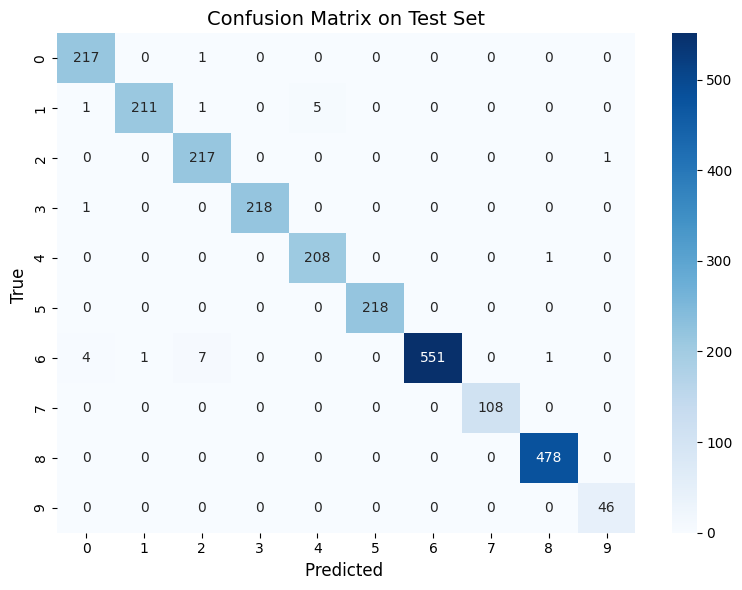

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Save classification report
report_dict = classification_report(all_labels, all_preds, output_dict=True)
pd.DataFrame(report_dict).transpose().to_csv("final_test_classification_report.csv")

# Compute and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title("Confusion Matrix on Test Set", fontsize=14)
plt.xlabel("Predicted ", fontsize=12)
plt.ylabel("True ", fontsize=12)
plt.tight_layout()
plt.show()

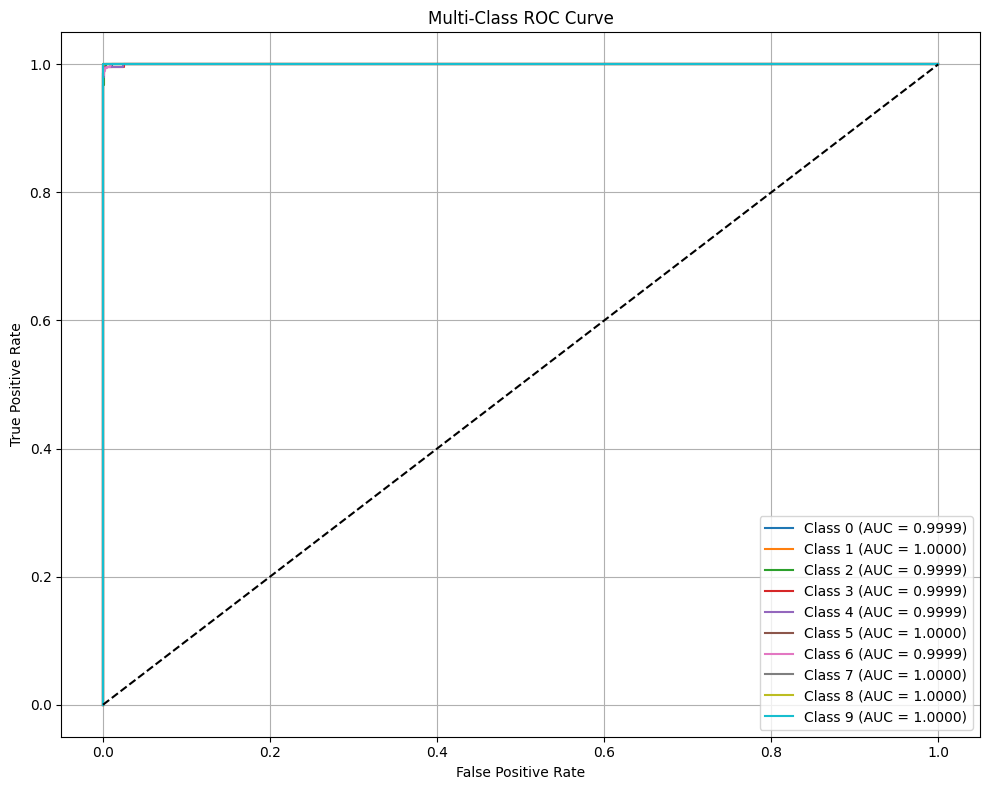

In [72]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Step 1: Binarize the labels for ROC computation
y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))  # shape (N, C)

# Step 2: Get softmax probabilities from model
y_scores = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        y_scores.extend(probs.cpu().numpy())
y_scores = np.array(y_scores)

# Step 3: Plot ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


# Efficient Net V2- M

In [77]:
def get_timm_model(model_name, num_classes):
    import timm
    import torch.nn as nn

    try:
        model = timm.create_model(model_name, pretrained=True, in_chans=1)
    except RuntimeError as e:
        if "No pretrained weights exist" in str(e):
            print(f"[INFO] No pretrained weights for {model_name} with in_chans=1 → using pretrained=False")
            model = timm.create_model(model_name, pretrained=False, in_chans=1)
        else:
            raise e

    if hasattr(model, 'fc'):
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'classifier'):
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'head'):
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'classif'):
        in_features = model.classif.in_features
        model.classif = nn.Linear(in_features, num_classes)
    else:
        raise ValueError(f"Unknown classifier structure for model: {model_name}")

    return model


In [78]:
def get_efficientnetv2m_bundle(num_classes=10, lr=1e-4, weight_decay=1e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_timm_model("efficientnetv2_m", num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    return model, device, criterion, optimizer


In [79]:
from torch.amp import autocast, GradScaler
from sklearn.metrics import f1_score
import torch
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=None):
    scaler = GradScaler()
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_f1_macro': [], 'val_classwise_f1': []
    }
    best_val_f1 = 0.0
    best_model_path = f"best_model_fold{fold+1}.pth" if fold is not None else "best_model.pth"

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=True):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            with autocast("cuda"):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == y_batch).item()

        train_loss /= len(train_loader.dataset)
        train_acc = 100. * train_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        all_preds, all_labels = [], []

        for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=True):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            with torch.no_grad(), autocast("cuda"):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == y_batch).item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        class_f1 = f1_score(all_labels, all_preds, average=None)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1_macro'].append(macro_f1)
        history['val_classwise_f1'].append(class_f1)

        if macro_f1 > best_val_f1:
            best_val_f1 = macro_f1
            torch.save(model.state_dict(), best_model_path)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
              f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, Val F1-Macro={macro_f1:.4f}")

    return history


In [80]:

# Initialize CV history dictionary
cv_history = {
    'train_acc': [], 'val_acc': [],
    'train_loss': [], 'val_loss': [],
    'val_f1_macro': [], 'val_classwise_f1': []
}

# Loop over folds
for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
    print(f"\n--- Fold {fold + 1} ---")

    # Prepare train/val data
    X_train = [X_trainval[i] for i in train_idx]
    y_train = [y_trainval[i] for i in train_idx]
    X_val = [X_trainval[i] for i in val_idx]
    y_val = [y_trainval[i] for i in val_idx]

    # Weighted sampler to handle class imbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
    sample_weights = [weight_map[y] for y in y_train]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    # DataLoaders with appropriate transforms
    train_dataset = STFTSingleChannelDataset(X_train, y_train, transform=transform)
    val_dataset = STFTSingleChannelDataset(X_val, y_val, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

    # Load model + training components
    model, device, criterion, optimizer = get_efficientnetv2m_bundle(num_classes=10, lr=1e-4, weight_decay=1e-5)

    # Train model on this fold
    history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=fold)

    # Store metrics from the last epoch of this fold
    cv_history['train_acc'].append(history['train_acc'][-1])
    cv_history['val_acc'].append(history['val_acc'][-1])
    cv_history['train_loss'].append(history['train_loss'][-1])
    cv_history['val_loss'].append(history['val_loss'][-1])
    cv_history['val_f1_macro'].append(history['val_f1_macro'][-1])
    cv_history['val_classwise_f1'].append(history['val_classwise_f1'][-1])



--- Fold 1 ---
[INFO] No pretrained weights for efficientnetv2_m with in_chans=1 → using pretrained=False


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.41it/s]


Epoch 1: Train Loss=1.5542, Val Loss=1.0543, Train Acc=44.11%, Val Acc=63.36%, Val F1-Macro=0.6504


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.78it/s]


Epoch 2: Train Loss=0.5803, Val Loss=0.3494, Train Acc=80.82%, Val Acc=87.99%, Val F1-Macro=0.8918


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.84it/s]


Epoch 3: Train Loss=0.2738, Val Loss=0.1671, Train Acc=91.43%, Val Acc=93.99%, Val F1-Macro=0.9485


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.78it/s]


Epoch 4: Train Loss=0.1772, Val Loss=0.1641, Train Acc=94.60%, Val Acc=94.79%, Val F1-Macro=0.9548


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.71it/s]


Epoch 5: Train Loss=0.1240, Val Loss=0.1148, Train Acc=96.37%, Val Acc=95.70%, Val F1-Macro=0.9624


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.77it/s]


Epoch 6: Train Loss=0.1027, Val Loss=0.0753, Train Acc=97.05%, Val Acc=97.90%, Val F1-Macro=0.9794


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.77it/s]


Epoch 7: Train Loss=0.0836, Val Loss=0.1307, Train Acc=97.63%, Val Acc=96.00%, Val F1-Macro=0.9716


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.81it/s]


Epoch 8: Train Loss=0.0914, Val Loss=0.0556, Train Acc=97.54%, Val Acc=98.60%, Val F1-Macro=0.9888


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.72it/s]


Epoch 9: Train Loss=0.0616, Val Loss=0.0537, Train Acc=98.30%, Val Acc=98.50%, Val F1-Macro=0.9885


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.67it/s]


Epoch 10: Train Loss=0.0590, Val Loss=0.0778, Train Acc=98.29%, Val Acc=97.90%, Val F1-Macro=0.9815

--- Fold 2 ---
[INFO] No pretrained weights for efficientnetv2_m with in_chans=1 → using pretrained=False


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 30.06it/s]


Epoch 1: Train Loss=1.5677, Val Loss=0.8342, Train Acc=42.84%, Val Acc=71.77%, Val F1-Macro=0.7327


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.66it/s]


Epoch 2: Train Loss=0.5694, Val Loss=0.2356, Train Acc=81.59%, Val Acc=92.89%, Val F1-Macro=0.9370


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.82it/s]


Epoch 3: Train Loss=0.2614, Val Loss=0.2432, Train Acc=91.92%, Val Acc=91.79%, Val F1-Macro=0.9198


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.55it/s]


Epoch 4: Train Loss=0.1551, Val Loss=0.1835, Train Acc=95.30%, Val Acc=94.09%, Val F1-Macro=0.9456


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.78it/s]


Epoch 5: Train Loss=0.1173, Val Loss=0.1131, Train Acc=96.64%, Val Acc=96.70%, Val F1-Macro=0.9688


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.78it/s]


Epoch 6: Train Loss=0.0853, Val Loss=0.0770, Train Acc=97.43%, Val Acc=97.10%, Val F1-Macro=0.9727


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.60it/s]


Epoch 7: Train Loss=0.0882, Val Loss=0.0809, Train Acc=97.30%, Val Acc=97.60%, Val F1-Macro=0.9745


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.71it/s]


Epoch 8: Train Loss=0.0885, Val Loss=0.0687, Train Acc=97.21%, Val Acc=98.30%, Val F1-Macro=0.9851


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.64it/s]


Epoch 9: Train Loss=0.0617, Val Loss=0.1016, Train Acc=98.16%, Val Acc=96.80%, Val F1-Macro=0.9689


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.73it/s]


Epoch 10: Train Loss=0.0557, Val Loss=0.0888, Train Acc=98.31%, Val Acc=96.90%, Val F1-Macro=0.9663

--- Fold 3 ---
[INFO] No pretrained weights for efficientnetv2_m with in_chans=1 → using pretrained=False


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.59it/s]


Epoch 1: Train Loss=1.5224, Val Loss=0.8713, Train Acc=45.38%, Val Acc=68.87%, Val F1-Macro=0.7130


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.83it/s]


Epoch 2: Train Loss=0.5176, Val Loss=0.3596, Train Acc=83.24%, Val Acc=89.09%, Val F1-Macro=0.8914


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.73it/s]


Epoch 3: Train Loss=0.2280, Val Loss=0.2245, Train Acc=92.74%, Val Acc=93.79%, Val F1-Macro=0.9488


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.59it/s]


Epoch 4: Train Loss=0.1571, Val Loss=0.1177, Train Acc=95.30%, Val Acc=96.70%, Val F1-Macro=0.9700


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.78it/s]


Epoch 5: Train Loss=0.1102, Val Loss=0.1189, Train Acc=96.77%, Val Acc=96.50%, Val F1-Macro=0.9670


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.68it/s]


Epoch 6: Train Loss=0.1155, Val Loss=0.1303, Train Acc=96.57%, Val Acc=96.40%, Val F1-Macro=0.9656


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.73it/s]


Epoch 7: Train Loss=0.0769, Val Loss=0.1506, Train Acc=97.86%, Val Acc=95.80%, Val F1-Macro=0.9560


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.70it/s]


Epoch 8: Train Loss=0.0892, Val Loss=0.0920, Train Acc=97.36%, Val Acc=97.40%, Val F1-Macro=0.9774


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.73it/s]


Epoch 9: Train Loss=0.0659, Val Loss=0.0613, Train Acc=98.06%, Val Acc=98.50%, Val F1-Macro=0.9831


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.65it/s]


Epoch 10: Train Loss=0.0551, Val Loss=0.0302, Train Acc=98.33%, Val Acc=98.80%, Val F1-Macro=0.9887

--- Fold 4 ---
[INFO] No pretrained weights for efficientnetv2_m with in_chans=1 → using pretrained=False


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.68it/s]


Epoch 1: Train Loss=1.5067, Val Loss=0.8722, Train Acc=45.83%, Val Acc=72.57%, Val F1-Macro=0.7243


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.63it/s]


Epoch 2: Train Loss=0.5182, Val Loss=0.3517, Train Acc=83.17%, Val Acc=88.59%, Val F1-Macro=0.8854


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.53it/s]


Epoch 3: Train Loss=0.2592, Val Loss=0.2565, Train Acc=92.10%, Val Acc=91.99%, Val F1-Macro=0.9260


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.48it/s]


Epoch 4: Train Loss=0.1623, Val Loss=0.1447, Train Acc=95.03%, Val Acc=94.89%, Val F1-Macro=0.9444


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.56it/s]


Epoch 5: Train Loss=0.1249, Val Loss=0.1153, Train Acc=96.20%, Val Acc=95.90%, Val F1-Macro=0.9508


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.69it/s]


Epoch 6: Train Loss=0.0820, Val Loss=0.2021, Train Acc=97.75%, Val Acc=93.89%, Val F1-Macro=0.9431


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.62it/s]


Epoch 7: Train Loss=0.1004, Val Loss=0.1440, Train Acc=97.17%, Val Acc=95.50%, Val F1-Macro=0.9500


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.62it/s]


Epoch 8: Train Loss=0.0756, Val Loss=0.0454, Train Acc=97.93%, Val Acc=98.80%, Val F1-Macro=0.9820


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.63it/s]


Epoch 9: Train Loss=0.0844, Val Loss=0.0606, Train Acc=97.53%, Val Acc=98.20%, Val F1-Macro=0.9825


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.49it/s]


Epoch 10: Train Loss=0.0472, Val Loss=0.0773, Train Acc=98.63%, Val Acc=98.00%, Val F1-Macro=0.9797

--- Fold 5 ---
[INFO] No pretrained weights for efficientnetv2_m with in_chans=1 → using pretrained=False


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.10it/s]


Epoch 1: Train Loss=1.5161, Val Loss=0.8178, Train Acc=45.96%, Val Acc=71.24%, Val F1-Macro=0.7147


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.70it/s]


Epoch 2: Train Loss=0.5497, Val Loss=0.3636, Train Acc=82.01%, Val Acc=87.47%, Val F1-Macro=0.8714


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.58it/s]


Epoch 3: Train Loss=0.2447, Val Loss=0.1444, Train Acc=92.33%, Val Acc=95.79%, Val F1-Macro=0.9601


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.68it/s]


Epoch 4: Train Loss=0.1671, Val Loss=0.1463, Train Acc=94.80%, Val Acc=95.29%, Val F1-Macro=0.9544


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.64it/s]


Epoch 5: Train Loss=0.1111, Val Loss=0.0959, Train Acc=96.56%, Val Acc=97.09%, Val F1-Macro=0.9738


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.51it/s]


Epoch 6: Train Loss=0.0985, Val Loss=0.0554, Train Acc=97.10%, Val Acc=98.80%, Val F1-Macro=0.9866


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.59it/s]


Epoch 7: Train Loss=0.0846, Val Loss=0.0439, Train Acc=97.65%, Val Acc=98.60%, Val F1-Macro=0.9861


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.67it/s]


Epoch 8: Train Loss=0.0747, Val Loss=0.0774, Train Acc=97.85%, Val Acc=97.60%, Val F1-Macro=0.9735


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.62it/s]


Epoch 9: Train Loss=0.0593, Val Loss=0.0639, Train Acc=98.36%, Val Acc=97.80%, Val F1-Macro=0.9779


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.63it/s]


Epoch 10: Train Loss=0.0740, Val Loss=0.1041, Train Acc=97.91%, Val Acc=97.09%, Val F1-Macro=0.9638

--- Fold 6 ---
[INFO] No pretrained weights for efficientnetv2_m with in_chans=1 → using pretrained=False


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.53it/s]


Epoch 1: Train Loss=1.5524, Val Loss=0.9437, Train Acc=44.60%, Val Acc=64.93%, Val F1-Macro=0.6586


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.71it/s]


Epoch 2: Train Loss=0.5701, Val Loss=0.3286, Train Acc=81.16%, Val Acc=87.98%, Val F1-Macro=0.8942


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.67it/s]


Epoch 3: Train Loss=0.2649, Val Loss=0.2615, Train Acc=91.40%, Val Acc=92.28%, Val F1-Macro=0.9195


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.47it/s]


Epoch 4: Train Loss=0.1732, Val Loss=0.1384, Train Acc=94.51%, Val Acc=95.49%, Val F1-Macro=0.9562


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.60it/s]


Epoch 5: Train Loss=0.1097, Val Loss=0.1194, Train Acc=96.76%, Val Acc=96.29%, Val F1-Macro=0.9602


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.54it/s]


Epoch 6: Train Loss=0.0937, Val Loss=0.1364, Train Acc=97.15%, Val Acc=95.89%, Val F1-Macro=0.9564


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.76it/s]


Epoch 7: Train Loss=0.0912, Val Loss=0.1598, Train Acc=97.20%, Val Acc=95.69%, Val F1-Macro=0.9519


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.58it/s]


Epoch 8: Train Loss=0.0766, Val Loss=0.1242, Train Acc=97.71%, Val Acc=96.69%, Val F1-Macro=0.9647


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.55it/s]


Epoch 9: Train Loss=0.0694, Val Loss=0.0740, Train Acc=98.10%, Val Acc=97.39%, Val F1-Macro=0.9689


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.73it/s]


Epoch 10: Train Loss=0.0708, Val Loss=0.0695, Train Acc=97.76%, Val Acc=97.60%, Val F1-Macro=0.9739

--- Fold 7 ---
[INFO] No pretrained weights for efficientnetv2_m with in_chans=1 → using pretrained=False


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.59it/s]


Epoch 1: Train Loss=1.6222, Val Loss=5.7192, Train Acc=41.72%, Val Acc=59.32%, Val F1-Macro=0.5987


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.58it/s]


Epoch 2: Train Loss=0.7020, Val Loss=0.5405, Train Acc=76.90%, Val Acc=84.67%, Val F1-Macro=0.8325


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.54it/s]


Epoch 3: Train Loss=0.3214, Val Loss=0.2847, Train Acc=89.57%, Val Acc=90.78%, Val F1-Macro=0.9123


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.49it/s]


Epoch 4: Train Loss=0.1889, Val Loss=0.1603, Train Acc=94.37%, Val Acc=95.29%, Val F1-Macro=0.9548


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.67it/s]


Epoch 5: Train Loss=0.1427, Val Loss=0.1391, Train Acc=95.55%, Val Acc=94.69%, Val F1-Macro=0.9537


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.63it/s]


Epoch 6: Train Loss=0.0949, Val Loss=0.1334, Train Acc=97.14%, Val Acc=96.49%, Val F1-Macro=0.9610


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.76it/s]


Epoch 7: Train Loss=0.0870, Val Loss=0.0623, Train Acc=97.28%, Val Acc=97.90%, Val F1-Macro=0.9815


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.60it/s]


Epoch 8: Train Loss=0.0791, Val Loss=0.1094, Train Acc=97.73%, Val Acc=96.69%, Val F1-Macro=0.9623


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.65it/s]


Epoch 9: Train Loss=0.0835, Val Loss=0.0942, Train Acc=97.46%, Val Acc=96.99%, Val F1-Macro=0.9729


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.55it/s]


Epoch 10: Train Loss=0.0673, Val Loss=0.0387, Train Acc=98.22%, Val Acc=98.50%, Val F1-Macro=0.9839

--- Fold 8 ---
[INFO] No pretrained weights for efficientnetv2_m with in_chans=1 → using pretrained=False


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.62it/s]


Epoch 1: Train Loss=1.4927, Val Loss=0.8450, Train Acc=46.57%, Val Acc=74.35%, Val F1-Macro=0.7675


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.67it/s]


Epoch 2: Train Loss=0.4986, Val Loss=0.2597, Train Acc=83.83%, Val Acc=91.48%, Val F1-Macro=0.9220


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.55it/s]


Epoch 3: Train Loss=0.2512, Val Loss=0.1151, Train Acc=91.91%, Val Acc=96.29%, Val F1-Macro=0.9701


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.63it/s]


Epoch 4: Train Loss=0.1553, Val Loss=0.2134, Train Acc=95.18%, Val Acc=93.39%, Val F1-Macro=0.9397


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.61it/s]


Epoch 5: Train Loss=0.1165, Val Loss=0.1404, Train Acc=96.54%, Val Acc=95.69%, Val F1-Macro=0.9575


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.53it/s]


Epoch 6: Train Loss=0.0899, Val Loss=0.1158, Train Acc=97.23%, Val Acc=96.29%, Val F1-Macro=0.9654


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.58it/s]


Epoch 7: Train Loss=0.0943, Val Loss=0.1215, Train Acc=97.07%, Val Acc=95.59%, Val F1-Macro=0.9529


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.75it/s]


Epoch 8: Train Loss=0.0848, Val Loss=0.0618, Train Acc=97.62%, Val Acc=97.70%, Val F1-Macro=0.9793


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.77it/s]


Epoch 9: Train Loss=0.0588, Val Loss=0.0566, Train Acc=98.26%, Val Acc=98.20%, Val F1-Macro=0.9846


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.60it/s]


Epoch 10: Train Loss=0.0666, Val Loss=0.0305, Train Acc=98.32%, Val Acc=99.00%, Val F1-Macro=0.9894

--- Fold 9 ---
[INFO] No pretrained weights for efficientnetv2_m with in_chans=1 → using pretrained=False


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.54it/s]


Epoch 1: Train Loss=1.5837, Val Loss=1.0347, Train Acc=43.81%, Val Acc=67.74%, Val F1-Macro=0.6732


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.58it/s]


Epoch 2: Train Loss=0.6466, Val Loss=0.5528, Train Acc=78.77%, Val Acc=82.87%, Val F1-Macro=0.8252


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.64it/s]


Epoch 3: Train Loss=0.3063, Val Loss=0.4475, Train Acc=90.17%, Val Acc=88.28%, Val F1-Macro=0.8835


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.68it/s]


Epoch 4: Train Loss=0.1663, Val Loss=0.2386, Train Acc=94.91%, Val Acc=92.38%, Val F1-Macro=0.9205


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.64it/s]


Epoch 5: Train Loss=0.1333, Val Loss=0.1637, Train Acc=96.11%, Val Acc=95.09%, Val F1-Macro=0.9480


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.64it/s]


Epoch 6: Train Loss=0.1082, Val Loss=0.1642, Train Acc=96.82%, Val Acc=95.19%, Val F1-Macro=0.9534


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.59it/s]


Epoch 7: Train Loss=0.0834, Val Loss=0.0779, Train Acc=97.50%, Val Acc=97.90%, Val F1-Macro=0.9794


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.78it/s]


Epoch 8: Train Loss=0.0925, Val Loss=0.1070, Train Acc=97.15%, Val Acc=96.89%, Val F1-Macro=0.9629


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.69it/s]


Epoch 9: Train Loss=0.0600, Val Loss=0.1000, Train Acc=98.28%, Val Acc=96.89%, Val F1-Macro=0.9571


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.71it/s]


Epoch 10: Train Loss=0.0573, Val Loss=0.0842, Train Acc=98.46%, Val Acc=97.60%, Val F1-Macro=0.9716

--- Fold 10 ---
[INFO] No pretrained weights for efficientnetv2_m with in_chans=1 → using pretrained=False


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.64it/s]


Epoch 1: Train Loss=1.5841, Val Loss=1.3708, Train Acc=43.38%, Val Acc=66.33%, Val F1-Macro=0.6794


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.59it/s]


Epoch 2: Train Loss=0.6115, Val Loss=0.3133, Train Acc=79.50%, Val Acc=88.98%, Val F1-Macro=0.8990


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.66it/s]


Epoch 3: Train Loss=0.3042, Val Loss=0.5238, Train Acc=90.15%, Val Acc=88.68%, Val F1-Macro=0.8976


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.61it/s]


Epoch 4: Train Loss=0.1819, Val Loss=0.1651, Train Acc=94.65%, Val Acc=95.99%, Val F1-Macro=0.9643


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.57it/s]


Epoch 5: Train Loss=0.1442, Val Loss=0.1992, Train Acc=95.59%, Val Acc=93.99%, Val F1-Macro=0.9357


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.55it/s]


Epoch 6: Train Loss=0.1061, Val Loss=0.1719, Train Acc=97.04%, Val Acc=94.19%, Val F1-Macro=0.9456


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.57it/s]


Epoch 7: Train Loss=0.0919, Val Loss=0.1123, Train Acc=97.25%, Val Acc=96.19%, Val F1-Macro=0.9646


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.61it/s]


Epoch 8: Train Loss=0.0854, Val Loss=0.1239, Train Acc=97.57%, Val Acc=95.89%, Val F1-Macro=0.9621


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.58it/s]


Epoch 9: Train Loss=0.0612, Val Loss=0.0858, Train Acc=98.30%, Val Acc=97.70%, Val F1-Macro=0.9753


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:02<00:00, 29.67it/s]

Epoch 10: Train Loss=0.0661, Val Loss=0.1267, Train Acc=97.91%, Val Acc=96.09%, Val F1-Macro=0.9658


In [82]:
num_classes = 10
best_fold = np.argmax(cv_history['val_f1_macro'])

# ✅ Only get the model
model = get_efficientnetv2m_bundle(num_classes)[0]  # Unpack only the model
model.load_state_dict(torch.load(f"best_model_fold{best_fold+1}.pth"))
model = model.to(device)
model.eval()

# Predict
all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

acc = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average='macro')
report = classification_report(all_labels, all_preds, digits=4, labels=range(num_classes))
cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))

print("\n=== Final Test Set Evaluation ===")
print(f"Accuracy       : {acc:.4f}")
print(f"Macro F1-score : {macro_f1:.4f}")
print("\nClassification Report:\n", report)


[INFO] No pretrained weights for efficientnetv2_m with in_chans=1 → using pretrained=False

=== Final Test Set Evaluation ===
Accuracy       : 0.9824
Macro F1-score : 0.9841

Classification Report:
               precision    recall  f1-score   support

           0     0.9391    0.9908    0.9643       218
           1     0.9906    0.9679    0.9791       218
           2     0.9766    0.9587    0.9676       218
           3     0.9865    1.0000    0.9932       219
           4     0.9951    0.9761    0.9855       209
           5     0.9732    1.0000    0.9864       218
           6     0.9856    0.9716    0.9786       564
           7     1.0000    0.9907    0.9953       108
           8     0.9896    0.9916    0.9906       478
           9     1.0000    1.0000    1.0000        46

    accuracy                         0.9824      2496
   macro avg     0.9836    0.9848    0.9841      2496
weighted avg     0.9826    0.9824    0.9824      2496



In [83]:
import pandas as pd

# Create a DataFrame from cv_history
fold_summary = pd.DataFrame({
    "Fold": [f"Fold {i+1}" for i in range(len(cv_history['train_acc']))],
    "Train Accuracy (%)": cv_history['train_acc'],
    "Val Accuracy (%)": cv_history['val_acc'],
    "Train Loss": cv_history['train_loss'],
    "Val Loss": cv_history['val_loss'],
    "Val Macro F1": cv_history['val_f1_macro']
})

# Round values to 4 decimals
fold_summary = fold_summary.round(4)

# Print neatly
print("\n=== Per-Fold Summary ===")
print(fold_summary)

# Optionally save it
fold_summary.to_csv("cv_fold_summary.csv", index=False)



=== Per-Fold Summary ===
      Fold  Train Accuracy (%)  Val Accuracy (%)  Train Loss  Val Loss  \
0   Fold 1             98.2860           97.8979      0.0590    0.0778   
1   Fold 2             98.3083           96.8969      0.0557    0.0888   
2   Fold 3             98.3306           98.7988      0.0551    0.0302   
3   Fold 4             98.6311           97.9980      0.0472    0.0773   
4   Fold 5             97.9079           97.0942      0.0740    0.1041   
5   Fold 6             97.7632           97.5952      0.0708    0.0695   
6   Fold 7             98.2195           98.4970      0.0673    0.0387   
7   Fold 8             98.3196           98.9980      0.0666    0.0305   
8   Fold 9             98.4643           97.5952      0.0573    0.0842   
9  Fold 10             97.9079           96.0922      0.0661    0.1267   

   Val Macro F1  
0        0.9815  
1        0.9663  
2        0.9887  
3        0.9797  
4        0.9638  
5        0.9739  
6        0.9839  
7        0.9894

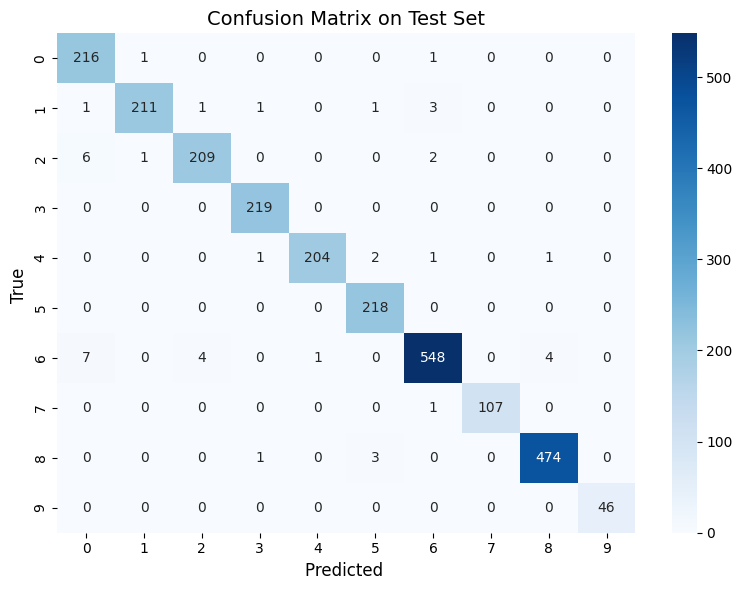

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Save classification report
report_dict = classification_report(all_labels, all_preds, output_dict=True)
pd.DataFrame(report_dict).transpose().to_csv("final_test_classification_report.csv")

# Compute and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title("Confusion Matrix on Test Set", fontsize=14)
plt.xlabel("Predicted ", fontsize=12)
plt.ylabel("True ", fontsize=12)
plt.tight_layout()
plt.show()

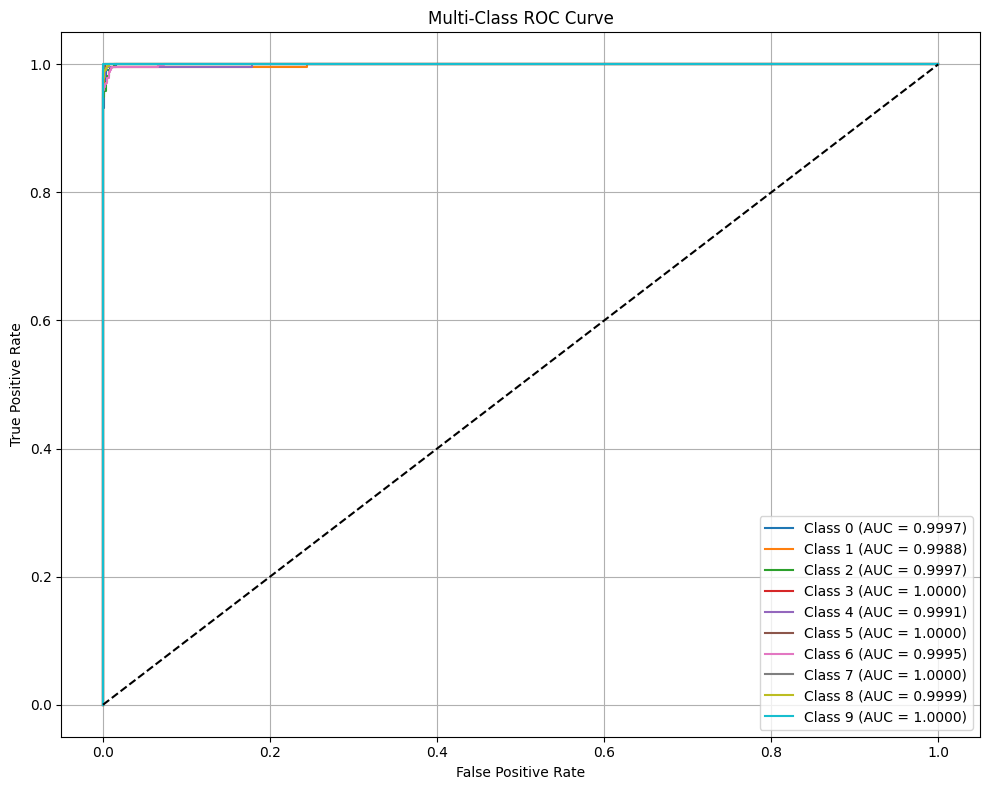

In [85]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Step 1: Binarize the labels for ROC computation
y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))  # shape (N, C)

# Step 2: Get softmax probabilities from model
y_scores = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        y_scores.extend(probs.cpu().numpy())
y_scores = np.array(y_scores)

# Step 3: Plot ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


## Inception Net V3

In [87]:
def get_timm_model(model_name, num_classes):
    try:
        model = timm.create_model(model_name, pretrained=True, in_chans=1)
    except RuntimeError as e:
        if "No pretrained weights exist" in str(e):
            print(f"[INFO] No pretrained weights for {model_name} with in_chans=1 → using pretrained=False")
            model = timm.create_model(model_name, pretrained=False, in_chans=1)
        else:
            raise e

    # Replace classification head
    if hasattr(model, 'fc'):
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'classifier'):
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'head'):
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, num_classes)
    elif hasattr(model, 'classif'):
        in_features = model.classif.in_features
        model.classif = nn.Linear(in_features, num_classes)
    else:
        raise ValueError(f"Unknown classifier structure for model: {model_name}")

    return model


In [92]:
def get_inceptionv3_bundle(num_classes=10, lr=1e-4, weight_decay=1e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_timm_model("inception_v3", num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    return model, device, criterion, optimizer


In [93]:
from torch.amp import autocast, GradScaler
from sklearn.metrics import f1_score
import torch
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=None):
    scaler = GradScaler()
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_f1_macro': [], 'val_classwise_f1': []
    }
    best_val_f1 = 0.0
    best_model_path = f"best_model_fold{fold+1}.pth" if fold is not None else "best_model.pth"

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=True):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            with autocast("cuda"):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == y_batch).item()

        train_loss /= len(train_loader.dataset)
        train_acc = 100. * train_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        all_preds, all_labels = [], []

        for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=True):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            with torch.no_grad(), autocast("cuda"):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == y_batch).item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        class_f1 = f1_score(all_labels, all_preds, average=None)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1_macro'].append(macro_f1)
        history['val_classwise_f1'].append(class_f1)

        if macro_f1 > best_val_f1:
            best_val_f1 = macro_f1
            torch.save(model.state_dict(), best_model_path)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
              f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%, Val F1-Macro={macro_f1:.4f}")

    return history


In [94]:

# Initialize CV history dictionary
cv_history = {
    'train_acc': [], 'val_acc': [],
    'train_loss': [], 'val_loss': [],
    'val_f1_macro': [], 'val_classwise_f1': []
}

# Loop over folds
for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
    print(f"\n--- Fold {fold + 1} ---")

    # Prepare train/val data
    X_train = [X_trainval[i] for i in train_idx]
    y_train = [y_trainval[i] for i in train_idx]
    X_val = [X_trainval[i] for i in val_idx]
    y_val = [y_trainval[i] for i in val_idx]

    # Weighted sampler to handle class imbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weight_map = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}
    sample_weights = [weight_map[y] for y in y_train]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    # DataLoaders with appropriate transforms
    train_dataset = STFTSingleChannelDataset(X_train, y_train, transform=transform)
    val_dataset = STFTSingleChannelDataset(X_val, y_val, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

    # Load model + training components
    model, device, criterion, optimizer = get_inceptionv3_bundle(num_classes=10, lr=1e-4, weight_decay=1e-5)

    # Train model on this fold
    history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, fold=fold)

    # Store metrics from the last epoch of this fold
    cv_history['train_acc'].append(history['train_acc'][-1])
    cv_history['val_acc'].append(history['val_acc'][-1])
    cv_history['train_loss'].append(history['train_loss'][-1])
    cv_history['val_loss'].append(history['val_loss'][-1])
    cv_history['val_f1_macro'].append(history['val_f1_macro'][-1])
    cv_history['val_classwise_f1'].append(history['val_classwise_f1'][-1])



--- Fold 1 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 55.57it/s]


Epoch 1: Train Loss=0.6880, Val Loss=0.1682, Train Acc=77.75%, Val Acc=94.19%, Val F1-Macro=0.9432


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.27it/s]


Epoch 2: Train Loss=0.1556, Val Loss=0.0799, Train Acc=95.30%, Val Acc=97.70%, Val F1-Macro=0.9810


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 58.07it/s]


Epoch 3: Train Loss=0.0788, Val Loss=0.0518, Train Acc=97.50%, Val Acc=98.60%, Val F1-Macro=0.9880


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.76it/s]


Epoch 4: Train Loss=0.0551, Val Loss=0.0362, Train Acc=98.50%, Val Acc=98.90%, Val F1-Macro=0.9893


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 56.76it/s]


Epoch 5: Train Loss=0.0498, Val Loss=0.0508, Train Acc=98.55%, Val Acc=98.40%, Val F1-Macro=0.9829


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.43it/s]


Epoch 6: Train Loss=0.0469, Val Loss=0.0482, Train Acc=98.52%, Val Acc=98.60%, Val F1-Macro=0.9850


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.46it/s]


Epoch 7: Train Loss=0.0409, Val Loss=0.0670, Train Acc=98.83%, Val Acc=97.70%, Val F1-Macro=0.9755


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.86it/s]


Epoch 8: Train Loss=0.0463, Val Loss=0.0461, Train Acc=98.69%, Val Acc=99.00%, Val F1-Macro=0.9888


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.72it/s]


Epoch 9: Train Loss=0.0295, Val Loss=0.0791, Train Acc=99.24%, Val Acc=97.20%, Val F1-Macro=0.9734


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.71it/s]


Epoch 10: Train Loss=0.0379, Val Loss=0.0210, Train Acc=98.86%, Val Acc=99.10%, Val F1-Macro=0.9891

--- Fold 2 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.57it/s]


Epoch 1: Train Loss=0.6806, Val Loss=0.2112, Train Acc=78.30%, Val Acc=92.59%, Val F1-Macro=0.9280


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 58.38it/s]


Epoch 2: Train Loss=0.1607, Val Loss=0.0491, Train Acc=94.92%, Val Acc=98.20%, Val F1-Macro=0.9806


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 58.28it/s]


Epoch 3: Train Loss=0.0807, Val Loss=0.0297, Train Acc=97.58%, Val Acc=99.10%, Val F1-Macro=0.9896


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.58it/s]


Epoch 4: Train Loss=0.0581, Val Loss=0.0421, Train Acc=98.27%, Val Acc=98.90%, Val F1-Macro=0.9889


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.54it/s]


Epoch 5: Train Loss=0.0435, Val Loss=0.0176, Train Acc=98.74%, Val Acc=99.40%, Val F1-Macro=0.9916


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.66it/s]


Epoch 6: Train Loss=0.0497, Val Loss=0.0626, Train Acc=98.53%, Val Acc=98.50%, Val F1-Macro=0.9768


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.88it/s]


Epoch 7: Train Loss=0.0481, Val Loss=0.0998, Train Acc=98.66%, Val Acc=97.40%, Val F1-Macro=0.9727


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.51it/s]


Epoch 8: Train Loss=0.0415, Val Loss=0.0336, Train Acc=98.70%, Val Acc=99.20%, Val F1-Macro=0.9907


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.58it/s]


Epoch 9: Train Loss=0.0345, Val Loss=0.0249, Train Acc=99.12%, Val Acc=99.10%, Val F1-Macro=0.9901


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 58.09it/s]


Epoch 10: Train Loss=0.0309, Val Loss=0.0155, Train Acc=99.02%, Val Acc=99.70%, Val F1-Macro=0.9972

--- Fold 3 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.67it/s]


Epoch 1: Train Loss=0.6898, Val Loss=0.1903, Train Acc=77.70%, Val Acc=94.09%, Val F1-Macro=0.9482


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.97it/s]


Epoch 2: Train Loss=0.1511, Val Loss=0.0517, Train Acc=95.30%, Val Acc=98.10%, Val F1-Macro=0.9779


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.68it/s]


Epoch 3: Train Loss=0.0838, Val Loss=0.0457, Train Acc=97.56%, Val Acc=98.50%, Val F1-Macro=0.9851


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.85it/s]


Epoch 4: Train Loss=0.0573, Val Loss=0.0571, Train Acc=98.26%, Val Acc=98.30%, Val F1-Macro=0.9828


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.77it/s]


Epoch 5: Train Loss=0.0526, Val Loss=0.0681, Train Acc=98.31%, Val Acc=97.80%, Val F1-Macro=0.9810


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 56.97it/s]


Epoch 6: Train Loss=0.0538, Val Loss=0.0098, Train Acc=98.41%, Val Acc=99.80%, Val F1-Macro=0.9984


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.77it/s]


Epoch 7: Train Loss=0.0419, Val Loss=0.0201, Train Acc=98.82%, Val Acc=99.40%, Val F1-Macro=0.9938


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 58.16it/s]


Epoch 8: Train Loss=0.0265, Val Loss=0.0145, Train Acc=99.24%, Val Acc=99.70%, Val F1-Macro=0.9966


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.35it/s]


Epoch 9: Train Loss=0.0372, Val Loss=0.0213, Train Acc=98.92%, Val Acc=99.30%, Val F1-Macro=0.9937


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.83it/s]


Epoch 10: Train Loss=0.0282, Val Loss=0.0221, Train Acc=99.25%, Val Acc=99.40%, Val F1-Macro=0.9940

--- Fold 4 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.52it/s]


Epoch 1: Train Loss=0.7152, Val Loss=0.1766, Train Acc=77.13%, Val Acc=93.89%, Val F1-Macro=0.9324


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.65it/s]


Epoch 2: Train Loss=0.1427, Val Loss=0.0634, Train Acc=95.70%, Val Acc=98.00%, Val F1-Macro=0.9795


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 58.11it/s]


Epoch 3: Train Loss=0.0934, Val Loss=0.0990, Train Acc=97.04%, Val Acc=96.90%, Val F1-Macro=0.9644


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.72it/s]


Epoch 4: Train Loss=0.0707, Val Loss=0.0528, Train Acc=97.79%, Val Acc=98.50%, Val F1-Macro=0.9857


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.13it/s]


Epoch 5: Train Loss=0.0312, Val Loss=0.0375, Train Acc=99.22%, Val Acc=99.00%, Val F1-Macro=0.9836


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.52it/s]


Epoch 6: Train Loss=0.0685, Val Loss=0.0742, Train Acc=98.13%, Val Acc=98.20%, Val F1-Macro=0.9762


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.88it/s]


Epoch 7: Train Loss=0.0424, Val Loss=0.0353, Train Acc=98.72%, Val Acc=99.20%, Val F1-Macro=0.9932


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.83it/s]


Epoch 8: Train Loss=0.0318, Val Loss=0.0210, Train Acc=98.99%, Val Acc=99.40%, Val F1-Macro=0.9945


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.78it/s]


Epoch 9: Train Loss=0.0299, Val Loss=0.0900, Train Acc=99.23%, Val Acc=97.50%, Val F1-Macro=0.9716


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.57it/s]


Epoch 10: Train Loss=0.0376, Val Loss=0.0379, Train Acc=98.82%, Val Acc=99.10%, Val F1-Macro=0.9910

--- Fold 5 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 54.82it/s]


Epoch 1: Train Loss=0.7005, Val Loss=0.1941, Train Acc=77.52%, Val Acc=94.09%, Val F1-Macro=0.9456


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 58.11it/s]


Epoch 2: Train Loss=0.1523, Val Loss=0.0758, Train Acc=95.34%, Val Acc=98.00%, Val F1-Macro=0.9795


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.63it/s]


Epoch 3: Train Loss=0.0856, Val Loss=0.0502, Train Acc=97.37%, Val Acc=98.90%, Val F1-Macro=0.9891


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.98it/s]


Epoch 4: Train Loss=0.0662, Val Loss=0.0473, Train Acc=98.03%, Val Acc=98.60%, Val F1-Macro=0.9881


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.52it/s]


Epoch 5: Train Loss=0.0542, Val Loss=0.0253, Train Acc=98.39%, Val Acc=99.20%, Val F1-Macro=0.9918


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.50it/s]


Epoch 6: Train Loss=0.0463, Val Loss=0.0359, Train Acc=98.74%, Val Acc=98.80%, Val F1-Macro=0.9816


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.57it/s]


Epoch 7: Train Loss=0.0455, Val Loss=0.0161, Train Acc=98.88%, Val Acc=99.30%, Val F1-Macro=0.9931


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.84it/s]


Epoch 8: Train Loss=0.0337, Val Loss=0.0063, Train Acc=99.04%, Val Acc=99.90%, Val F1-Macro=0.9989


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.84it/s]


Epoch 9: Train Loss=0.0224, Val Loss=0.0242, Train Acc=99.37%, Val Acc=99.30%, Val F1-Macro=0.9944


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.46it/s]


Epoch 10: Train Loss=0.0541, Val Loss=0.0267, Train Acc=98.34%, Val Acc=99.10%, Val F1-Macro=0.9914

--- Fold 6 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 58.25it/s]


Epoch 1: Train Loss=0.6798, Val Loss=0.1309, Train Acc=78.59%, Val Acc=96.09%, Val F1-Macro=0.9509


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.83it/s]


Epoch 2: Train Loss=0.1483, Val Loss=0.0512, Train Acc=95.73%, Val Acc=98.10%, Val F1-Macro=0.9761


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.83it/s]


Epoch 3: Train Loss=0.0781, Val Loss=0.0407, Train Acc=97.77%, Val Acc=98.50%, Val F1-Macro=0.9811


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.89it/s]


Epoch 4: Train Loss=0.0562, Val Loss=0.0565, Train Acc=98.36%, Val Acc=98.30%, Val F1-Macro=0.9804


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.59it/s]


Epoch 5: Train Loss=0.0605, Val Loss=0.0536, Train Acc=98.14%, Val Acc=98.50%, Val F1-Macro=0.9791


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 58.07it/s]


Epoch 6: Train Loss=0.0399, Val Loss=0.0517, Train Acc=98.81%, Val Acc=98.50%, Val F1-Macro=0.9795


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.37it/s]


Epoch 7: Train Loss=0.0359, Val Loss=0.0192, Train Acc=98.90%, Val Acc=99.30%, Val F1-Macro=0.9887


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.62it/s]


Epoch 8: Train Loss=0.0432, Val Loss=0.0261, Train Acc=98.75%, Val Acc=99.00%, Val F1-Macro=0.9857


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.71it/s]


Epoch 9: Train Loss=0.0431, Val Loss=0.0288, Train Acc=98.82%, Val Acc=99.30%, Val F1-Macro=0.9884


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 58.38it/s]


Epoch 10: Train Loss=0.0212, Val Loss=0.0302, Train Acc=99.44%, Val Acc=98.90%, Val F1-Macro=0.9867

--- Fold 7 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.82it/s]


Epoch 1: Train Loss=0.7078, Val Loss=0.1251, Train Acc=77.48%, Val Acc=96.59%, Val F1-Macro=0.9707


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 58.00it/s]


Epoch 2: Train Loss=0.1492, Val Loss=0.0838, Train Acc=95.45%, Val Acc=97.39%, Val F1-Macro=0.9763


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.47it/s]


Epoch 3: Train Loss=0.0834, Val Loss=0.1000, Train Acc=97.50%, Val Acc=97.19%, Val F1-Macro=0.9771


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.73it/s]


Epoch 4: Train Loss=0.0755, Val Loss=0.0458, Train Acc=97.80%, Val Acc=98.80%, Val F1-Macro=0.9874


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.81it/s]


Epoch 5: Train Loss=0.0557, Val Loss=0.0733, Train Acc=98.29%, Val Acc=97.90%, Val F1-Macro=0.9774


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.41it/s]


Epoch 6: Train Loss=0.0478, Val Loss=0.0462, Train Acc=98.58%, Val Acc=98.50%, Val F1-Macro=0.9863


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.77it/s]


Epoch 7: Train Loss=0.0403, Val Loss=0.0375, Train Acc=98.86%, Val Acc=98.90%, Val F1-Macro=0.9893


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.67it/s]


Epoch 8: Train Loss=0.0347, Val Loss=0.0435, Train Acc=99.05%, Val Acc=99.20%, Val F1-Macro=0.9924


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.93it/s]


Epoch 9: Train Loss=0.0318, Val Loss=0.0231, Train Acc=99.30%, Val Acc=99.30%, Val F1-Macro=0.9933


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 58.00it/s]


Epoch 10: Train Loss=0.0350, Val Loss=0.0343, Train Acc=98.90%, Val Acc=98.80%, Val F1-Macro=0.9869

--- Fold 8 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.43it/s]


Epoch 1: Train Loss=0.6865, Val Loss=0.1541, Train Acc=78.14%, Val Acc=95.49%, Val F1-Macro=0.9600


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.57it/s]


Epoch 2: Train Loss=0.1512, Val Loss=0.0515, Train Acc=95.44%, Val Acc=98.40%, Val F1-Macro=0.9829


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.55it/s]


Epoch 3: Train Loss=0.0951, Val Loss=0.0466, Train Acc=97.16%, Val Acc=98.30%, Val F1-Macro=0.9815


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.93it/s]


Epoch 4: Train Loss=0.0561, Val Loss=0.0181, Train Acc=98.49%, Val Acc=99.30%, Val F1-Macro=0.9946


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.53it/s]


Epoch 5: Train Loss=0.0434, Val Loss=0.0253, Train Acc=98.71%, Val Acc=99.20%, Val F1-Macro=0.9903


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.00it/s]


Epoch 6: Train Loss=0.0585, Val Loss=0.0544, Train Acc=98.28%, Val Acc=97.80%, Val F1-Macro=0.9786


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.35it/s]


Epoch 7: Train Loss=0.0431, Val Loss=0.0251, Train Acc=98.90%, Val Acc=99.00%, Val F1-Macro=0.9905


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.75it/s]


Epoch 8: Train Loss=0.0391, Val Loss=0.0246, Train Acc=98.84%, Val Acc=99.20%, Val F1-Macro=0.9922


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.47it/s]


Epoch 9: Train Loss=0.0452, Val Loss=0.0428, Train Acc=98.69%, Val Acc=98.70%, Val F1-Macro=0.9891


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.84it/s]


Epoch 10: Train Loss=0.0262, Val Loss=0.0093, Train Acc=99.25%, Val Acc=99.80%, Val F1-Macro=0.9974

--- Fold 9 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.59it/s]


Epoch 1: Train Loss=0.7251, Val Loss=0.1775, Train Acc=76.27%, Val Acc=94.29%, Val F1-Macro=0.9451


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 58.12it/s]


Epoch 2: Train Loss=0.1523, Val Loss=0.0673, Train Acc=95.25%, Val Acc=97.90%, Val F1-Macro=0.9744


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.53it/s]


Epoch 3: Train Loss=0.0984, Val Loss=0.0713, Train Acc=97.05%, Val Acc=97.90%, Val F1-Macro=0.9740


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.88it/s]


Epoch 4: Train Loss=0.0592, Val Loss=0.0439, Train Acc=98.17%, Val Acc=98.50%, Val F1-Macro=0.9832


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.78it/s]


Epoch 5: Train Loss=0.0557, Val Loss=0.0626, Train Acc=98.21%, Val Acc=98.10%, Val F1-Macro=0.9816


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.24it/s]


Epoch 6: Train Loss=0.0444, Val Loss=0.0384, Train Acc=98.55%, Val Acc=98.70%, Val F1-Macro=0.9873


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.49it/s]


Epoch 7: Train Loss=0.0347, Val Loss=0.0712, Train Acc=99.00%, Val Acc=97.80%, Val F1-Macro=0.9810


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.79it/s]


Epoch 8: Train Loss=0.0372, Val Loss=0.0476, Train Acc=98.99%, Val Acc=98.30%, Val F1-Macro=0.9810


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.73it/s]


Epoch 9: Train Loss=0.0339, Val Loss=0.0321, Train Acc=98.97%, Val Acc=99.00%, Val F1-Macro=0.9909


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.41it/s]


Epoch 10: Train Loss=0.0311, Val Loss=0.0585, Train Acc=99.24%, Val Acc=98.60%, Val F1-Macro=0.9787

--- Fold 10 ---


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.71it/s]


Epoch 1: Train Loss=0.7126, Val Loss=0.2421, Train Acc=77.00%, Val Acc=92.38%, Val F1-Macro=0.9322


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.77it/s]


Epoch 2: Train Loss=0.1524, Val Loss=0.1218, Train Acc=95.38%, Val Acc=95.89%, Val F1-Macro=0.9617


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.73it/s]


Epoch 3: Train Loss=0.0951, Val Loss=0.0566, Train Acc=97.11%, Val Acc=98.10%, Val F1-Macro=0.9769


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.69it/s]


Epoch 4: Train Loss=0.0675, Val Loss=0.0402, Train Acc=98.07%, Val Acc=98.80%, Val F1-Macro=0.9877


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.96it/s]


Epoch 5: Train Loss=0.0579, Val Loss=0.0430, Train Acc=98.19%, Val Acc=98.60%, Val F1-Macro=0.9878


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.91it/s]


Epoch 6: Train Loss=0.0486, Val Loss=0.0284, Train Acc=98.61%, Val Acc=99.20%, Val F1-Macro=0.9922


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.83it/s]


Epoch 7: Train Loss=0.0343, Val Loss=0.0368, Train Acc=99.10%, Val Acc=98.80%, Val F1-Macro=0.9882


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.21it/s]


Epoch 8: Train Loss=0.0458, Val Loss=0.0324, Train Acc=98.53%, Val Acc=99.00%, Val F1-Macro=0.9916


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 58.22it/s]


Epoch 9: Train Loss=0.0313, Val Loss=0.0260, Train Acc=99.12%, Val Acc=99.20%, Val F1-Macro=0.9921


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:01<00:00, 57.75it/s]

Epoch 10: Train Loss=0.0345, Val Loss=0.0668, Train Acc=98.98%, Val Acc=98.00%, Val F1-Macro=0.9736


In [95]:
num_classes = 10
best_fold = np.argmax(cv_history['val_f1_macro'])

# ✅ Only get the model
model = get_inceptionv3_bundle(num_classes)[0]  # Unpack only the model
model.load_state_dict(torch.load(f"best_model_fold{best_fold+1}.pth"))
model = model.to(device)
model.eval()

# Predict
all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

acc = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average='macro')
report = classification_report(all_labels, all_preds, digits=4, labels=range(num_classes))
cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))

print("\n=== Final Test Set Evaluation ===")
print(f"Accuracy       : {acc:.4f}")
print(f"Macro F1-score : {macro_f1:.4f}")
print("\nClassification Report:\n", report)



=== Final Test Set Evaluation ===
Accuracy       : 0.9960
Macro F1-score : 0.9950

Classification Report:
               precision    recall  f1-score   support

           0     0.9863    0.9908    0.9886       218
           1     0.9954    0.9954    0.9954       218
           2     0.9908    0.9908    0.9908       218
           3     0.9954    0.9954    0.9954       219
           4     0.9905    0.9952    0.9928       209
           5     1.0000    1.0000    1.0000       218
           6     1.0000    0.9947    0.9973       564
           7     1.0000    1.0000    1.0000       108
           8     1.0000    1.0000    1.0000       478
           9     0.9787    1.0000    0.9892        46

    accuracy                         0.9960      2496
   macro avg     0.9937    0.9962    0.9950      2496
weighted avg     0.9960    0.9960    0.9960      2496



In [96]:
import pandas as pd

# Create a DataFrame from cv_history
fold_summary = pd.DataFrame({
    "Fold": [f"Fold {i+1}" for i in range(len(cv_history['train_acc']))],
    "Train Accuracy (%)": cv_history['train_acc'],
    "Val Accuracy (%)": cv_history['val_acc'],
    "Train Loss": cv_history['train_loss'],
    "Val Loss": cv_history['val_loss'],
    "Val Macro F1": cv_history['val_f1_macro']
})

# Round values to 4 decimals
fold_summary = fold_summary.round(4)

# Print neatly
print("\n=== Per-Fold Summary ===")
print(fold_summary)

# Optionally save it
fold_summary.to_csv("cv_fold_summary.csv", index=False)



=== Per-Fold Summary ===
      Fold  Train Accuracy (%)  Val Accuracy (%)  Train Loss  Val Loss  \
0   Fold 1             98.8648           99.0991      0.0379    0.0210   
1   Fold 2             99.0206           99.6997      0.0309    0.0155   
2   Fold 3             99.2543           99.3994      0.0282    0.0221   
3   Fold 4             98.8203           99.0991      0.0376    0.0379   
4   Fold 5             98.3419           99.0982      0.0541    0.0267   
5   Fold 6             99.4436           98.8978      0.0212    0.0302   
6   Fold 7             98.8983           98.7976      0.0350    0.0343   
7   Fold 8             99.2544           99.7996      0.0262    0.0093   
8   Fold 9             99.2433           98.5972      0.0311    0.0585   
9  Fold 10             98.9762           97.9960      0.0345    0.0668   

   Val Macro F1  
0        0.9891  
1        0.9972  
2        0.9940  
3        0.9910  
4        0.9914  
5        0.9867  
6        0.9869  
7        0.9974

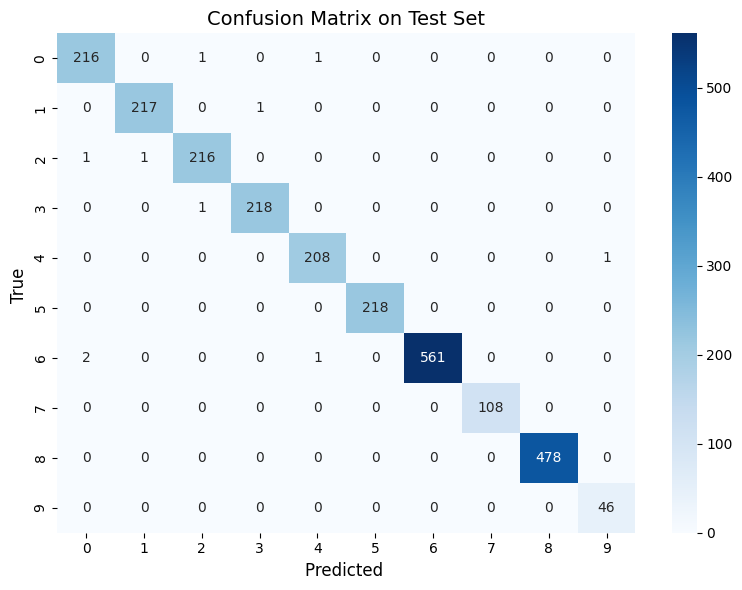

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Save classification report
report_dict = classification_report(all_labels, all_preds, output_dict=True)
pd.DataFrame(report_dict).transpose().to_csv("final_test_classification_report.csv")

# Compute and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title("Confusion Matrix on Test Set", fontsize=14)
plt.xlabel("Predicted ", fontsize=12)
plt.ylabel("True ", fontsize=12)
plt.tight_layout()
plt.show()

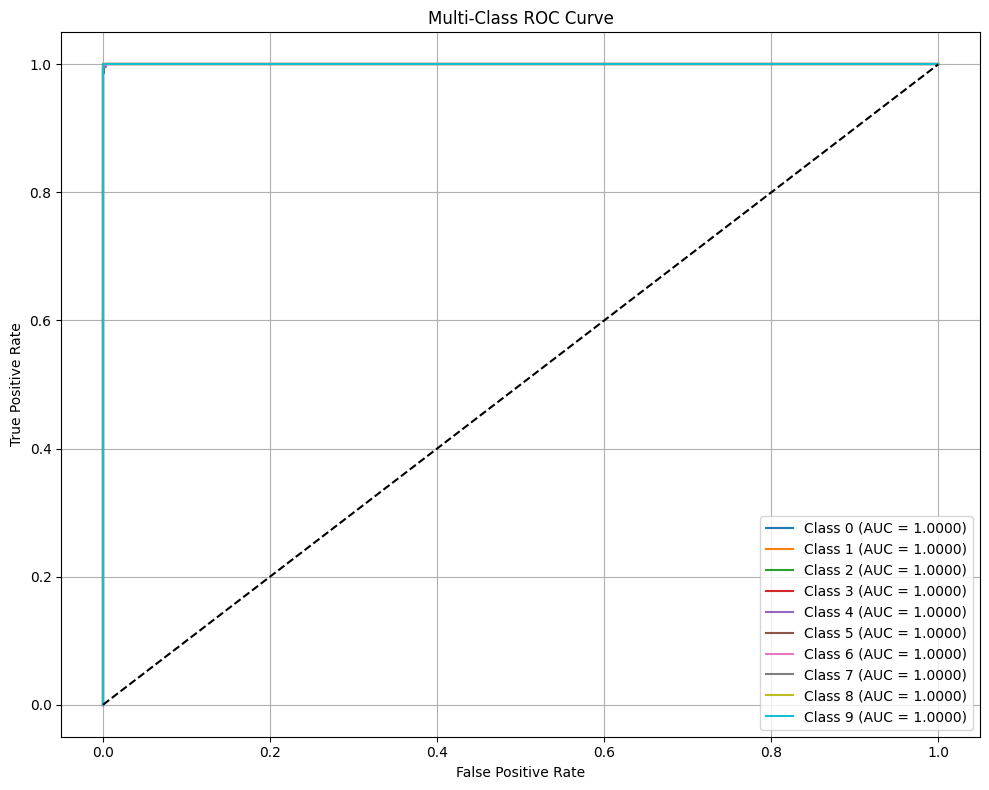

In [98]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Step 1: Binarize the labels for ROC computation
y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))  # shape (N, C)

# Step 2: Get softmax probabilities from model
y_scores = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        y_scores.extend(probs.cpu().numpy())
y_scores = np.array(y_scores)

# Step 3: Plot ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
